In [14]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler # Import MinMaxScaler

# Montar o Google Drive (se ainda não estiver montado)
from google.colab import drive
drive.mount('/content/drive')

# Caminho para a pasta no Google Drive que contém os arquivos CSV
# Using the path from previous interactions as a default
caminho_da_pasta = "/content/drive/MyDrive/1/"

print(f"📂 Tentando carregar arquivos da pasta: {caminho_da_pasta}")

lista_dataframes = []
arquivos_csv = []

# Check if the directory exists before listing files
if os.path.exists(caminho_da_pasta):
    arquivos_csv = [f for f in os.listdir(caminho_da_pasta) if f.endswith('.csv')]
    if not arquivos_csv:
        print("❌ Nenhum arquivo CSV encontrado na pasta.")
    else:
        print(f"📊 Encontrados {len(arquivos_csv)} arquivos CSV para carregar.")
        for arquivo in arquivos_csv:
            caminho_completo_arquivo = os.path.join(caminho_da_pasta, arquivo)
            try:
                df_temp = pd.read_csv(caminho_completo_arquivo)
                lista_dataframes.append(df_temp)
                print(f"   ✅ Carregado: {arquivo} ({len(df_temp)} linhas)")
            except Exception as e:
                print(f"   ❌ Erro ao carregar {arquivo}: {str(e)}")

else:
    print(f"❌ Erro: O caminho da pasta '{caminho_da_pasta}' não foi encontrado ou definido corretamente.")


df_cleaned = None
lulc_labels = None # Initialize lulc_labels variable

if lista_dataframes:
    # Concatenar todos os DataFrames
    df_raw = pd.concat(lista_dataframes, ignore_index=True)
    print(f"\n✅ DataFrames combinados com sucesso. Shape inicial: {df_raw.shape}")

    # --- Data Cleaning and Preprocessing ---

    # 1. Remove columns with more than 10% of negative values
    print("\nRemovendo colunas com mais de 10% de valores negativos...")
    # Select only numerical columns for this check
    df_numeric_for_negative_check = df_raw.select_dtypes(include=np.number)
    negative_percentage_per_column = (df_numeric_for_negative_check < 0).sum() / len(df_numeric_for_negative_check)
    cols_to_drop_negative = negative_percentage_per_column[negative_percentage_per_column > 0.1].index.tolist()
    df_processed_cols = df_raw.drop(columns=cols_to_drop_negative, errors='ignore')
    print(f"Colunas removidas devido a valores negativos (>10%): {cols_to_drop_negative}")
    print(f"Shape após remover colunas com muitos negativos: {df_processed_cols.shape}")


    # 2. Remove rows with more than 10% NaN values from the column-filtered DataFrame
    print("\nRemovendo linhas com mais de 10% de valores NaN (após remover colunas negativas)...")
    # Calculate the percentage of NaN values for each row in the column-filtered DataFrame
    nan_percentage_per_row = df_processed_cols.isnull().sum(axis=1) / df_processed_cols.shape[1]
    # Keep rows where the NaN percentage is less than or equal to 10% (0.1)
    df_processed_rows = df_processed_cols[nan_percentage_per_row <= 0.1].copy()
    print(f"Shape após remover linhas com mais de 10% NaN: {df_processed_rows.shape}")
    print(f"Número de linhas removidas: {df_processed_cols.shape[0] - df_processed_rows.shape[0]}")
    df_processed = df_processed_rows # Use this as the main processed dataframe going forward


    # 3. Remove specific non-spectral columns *except* lulc_mapbiomas
    # Removed 'lulc_mapbiomas' from the explicit drop list
    cols_to_drop_explicit = ['system:index', 'NDLI', 'day', 'month', '.geo']
    # Check which columns exist before dropping from the row-filtered DataFrame
    existing_cols_to_drop_explicit = [col for col in cols_to_drop_explicit if col in df_processed.columns]
    df_processed = df_processed.drop(columns=existing_cols_to_drop_explicit, errors='ignore')
    print(f"Colunas removidas explicitamente (excluindo lulc_mapbiomas): {existing_cols_to_drop_explicit}")
    print(f"Shape após remover colunas explícitas: {df_processed.shape}")

    # 4. Extract lulc_mapbiomas column as labels if it exists
    if 'lulc_mapbiomas' in df_processed.columns:
        print("\n✅ Coluna 'lulc_mapbiomas' encontrada. Extraindo como labels.")
        lulc_labels = df_processed['lulc_mapbiomas'].copy()
        # Ensure labels are in a suitable format (e.g., integer)
        lulc_labels = pd.to_numeric(lulc_labels, errors='coerce').fillna(-1).astype(int) # Convert to int, fill NaNs with -1
        df_processed = df_processed.drop(columns=['lulc_mapbiomas'], errors='ignore') # Remove from main dataframe
        print(f"Shape dos labels (lulc_mapbiomas): {lulc_labels.shape}")
        print("Primeiras 5 linhas dos labels:")
        display(lulc_labels.head())
    else:
        print("\n⚠️ Coluna 'lulc_mapbiomas' não encontrada no DataFrame processado. Labels não extraídos.")
        lulc_labels = None


    # 5. Identify remaining spectral columns
    # Assume remaining numerical columns are spectral
    spectral_cols = df_processed.select_dtypes(include=np.number).columns.tolist()

    if not spectral_cols:
        print("❌ Nenhuma coluna espectral identificada após pré-processamento. Não é possível prosseguir com a normalização e preparação espectral.")
        df_cleaned = None # Indicate failure
    else:
        print(f"✅ Colunas espectrais identificadas após pré-processamento: {spectral_cols}")
        # Create df_cleaned containing only the spectral columns
        df_cleaned = df_processed[spectral_cols].copy()
        # Ensure data is numeric and handle any remaining NaNs (should be few after row removal, but as safeguard)
        for col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        df_cleaned = df_cleaned.dropna(axis=1, how='all') # Drop columns that became all NaN after coercion
        # Impute any remaining NaNs *before* normalization
        if df_cleaned is not None and df_cleaned.isnull().values.any():
             print("⚠️ Valores NaN encontrados nas colunas espectrais após seleção. Imputando com a média das colunas.")
             df_cleaned = df_cleaned.fillna(df_cleaned.mean())
             df_cleaned = df_cleaned.fillna(0) # Final fill for any mean NaNs

        print(f"Shape após limpeza e seleção das colunas espectrais: {df_cleaned.shape}")

    # --- Normalize the spectral data to [0, 1] ---
    if df_cleaned is not None and not df_cleaned.empty:
        print("\nNormalizando dados espectrais para o intervalo [0, 1]...")
        scaler = MinMaxScaler()
        # Fit the scaler to the data and transform it
        df_cleaned_normalized = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns)
        df_cleaned = df_cleaned_normalized # Update df_cleaned to the normalized version
        print(f"✅ Dados espectrais normalizados. Min: {df_cleaned.values.min():.4f}, Max: {df_cleaned.values.max():.4f}")

    # --- Remove all negative values by clipping to 0 ---
    if df_cleaned is not None and not df_cleaned.empty:
        print("\nRemovendo todos os valores negativos (clipando para 0)...")
        df_cleaned = df_cleaned.clip(lower=0)
        print(f"✅ Valores negativos removidos. Min agora: {df_cleaned.values.min():.4f}")


    # --- Print the first 5 rows of cleaned, preprocessed, and normalized spectral data ---
    if df_cleaned is not None and not df_cleaned.empty:
        print("\nPrimeiras 5 linhas dos dados espectrais limpos, pré-processados e normalizados (negativos removidos):")
        display(df_cleaned.head())
    else:
        print("\nDataFrame de dados espectrais está vazio após limpeza e pré-processamento. Não é possível exibir as primeiras 5 linhas.")


else:
    print("\n❌ Não foi possível carregar ou combinar DataFrames. Não é possível realizar a limpeza e pré-processamento.")

# The cleaned, normalized, and non-negative spectral data is now in df_cleaned
# The lulc labels (if found) are in the lulc_labels Series
# You can convert spectral_data_prepared_2d from df_cleaned.values for unmixing if needed

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📂 Tentando carregar arquivos da pasta: /content/drive/MyDrive/1/
📊 Encontrados 30 arquivos CSV para carregar.
   ✅ Carregado: 2024_04_30_bloco_6.csv (10000 linhas)
   ✅ Carregado: 2024_04_30_bloco_3.csv (10000 linhas)
   ✅ Carregado: 2024_04_30_bloco_2.csv (10000 linhas)
   ✅ Carregado: 2024_04_30_bloco_1 (1).csv (10000 linhas)
   ✅ Carregado: 2024_04_30_bloco_4.csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_6 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_1 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_2 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_3 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_6.csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_4 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_5 (1).csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloco_5.csv (10000 linhas)
   ✅ Carregado: 2024_11_02_bloc

,lulc_mapbiomas
3,4
278,4
369,4
375,3
493,4


✅ Colunas espectrais identificadas após pré-processamento: ['elev', 'reflectance_0', 'reflectance_1', 'reflectance_10', 'reflectance_100', 'reflectance_101', 'reflectance_102', 'reflectance_103', 'reflectance_104', 'reflectance_105', 'reflectance_106', 'reflectance_107', 'reflectance_108', 'reflectance_109', 'reflectance_11', 'reflectance_110', 'reflectance_111', 'reflectance_112', 'reflectance_113', 'reflectance_114', 'reflectance_115', 'reflectance_116', 'reflectance_117', 'reflectance_118', 'reflectance_119', 'reflectance_12', 'reflectance_120', 'reflectance_121', 'reflectance_122', 'reflectance_123', 'reflectance_124', 'reflectance_125', 'reflectance_126', 'reflectance_13', 'reflectance_14', 'reflectance_142', 'reflectance_143', 'reflectance_144', 'reflectance_145', 'reflectance_146', 'reflectance_147', 'reflectance_148', 'reflectance_149', 'reflectance_15', 'reflectance_150', 'reflectance_151', 'reflectance_152', 'reflectance_153', 'reflectance_154', 'reflectance_155', 'reflectanc

,elev,reflectance_0,reflectance_1,reflectance_10,reflectance_100,reflectance_101,reflectance_102,reflectance_103,reflectance_104,reflectance_105,...,reflectance_91,reflectance_92,reflectance_93,reflectance_94,reflectance_95,reflectance_96,reflectance_97,reflectance_98,reflectance_99,year
0,0.138112,0.046190,0.044904,0.054604,0.332418,0.336978,0.340357,0.333635,0.324924,0.321994,...,0.310640,0.310384,0.310361,0.311565,0.313565,0.316223,0.319298,0.321962,0.326103,0.0
1,0.173077,0.087423,0.087671,0.118260,0.599039,0.602994,0.606108,0.592784,0.575147,0.568090,...,0.563537,0.563518,0.563816,0.565415,0.567713,0.571091,0.575214,0.579746,0.588432,0.0
2,0.141608,0.047966,0.047374,0.067642,0.653227,0.654844,0.653057,0.629218,0.608981,0.603637,...,0.656033,0.655894,0.655958,0.656430,0.656333,0.655940,0.655986,0.655013,0.652958,0.0
3,0.248252,0.078820,0.079263,0.109581,0.586752,0.587842,0.587657,0.571590,0.552157,0.543947,...,0.554571,0.554506,0.555052,0.556186,0.558090,0.561036,0.564768,0.568922,0.577252,0.0
4,0.377622,0.073110,0.072752,0.095896,0.434663,0.437478,0.439424,0.429815,0.415886,0.409527,...,0.399858,0.399723,0.399913,0.401476,0.404012,0.407617,0.411896,0.416365,0.424760,0.0


Gerando dados de amostra...
Dados de amostra criados com sucesso.

Iniciando o processo de krigagem...
Krigagem concluída.
Gerando o mapa...


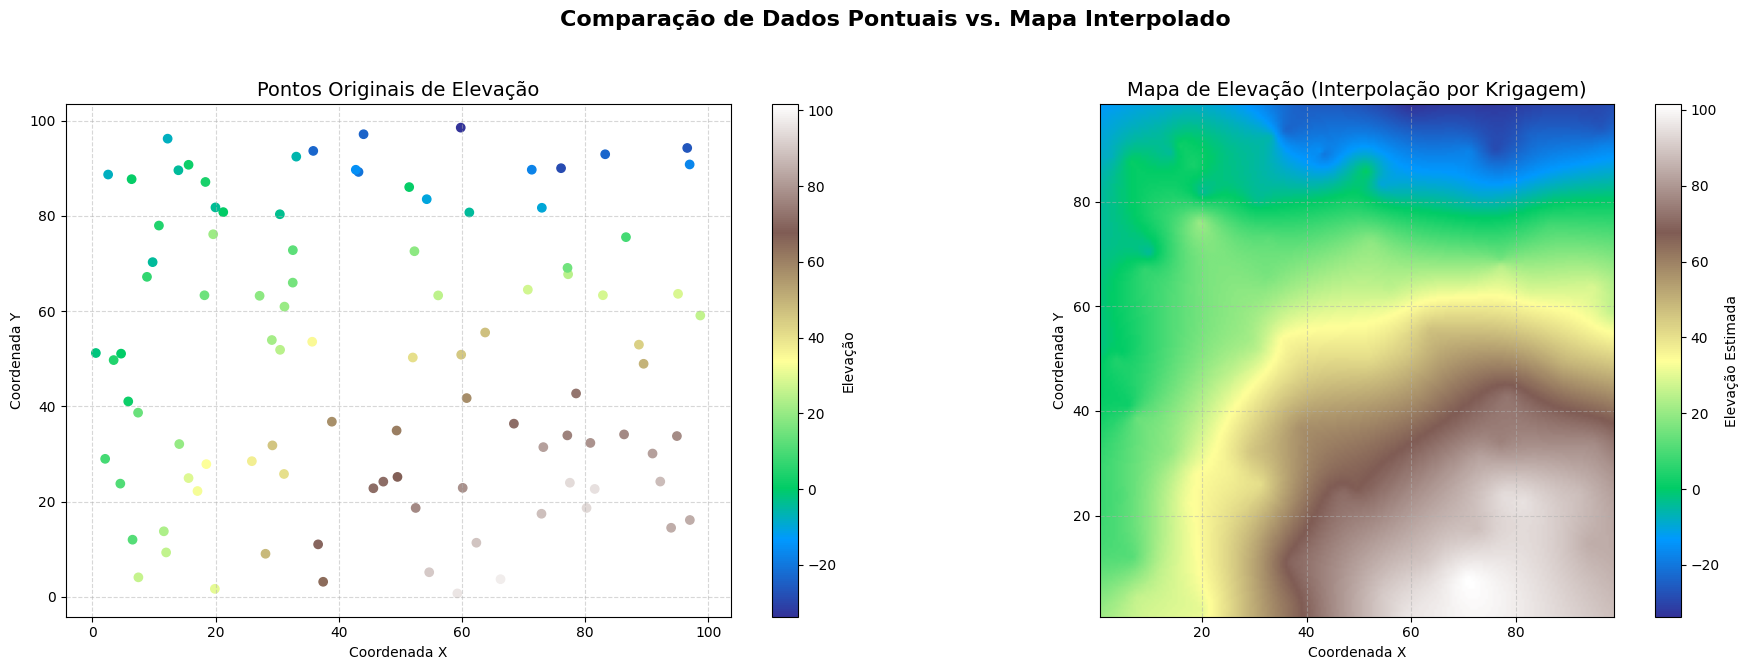

In [15]:

!pip install cartopy pygis pykrige
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pykrige.ok import OrdinaryKriging

# --- SEÇÃO 1: DADOS DE AMOSTRA (SUBSTITUA PELOS SEUS DADOS) ---
# Estou criando um DataFrame de exemplo com pontos aleatórios.
# Em um caso real, você carregaria seus dados aqui. Ex:
# df = pd.read_csv('seus_dados.csv')

print("Gerando dados de amostra...")
# Gerando 100 pontos aleatórios
np.random.seed(42)
x_coords = np.random.rand(100) * 100
y_coords = np.random.rand(100) * 100
# Criando uma elevação baseada em uma função + ruído aleatório
elev_values = (np.sin(x_coords / 50) * np.cos(y_coords / 50)) * 100 + np.random.normal(0, 5, 100)

df = pd.DataFrame({
    'x': x_coords,
    'y': y_coords,
    'elev': elev_values
})
print("Dados de amostra criados com sucesso.")
# --- FIM DA SEÇÃO DE DADOS DE AMOSTRA ---


# --- SEÇÃO 2: PREPARAÇÃO PARA A KRIGAGEM ---
# Extraia os dados do DataFrame para arrays numpy
x = df['x'].values
y = df['y'].values
elev = df['elev'].values

# Defina a grade (grid) onde a interpolação será calculada.
# A resolução da grade (ex: 200x200) determina o detalhe do mapa final.
grid_resolution_x = 200
grid_resolution_y = 200
grid_x = np.linspace(x.min(), x.max(), grid_resolution_x)
grid_y = np.linspace(y.min(), y.max(), grid_resolution_y)

print("\nIniciando o processo de krigagem...")

# --- SEÇÃO 3: EXECUÇÃO DA KRIGAGEM ORDINÁRIA ---
# Instancia o objeto de krigagem.
# O 'variogram_model' é um parâmetro importante. 'linear' é um bom começo,
# mas outros como 'gaussian', 'spherical' ou 'exponential' podem dar melhores resultados
# dependendo da distribuição espacial dos seus dados.
OK = OrdinaryKriging(
    x,
    y,
    elev,
    variogram_model='linear',
    verbose=False,
    enable_plotting=False
)

# Executa a krigagem na grade definida.
# 'z' será a matriz com os valores de elevação interpolados.
# 'ss' será a matriz com a variância (uma medida de incerteza da estimativa).
z, ss = OK.execute('grid', grid_x, grid_y)
print("Krigagem concluída.")


# --- SEÇÃO 4: VISUALIZAÇÃO DOS RESULTADOS ---
print("Gerando o mapa...")

fig, ax = plt.subplots(1, 2, figsize=(18, 7))

# Gráfico 1: Pontos originais
scatter = ax[0].scatter(x, y, c=elev, cmap='terrain')
ax[0].set_title('Pontos Originais de Elevação', fontsize=14)
ax[0].set_xlabel('Coordenada X')
ax[0].set_ylabel('Coordenada Y')
ax[0].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(scatter, ax=ax[0], label='Elevação')

# Gráfico 2: Mapa interpolado por krigagem
im = ax[1].imshow(z, origin='lower', extent=(x.min(), x.max(), y.min(), y.max()), cmap='terrain')
ax[1].set_title('Mapa de Elevação (Interpolação por Krigagem)', fontsize=14)
ax[1].set_xlabel('Coordenada X')
ax[1].set_ylabel('Coordenada Y')
ax[1].grid(True, linestyle='--', alpha=0.5)
fig.colorbar(im, ax=ax[1], label='Elevação Estimada')

plt.suptitle('Comparação de Dados Pontuais vs. Mapa Interpolado', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

✅ Data espectral limpa (df_cleaned) e labels (lulc_labels) encontrados.
✅ Número de linhas nos dados espectrais e labels corresponde.
Shape após remover linhas com labels -1: (59883, 247)

📊 Calculando estatísticas de variabilidade espectral por classe...
✅ Estatísticas calculadas.

📈 Visualizando variabilidade espectral para cada classe...


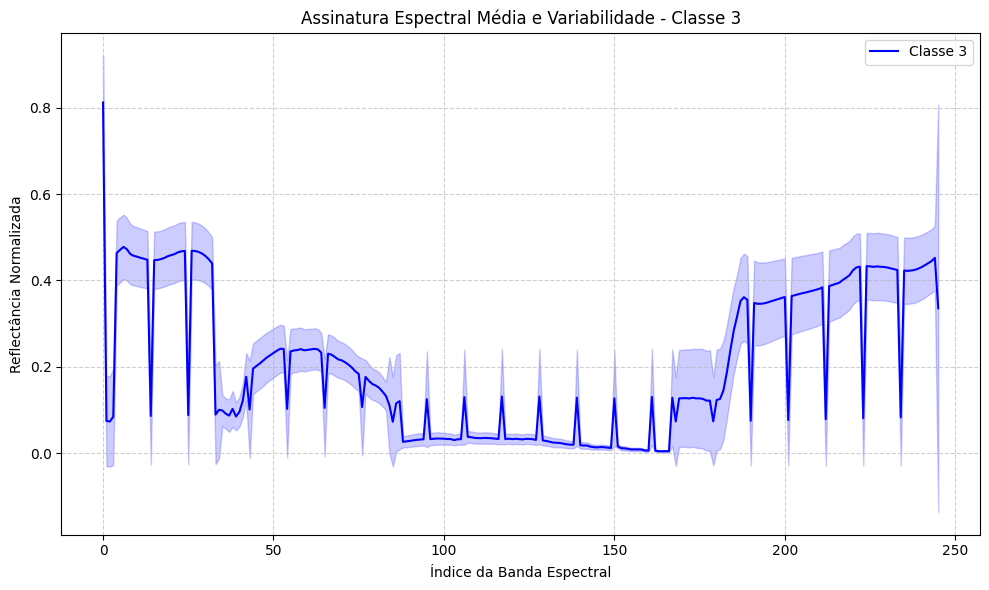

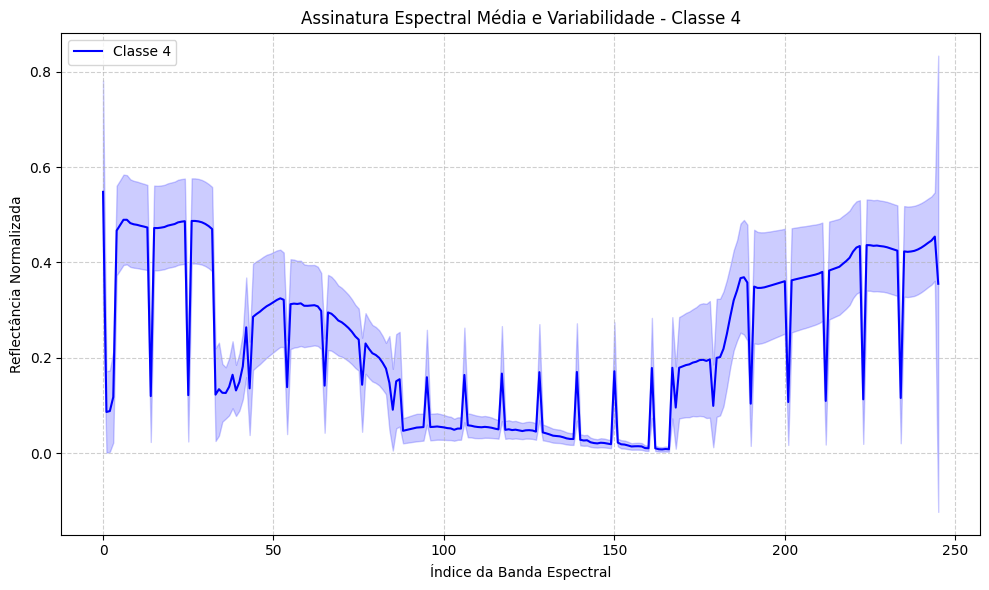

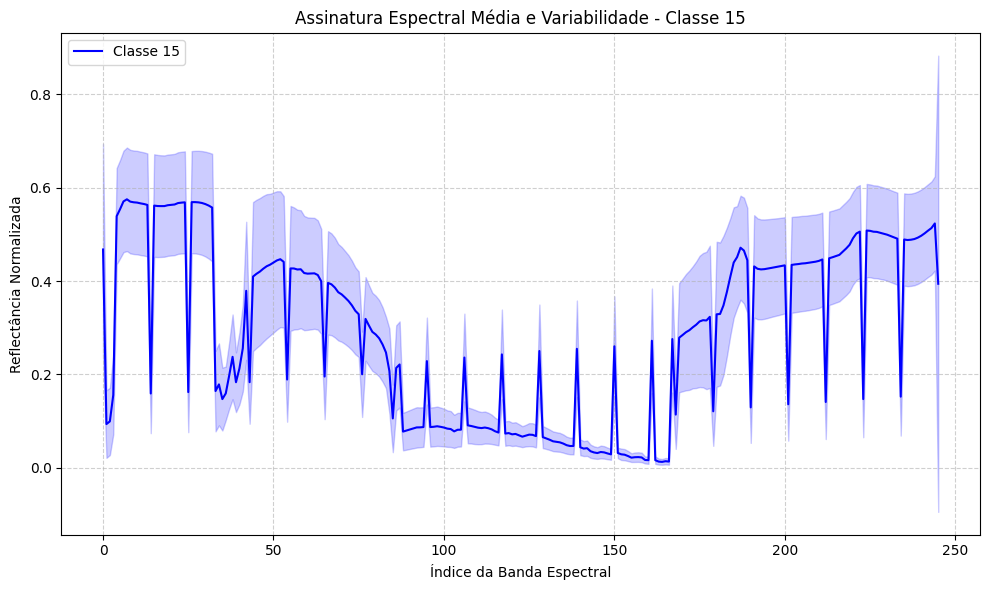

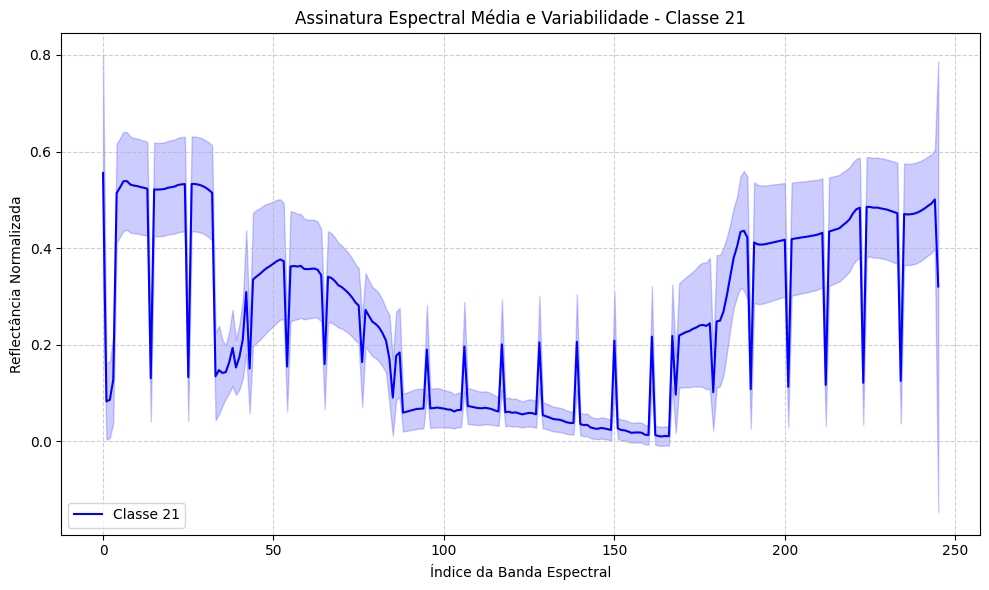

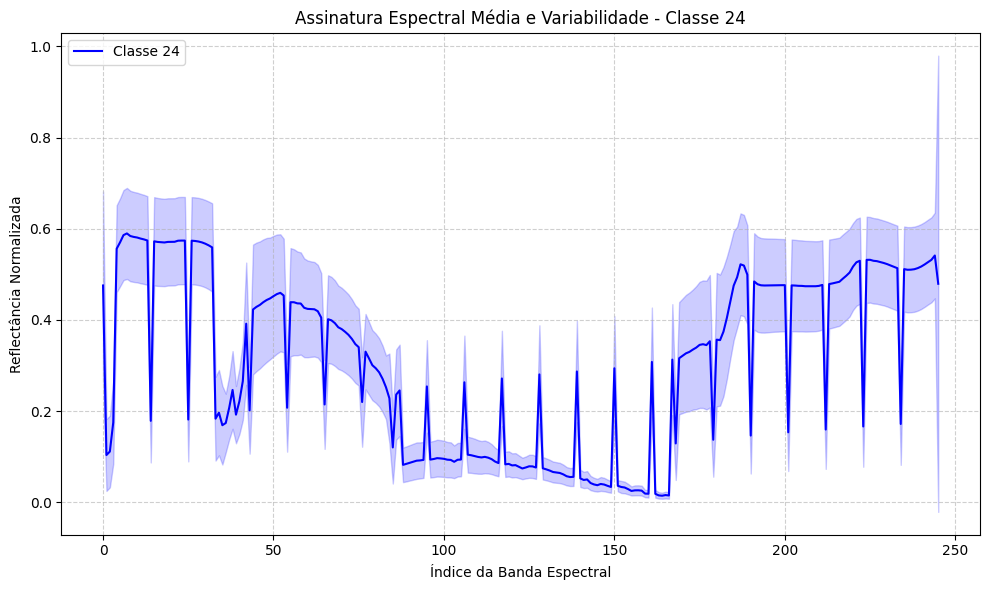

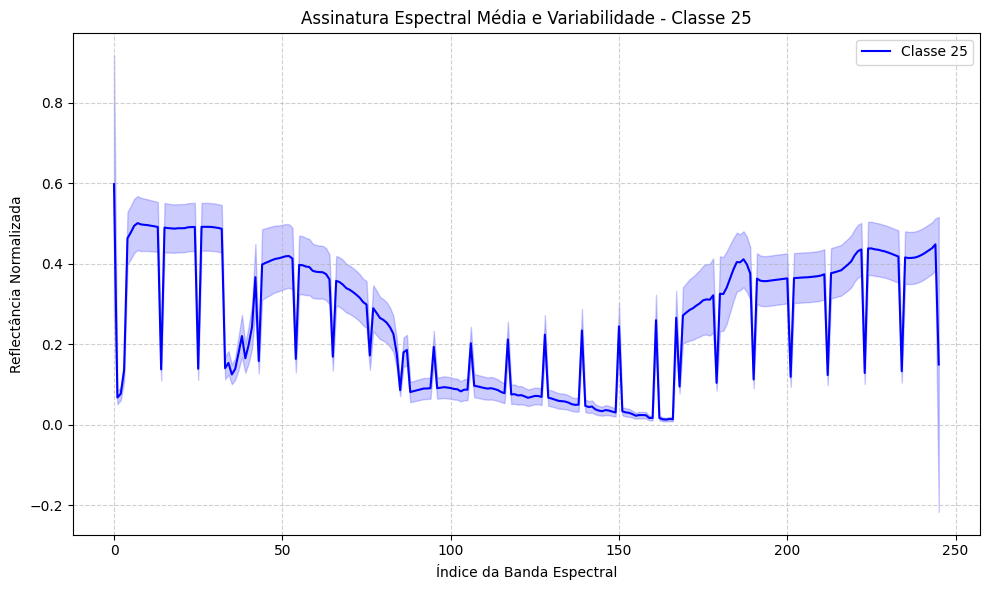

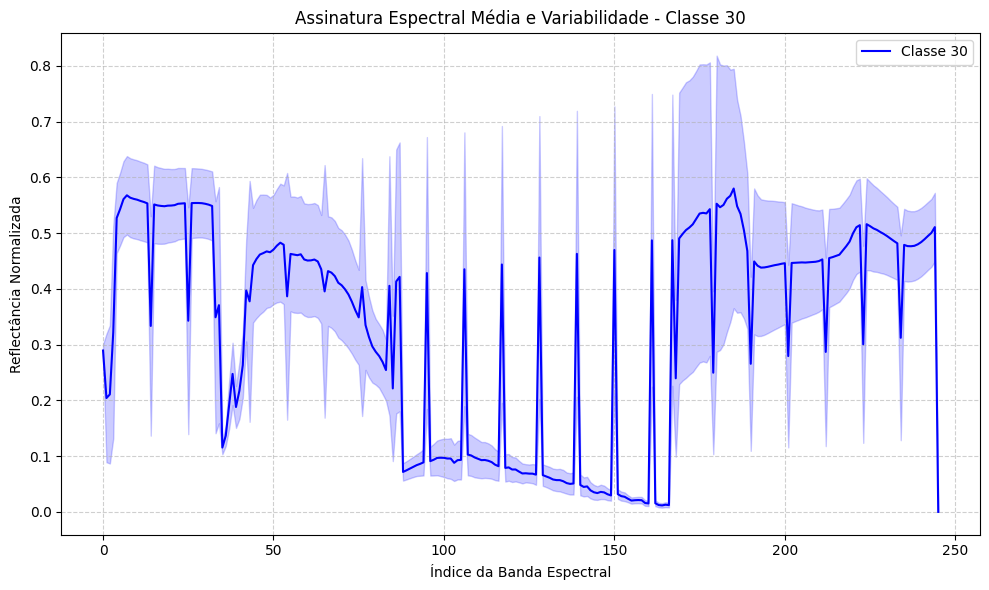

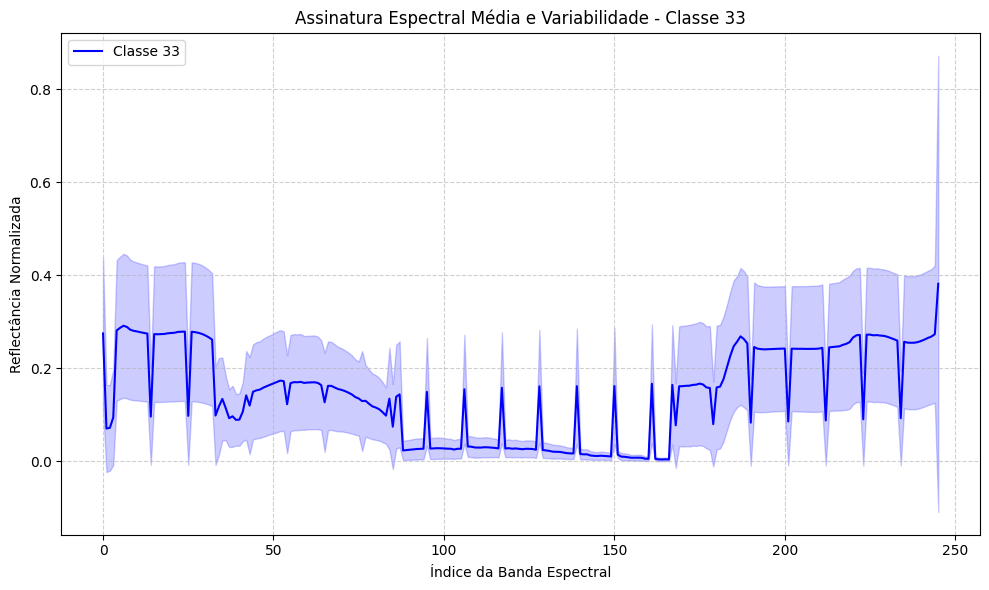

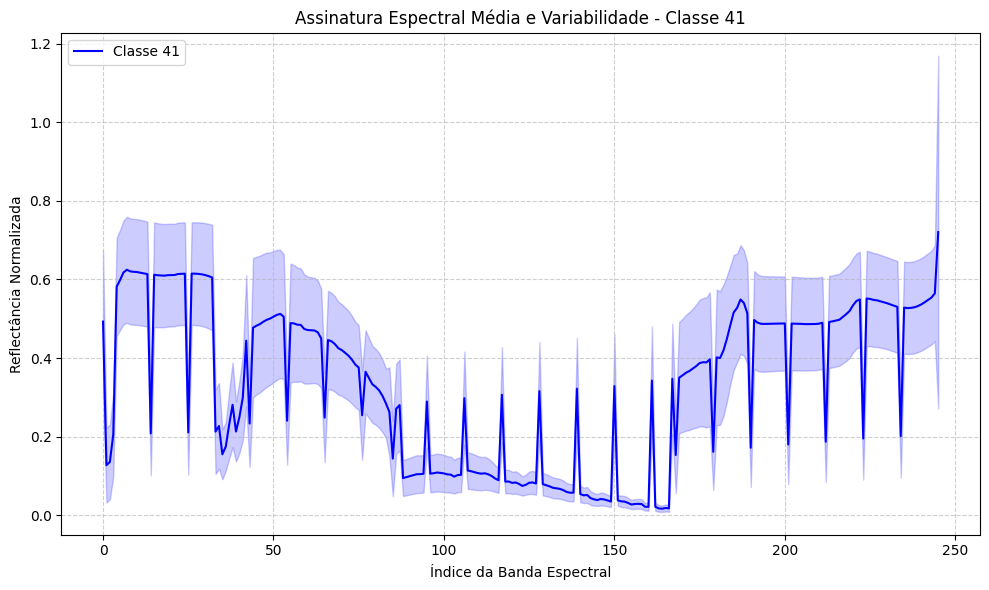

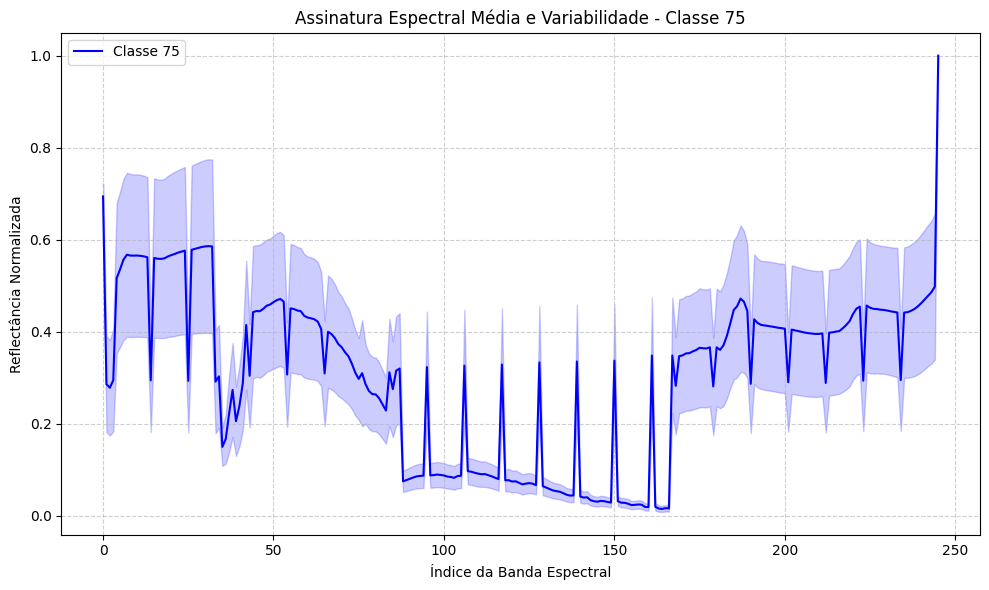

✅ Visualização de assinaturas espectrais por classe concluída.

🔎 Analisando janelas espectrais para diferenciação entre classes...

🏆 Top 20 índices de banda com maior diferença espectral média entre classes:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]
✅ Análise de janelas espectrais concluída.


In [16]:
 # --- 2. Análise Estatística e Visualização da Variabilidade INTRA CLASSES ---
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure df_cleaned (spectral data) and lulc_labels (labels) are available from previous steps
if 'df_cleaned' in globals() and df_cleaned is not None and not df_cleaned.empty and \
   'lulc_labels' in globals() and lulc_labels is not None:

    print("✅ Data espectral limpa (df_cleaned) e labels (lulc_labels) encontrados.")

    # Ensure the number of rows in spectral data and labels match after cleaning
    if df_cleaned.shape[0] == lulc_labels.shape[0]:
        print("✅ Número de linhas nos dados espectrais e labels corresponde.")

        # Combine spectral data and labels into a single DataFrame for easier grouping
        # Reset index to ensure alignment if indices were modified during cleaning
        df_spectral_with_labels = df_cleaned.reset_index(drop=True).copy()
        df_spectral_with_labels['lulc_mapbiomas'] = lulc_labels.reset_index(drop=True)

        # Remove rows where lulc_mapbiomas is -1 (assigned to original NaNs) if they exist
        df_spectral_with_labels = df_spectral_with_labels[df_spectral_with_labels['lulc_mapbiomas'] != -1].copy()
        print(f"Shape após remover linhas com labels -1: {df_spectral_with_labels.shape}")

        if not df_spectral_with_labels.empty:

            # Group data by lulc_mapbiomas class
            grouped_classes = df_spectral_with_labels.groupby('lulc_mapbiomas')

            print("\n📊 Calculando estatísticas de variabilidade espectral por classe...")

            # Calculate mean and standard deviation for each spectral band within each class
            mean_spectra = grouped_classes[df_cleaned.columns].mean()
            std_spectra = grouped_classes[df_cleaned.columns].std()

            print("✅ Estatísticas calculadas.")

            # --- Visualização da Variabilidade Intra-Classe (Gráficos Individuais) ---

            print("\n📈 Visualizando variabilidade espectral para cada classe...")

            band_indices = np.arange(mean_spectra.shape[1]) # Band indices for x-axis

            # Plot the mean spectrum for each class with shaded area for standard deviation in separate subplots
            for class_id, mean_spec in mean_spectra.iterrows():
                if class_id != -1: # Skip plotting for -1 label if it was kept
                    plt.figure(figsize=(10, 6)) # Create a new figure for each class
                    std_spec = std_spectra.loc[class_id]
                    plt.plot(band_indices, mean_spec, label=f'Classe {class_id}', color='blue')
                    # Shade the area representing +/- 1 standard deviation
                    plt.fill_between(band_indices, mean_spec - std_spec, mean_spec + std_spec, color='blue', alpha=0.2)

                    plt.title(f'Assinatura Espectral Média e Variabilidade - Classe {class_id}')
                    plt.xlabel('Índice da Banda Espectral')
                    plt.ylabel('Reflectância Normalizada')
                    plt.legend()
                    plt.grid(True, linestyle='--', alpha=0.6)
                    plt.tight_layout()
                    plt.show()

            print("✅ Visualização de assinaturas espectrais por classe concluída.")

            # --- Análise para Identificar Janelas Espectrais de Diferenciação ---

            print("\n🔎 Analisando janelas espectrais para diferenciação entre classes...")

            # To identify spectral windows for differentiation, we can look for bands
            # where the mean spectra of different classes are most separated relative to their
            # intra-class variability (standard deviation).
            # A simple approach is to calculate the difference between mean spectra for all pairs of classes
            # and compare it to the sum of their standard deviations.
            # Bands with high mean difference and relatively low standard deviations are good candidates.

            # Let's calculate the mean difference between all pairs of classes for each band
            class_ids = [c for c in mean_spectra.index if c != -1]
            num_classes = len(class_ids)
            mean_differences = pd.DataFrame(index=band_indices, columns=pd.MultiIndex.from_product([class_ids, class_ids]), dtype=float)

            for i in range(num_classes):
                for j in range(num_classes):
                    class1_id = class_ids[i]
                    class2_id = class_ids[j]
                    if class1_id != class2_id:
                        mean_diff = np.abs(mean_spectra.loc[class1_id] - mean_spectra.loc[class2_id])
                        mean_differences[(class1_id, class2_id)] = mean_diff

            # Let's focus on bands with high average mean difference across all pairs
            average_mean_difference = mean_differences.mean(axis=1)
            # We could also consider bands where the difference between means is much larger
            # than the sum of standard deviations for pairs of classes.

            # For simplicity, let's just identify bands with the highest average mean difference
            # across all class pairs.
            top_n_bands = 20 # Number of top bands to identify
            top_bands_indices = average_mean_difference.nlargest(top_n_bands).index.tolist()

            print(f"\n🏆 Top {top_n_bands} índices de banda com maior diferença espectral média entre classes:")
            print(top_bands_indices)

            # Interpretation: These band indices represent potential spectral windows
            # where the different LULC classes show the most distinct reflectance values
            # on average, making them useful for classification/differentiation.

            print("✅ Análise de janelas espectrais concluída.")


        else:
            print("⚠️ DataFrame combinado (espectral + labels) está vazio após remover labels -1. Não é possível realizar a análise intra-classe.")


    else:
        print("❌ O número de linhas nos dados espectrais e labels não corresponde após o pré-processamento. Não é possível realizar a análise intra-classe.")

else:
    print("❌ Data espectral limpa (df_cleaned) ou labels (lulc_labels) não encontrados. Por favor, execute as células de pré-processamento primeiro.")

In [17]:
# ==============================================================================
# Seção 1: Carregamento e Pré-processamento dos Dados Hiperespectrais
# ==============================================================================
# COMENTÁRIO CIENTÍFICO:
# Esta seção descreve o processo de carregamento e pré-processamento dos dados
# hiperespectrais, que é a etapa inicial para qualquer análise subsequente,
# como o unmixing. Os dados, provenientes da exportação do Google Earth Engine (GEE),
# são consolidados a partir de múltiplos arquivos CSV. Um pré-processamento
# rigoroso é essencial para garantir a qualidade dos dados de entrada, removendo
# valores inválidos (NaNs) e selecionando apenas as bandas espectrais relevantes.
# A normalização dos dados para um intervalo comum (ex: [0, 1]) é crucial para
# algoritmos que são sensíveis à escala, como redes neurais e métodos baseados
# em distância. A remoção de colunas com alta porcentagem de valores negativos
# e linhas com muitos NaNs visa mitigar problemas de qualidade de dados na fonte.
# ==============================================================================

import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import skfuzzy as fuzz
from sklearn.metrics import calinski_harabasz_score, mean_squared_error
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.decomposition import PCA
from scipy.optimize import linear_sum_assignment # Needed for Hungarian algorithm

# Install skfuzzy if not already installed
!pip install -q scikit-fuzzy

# Montar o Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Caminho para a pasta no Google Drive que contém os arquivos CSV
# ATENÇÃO: Substitua pelo caminho correto da sua pasta no Google Drive
caminho_da_pasta = "/content/drive/MyDrive/1/"

print(f"📂 Tentando carregar e combinar arquivos da pasta: {caminho_da_pasta}")

lista_dataframes = []
arquivos_csv = []

# Verifica se o diretório existe antes de listar os arquivos
if os.path.exists(caminho_da_pasta):
    arquivos_csv = [f for f in os.listdir(caminho_da_pasta) if f.endswith('.csv')]
    if not arquivos_csv:
        print("❌ Nenhum arquivo CSV encontrado na pasta.")
    else:
        print(f"📊 Encontrados {len(arquivos_csv)} arquivos CSV para combinar.")
        for arquivo in arquivos_csv:
            caminho_completo_arquivo = os.path.join(caminho_da_pasta, arquivo)
            try:
                # Tenta carregar o CSV, lidando com possíveis erros de parsing
                df_temp = pd.read_csv(caminho_completo_arquivo, low_memory=False)
                lista_dataframes.append(df_temp)
                print(f"   ✅ Carregado: {arquivo} ({len(df_temp)} linhas)")
            except Exception as e:
                print(f"   ❌ Erro ao carregar {arquivo}: {str(e)}")

else:
    print(f"❌ Erro: O caminho da pasta '{caminho_da_pasta}' não foi encontrado ou definido corretamente.")

df_cleaned = None
lulc_labels = None
spectral_data_prepared_2d = None
spectral_data_prepared_3d = None
IMG_SIZE = 0
N_BANDS = 0
N_PIXELS = 0 # Keep track of the total number of pixels


if lista_dataframes:
    # Concatenar todos os DataFrames
    df_raw = pd.concat(lista_dataframes, ignore_index=True)
    print(f"\n✅ DataFrames combinados com sucesso. Shape inicial: {df_raw.shape}")

    # --- Etapas de Limpeza e Pré-processamento ---

    # 1. Remover colunas com mais de 10% de valores negativos (apenas para colunas numéricas)
    print("\nRemovendo colunas com mais de 10% de valores negativos...")
    df_numeric_for_negative_check = df_raw.select_dtypes(include=np.number)
    negative_percentage_per_column = (df_numeric_for_negative_check < 0).sum() / len(df_numeric_for_negative_check)
    cols_to_drop_negative = negative_percentage_per_column[negative_percentage_per_column > 0.1].index.tolist()
    df_processed_cols = df_raw.drop(columns=cols_to_drop_negative, errors='ignore')
    print(f"Colunas removidas devido a valores negativos (>10%): {cols_to_drop_negative}")
    print(f"Shape após remover colunas com muitos negativos: {df_processed_cols.shape}")

    # 2. Remover linhas com mais de 10% NaN values (após remover colunas negativas)
    print("\nRemovendo linhas com mais de 10% de valores NaN (após remover colunas negativas)...")
    nan_percentage_per_row = df_processed_cols.isnull().sum(axis=1) / df_processed_cols.shape[1]
    df_processed_rows = df_processed_cols[nan_percentage_per_row <= 0.1].copy()
    print(f"Shape após remover linhas com mais de 10% NaN: {df_processed_rows.shape}")
    print(f"Número de linhas removidas: {df_processed_cols.shape[0] - df_processed_rows.shape[0]}")
    df_processed = df_processed_rows # Use este como o DataFrame principal processado
    print(f"Debug: Shape of df_processed after row removal: {df_processed.shape}")


    # 3. Remover colunas não-espectrais específicas, exceto 'lulc_mapbiomas'
    cols_to_drop_explicit = ['system:index', 'NDLI', 'day', 'month', '.geo', 'EVI', 'NDRE', 'NDWI', 'elev'] # Adicionado mais colunas não espectrais
    existing_cols_to_drop_explicit = [col for col in cols_to_drop_explicit if col in df_processed.columns]
    df_processed = df_processed.drop(columns=existing_cols_to_drop_explicit, errors='ignore')
    print(f"Colunas removidas explicitamente (excluindo lulc_mapbiomas): {existing_cols_to_drop_explicit}")
    print(f"Shape após remover colunas explícitas: {df_processed.shape}")
    print(f"Debug: Shape of df_processed after explicit col removal: {df_processed.shape}")


    # 4. Extrair coluna 'lulc_mapbiomas' como labels, se existir
    if 'lulc_mapbiomas' in df_processed.columns:
        print("\n✅ Coluna 'lulc_mapbiomas' encontrada. Extraindo como labels.")
        lulc_labels = df_processed['lulc_mapbiomas'].copy()
        lulc_labels = pd.to_numeric(lulc_labels, errors='coerce').fillna(-1).astype(int)
        df_processed = df_processed.drop(columns=['lulc_mapbiomas'], errors='ignore')
        print(f"Shape dos labels (lulc_mapbiomas): {lulc_labels.shape}")
    else:
        print("\n⚠️ Coluna 'lulc_mapbiomas' não encontrada no DataFrame processado. Labels não extraídos.")
        lulc_labels = None
    print(f"Debug: Shape of df_processed after lulc_mapbiomas removal: {df_processed.shape}")


    # 5. Identificar colunas espectrais restantes (assumindo numéricas e não removidas)
    spectral_cols = df_processed.select_dtypes(include=np.number).columns.tolist()
    print(f"Debug: Number of potential spectral columns after removal: {len(spectral_cols)}")


    if not spectral_cols:
        print("❌ Nenhuma coluna espectral identificada após pré-processamento. Não é possível prosseguir.")
        df_cleaned = None
        spectral_data_prepared_2d = None
        spectral_data_prepared_3d = None
    else:
        print(f"✅ Colunas espectrais identificadas: {spectral_cols}")
        df_cleaned = df_processed[spectral_cols].copy()

        # Ensure data is numeric and handle any remaining NaNs
        for col in df_cleaned.columns:
            df_cleaned[col] = pd.to_numeric(df_cleaned[col], errors='coerce')
        df_cleaned = df_cleaned.dropna(axis=1, how='all') # Drop columns that became all NaN

        # Impute any remaining NaNs *before* normalization
        if df_cleaned is not None and df_cleaned.isnull().values.any():
             print("⚠️ Valores NaN encontrados nas colunas espectrais após seleção. Imputando com a média das colunas.")
             df_cleaned = df_cleaned.fillna(df_cleaned.mean())
             df_cleaned = df_cleaned.fillna(0) # Final fill for any mean NaNs

        print(f"Shape após limpeza e seleção das colunas espectrais: {df_cleaned.shape}")
        print(f"Debug: Shape of df_cleaned before converting to numpy: {df_cleaned.shape}")


        # Converter para array numpy 2D
        spectral_data_2d = df_cleaned.values
        N_PIXELS = spectral_data_2d.shape[0]
        print(f"Dados espectrais convertidos para NumPy array 2D: {spectral_data_2d.shape}")
        N_BANDS = spectral_data_2d.shape[1] if N_PIXELS > 0 else 0
        print(f"Debug: N_PIXELS after converting to numpy: {N_PIXELS}")
        print(f"Debug: N_BANDS after converting to numpy: {N_BANDS}")


        # Normalizar dados espectrais para [0, 1]
        if N_PIXELS > 0 and N_BANDS > 0:
            print("\nNormalizando dados espectrais para o intervalo [0, 1]...")
            scaler = MinMaxScaler()
            spectral_data_prepared_2d = pd.DataFrame(scaler.fit_transform(df_cleaned), columns=df_cleaned.columns).values # Use df_cleaned for normalization
            print(f"✅ Dados espectrais normalizados. Min: {np.min(spectral_data_prepared_2d):.4f}, Max: {np.max(spectral_data_prepared_2d):.4f}")
        else:
             print("\n⚠️ Dados espectrais vazios ou sem bandas. Pulando normalização.")
             spectral_data_prepared_2d = spectral_data_2d # Keep original if empty


        # Remover todos os valores negativos (clipando para 0)
        if spectral_data_prepared_2d is not None and N_PIXELS > 0:
            print("\nRemovendo todos os valores negativos (clipando para 0)...")
            spectral_data_prepared_2d = np.clip(spectral_data_prepared_2d, 0, None)
            print(f"✅ Valores negativos removidos. Min agora: {np.min(spectral_data_prepared_2d):.4f}")

        # Tentativa de reconstruir para 3D se o número de pixels indicar uma imagem quadrada
        inferred_img_size = int(np.sqrt(N_PIXELS))

        if inferred_img_size * inferred_img_size == N_PIXELS:
             IMG_SIZE = inferred_img_size
             spectral_data_prepared_3d = spectral_data_prepared_2d.reshape(IMG_SIZE, IMG_SIZE, N_BANDS)
             print(f"Dados espectrais reconstruídos para 3D (imagem): {spectral_data_prepared_3d.shape}")
        else:
             print(f"⚠️ Aviso: Número de pixels ({N_PIXELS}) não permite reconstrução em imagem quadrada. CNN-AE (patch-based) operará em 2D/pixel-based.")
             spectral_data_prepared_3d = None
             IMG_SIZE = 0 # Reset IMG_SIZE if 3D reconstruction is not possible
        print(f"Debug: IMG_SIZE after 3D check: {IMG_SIZE}")


    # --- Exibir as primeiras linhas dos dados processados ---
    if df_cleaned is not None and not df_cleaned.empty:
        print("\nPrimeiras 5 linhas dos dados espectrais limpos e pré-processados:")
        display(df_cleaned.head())
    else:
        print("\nDataFrame de dados espectrais está vazio após limpeza e pré-processamento.")

else:
    print("\n❌ Não foi possível carregar ou combinar DataFrames. Pulando pré-processamento.")
    spectral_data_prepared_2d = None
    spectral_data_prepared_3d = None
    IMG_SIZE = 0
    N_BANDS = 0
    N_PIXELS = 0


#@title # 3. Definição da Metodologia (Adaptada para Dados Reais)
#==============================================================================
# Esta seção contém as implementações dos módulos principais, adaptadas
# para trabalhar com os dados reais carregados.
#==============================================================================

#------------------------------------------------------------------------------
# MÓDULO 1: AUTOENCODER (Adaptado para Dados Reais)
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# O Autoencoder CNN é aplicado aos dados reais. Se a reconstrução 3D foi possível,
# ele opera em patches espaciais. Se não, ele opera em pixels individuais
# (equivalente a patches 1x1), focando puramente na descompressão espectral.
# A perda SAD continua relevante para a similaridade espectral.
#------------------------------------------------------------------------------
def sad_loss(y_true, y_pred):
    """
    Implementação da perda Spectral Angle Distance (SAD) para o Keras/TensorFlow.
    """
    epsilon = tf.keras.backend.epsilon()
    y_true_norm = tf.linalg.normalize(y_true, axis=-1)[0]
    y_pred_norm = tf.linalg.normalize(y_pred, axis=-1)[0]
    dot_product = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)
    dot_product = tf.clip_by_value(dot_product, -1.0 + epsilon, 1.0 - epsilon)
    sad = tf.acos(dot_product)
    return tf.reduce_mean(sad)

def build_autoencoder_module(input_shape, L, R):
    """
    Constrói o módulo Autoencoder CNN.
    input_shape: Shape dos dados de entrada (PATCH_SIZE, PATCH_SIZE, N_BANDS) ou (1, 1, N_BANDS) para 2D.
    L: Número de filtros na primeira camada do encoder.
    R: Número superestimado de endmembers.
    """
    # Determine the spatial dimensions from input_shape
    if len(input_shape) == 3:
        PATCH_H, PATCH_W, B = input_shape
    elif len(input_shape) == 2: # Handle 2D input (pixels, bands)
         # We will treat each pixel as a 1x1 patch
         PATCH_H, PATCH_W = 1, 1
         B = input_shape[-1]
         # Adjust input shape for the model to be (1, 1, B)
         input_shape = (PATCH_H, PATCH_W, B)
    else:
        raise ValueError(f"Input shape {input_shape} not supported. Expected 2D or 3D.")


    input_layer = keras.Input(shape=input_shape)

    # --- Encoder ---
    # Use 1x1 convolutions which work on both spatial patches and individual pixels
    x = layers.Conv2D(L, (1, 1), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(R, (1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    overestimated_abundances = layers.Softmax(name='encoder_output')(x)

    # --- Decoder ---
    reconstructed_output = layers.Conv2D(B, (1, 1), name='decoder_conv')(overestimated_abundances)

    autoencoder = keras.Model(inputs=input_layer, outputs=reconstructed_output)
    encoder = keras.Model(inputs=input_layer, outputs=overestimated_abundances)

    return autoencoder, encoder


#------------------------------------------------------------------------------
# MÓDULO 2: AUTO-APRENDIZAGEM
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# O clustering Fuzzy C-Means é aplicado aos endmembers superestimados (E_hat)
# para estimar o número real de endmembers (M) nos dados reais.
#------------------------------------------------------------------------------
def run_self_learning_module(E_hat, R_overestimated, N_bands, max_endmembers=20):
    """
    Executa o módulo de auto-aprendizagem para encontrar o número real de endmembers M.
    Utiliza Fuzzy C-Means e o Calinski-Harabasz Score para validação.
    E_hat: Endmembers superestimados (R_overestimated x N_bands)
    R_overestimated: The number of overestimated endmembers (R)
    N_bands: The number of spectral bands (B)
    max_endmembers: O número máximo de endmembers a serem testados pelo clustering.
                    Idealmente, deve ser <= R.
    Returns: learned_E (M x N_bands), U (R_overestimated x M), learned_M (int)
    """
    print("\nIniciando Módulo de Auto-Aprendizagem...")
    print(f"Debug: E_hat shape received: {E_hat.shape}")
    print(f"Debug: R_overestimated: {R_overestimated}, N_bands: {N_bands}")

    scores = []
    # E_hat has shape (R, B)
    n_samples = E_hat.shape[0] # Number of samples for clustering (R_overestimated)
    n_features = E_hat.shape[1] # Number of features for clustering (N_bands)

    if n_samples != R_overestimated or n_features != N_bands:
        print(f"Erro: E_hat shape mismatch. Expected ({R_overestimated}, {N_bands}), got {E_hat.shape}. Cannot perform clustering.")
        return np.array([]), np.array([]), 0

    # Ensure possible_M is within a reasonable range, e.g., from 2 up to min(R, max_endmembers)
    # Also ensure max_endmembers is at least 2 for clustering to be meaningful
    max_m_test = min(n_samples, max_endmembers)
    if max_m_test < 2:
        print(f"AVISO: Número máximo de endmembers a testar ({max_m_test}) é menor que 2. Não é possível realizar clustering.")
        if R_overestimated >= 1:
             print(f"Definindo M como o número superestimado R={R_overestimated}.")
             dummy_U = np.eye(R_overestimated) # Shape (R, R)
             return E_hat, dummy_U, R_overestimated
        else:
             return np.array([]), np.array([]), 0


    possible_M = list(range(2, max_m_test + 1))
    print(f"Debug: Possible M values for clustering: {possible_M}")

    for m_test in possible_M:
        # skfuzzy expects data in the form (features, n_samples)
        # E_hat is (R, B), data_for_fcm should be (B, R)
        data_for_fcm = E_hat.T # Shape (B, R)
        # print(f"Debug: data_for_fcm shape for m_test={m_test}: {data_for_fcm.shape}") # Debug print
        try:
            # Explicitly pass arguments by name to avoid the TypeError
            cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
                data=data_for_fcm, c=m_test, m=2, error=0.005, maxiter=1000, init=None, seed=42
            )
            # u has shape (c, n_samples) -> (m_test, R_overestimated)
            # print(f"Debug: u shape from cmeans for m_test={m_test}: {u.shape}") # Debug print
            labels = np.argmax(u, axis=0) # labels has shape (R_overestimated,)
            if len(np.unique(labels)) > 1:
                 score = calinski_harabasz_score(E_hat, labels) # E_hat (R, B), labels (R,) - Correct
                 scores.append(score)
            else:
                 scores.append(0)
        except Exception as e:
            print(f"Erro durante FCM para m_test={m_test}: {e}")
            scores.append(0)


    if max(scores) == 0:
         print("AVISO: Todos os Calinski-Harabasz scores foram 0. Não foi possível determinar M ótimo via score.")
         if possible_M:
             best_M = possible_M[0]
             print(f"Definindo M como o menor valor testado: {best_M}")
         else:
             best_M = max(1, n_samples)
             print(f"Definindo M como {best_M} (fallback).")
    else:
        best_M = possible_M[np.argmax(scores)]
        print(f"Número ótimo de endmembers estimado (M): {best_M}")


    data_for_fcm = E_hat.T # Shape (B, R)
    final_m = max(1, best_M)
    if final_m > data_for_fcm.shape[1]: # data_for_fcm.shape[1] is R
        print(f"AVISO: O melhor M ({best_M}) é maior que R ({R_overestimated}). Ajustando M para R.")
        final_m = R_overestimated
        if final_m == 0:
             return np.array([]), np.array([]), 0

    # Rerun FCM with the determined best_M
    try:
        print(f"Debug: Final cmeans call - data_for_fcm shape: {data_for_fcm.shape}, c (clusters): {final_m}")
        centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data=data_for_fcm, c=final_m, m=2, error=0.005, maxiter=1000, init=None, seed=42
        )
        # centers has shape (M, B)
        # u has shape (M, R)
        print(f"Debug: u shape from final cmeans: {u.shape}")
        final_membership_matrix_U = u.T # Transpose u to get shape (R, M)
        print(f"Debug: final_membership_matrix_U shape: {final_membership_matrix_U.shape}")
        final_endmembers = centers # centers has shape (M, N_bands)
        print(f"Debug: centers shape from final cmeans: {centers.shape}")
    except Exception as e:
         print(f"Erro final durante FCM para M={final_m}: {e}")
         print("Falha ao rodar FCM final. Retornando E_hat e matriz de pertinência de identidade (se possível).")
         if R_overestimated >= final_m and final_m > 0:
             dummy_U = np.zeros((R_overestimated, final_m)) # Shape (R, M)
             for i in range(min(R_overestimated, final_m)):
                 dummy_U[i, i] = 1.0
             return E_hat, dummy_U, final_m
         else:
             return np.array([]), np.array([]), 0


    return final_endmembers, final_membership_matrix_U, best_M


#------------------------------------------------------------------------------
# MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# Este módulo calcula as abundâncias finais (P) a partir das abundâncias
# superestimadas (P_hat) e da matriz de pertinência (U) obtida do clustering.
#------------------------------------------------------------------------------
def run_abundance_estimation_module(P_hat, U, R_overestimated, M_learned):
    """
    Estima as frações de abundância finais P.
    P_hat: Abundâncias superestimadas (N_pixels x R_overestimated) or (N x N x R_overestimated)
    U: Matriz de pertinência do clustering (R_overestimated x M_learned)
    R_overestimated: The number of overestimated endmembers (R)
    M_learned: The number of learned endmembers (M)
    Returns: P_final (N_pixels x M_learned) or (N x N x M_learned)
    """
    print("\nIniciando Módulo de Estimação de Abundância...")
    print(f"Debug: P_hat shape received: {P_hat.shape}")
    print(f"Debug: U shape received: {U.shape}")
    print(f"Debug: R_overestimated: {R_overestimated}, M_learned: {M_learned}")

    original_shape = P_hat.shape
    if len(original_shape) == 3:
        N_h, N_w, R_p_hat = original_shape
        N_pixels = N_h * N_w
        P_hat_reshaped = P_hat.reshape(N_pixels, R_p_hat)
    elif len(original_shape) == 2:
        N_pixels, R_p_hat = original_shape
        P_hat_reshaped = P_hat
    else:
        print(f"Erro: P_hat shape {original_shape} not supported. Expected 2D or 3D.")
        return None


    R_U, M_U = U.shape # U should have shape (R_overestimated, M_learned)

    if R_p_hat != R_overestimated:
        print(f"Erro: Mismatch na dimensão R_overestimated. P_hat tem R={R_p_hat}, esperado R_overestimated={R_overestimated}.")
        return None
    if R_U != R_overestimated or M_U != M_learned:
         print(f"Erro: Mismatch na dimensão de U. U tem shape {U.shape}, esperado ({R_overestimated}, {M_learned}).")
         return None
    if M_learned == 0:
         print("Erro: Número de endmembers aprendidos (M) é zero.")
         return None

    # Calcula a matriz V conforme Equação (8) - com correção de typo do artigo
    # V (M x R) é a transposta da matriz de pertinência U (R x M).
    V = U.T # V tem formato (M_learned, R_overestimated)
    print(f"Debug: V shape (U.T): {V.shape}")

    # Calcula a pseudoinversa à direita de V: V' = V^T * (V*V^T)^-1
    # Usamos np.linalg.pinv para maior estabilidade numérica
    # V has shape (M_learned, R_overestimated). pinv(V) has shape (R_overestimated, M_learned).
    V_pseudo_inv = np.linalg.pinv(V) # Formato (R_overestimated, M_learned)
    print(f"Debug: V_pseudo_inv shape (pinv(V)): {V_pseudo_inv.shape}")


    # Calcula as abundâncias finais P = P_hat * V_pseudo_inv
    # Multiplication: (N_pixels, R_overestimated) @ (R_overestimated, M_learned) -> (N_pixels, M_learned)
    print(f"Debug: Attempting multiplication: {P_hat_reshaped.shape} @ {V_pseudo_inv.shape}")
    P_final_reshaped = P_hat_reshaped @ V_pseudo_inv # (N_pixels, M_learned)
    print(f"Debug: P_final_reshaped shape: {P_final_reshaped.shape}")


    # Reformata P de volta para o formato original (2D or 3D)
    if len(original_shape) == 3:
        N_h, N_w, R_p_hat = original_shape # Use original shape to get N_h, N_w
        P_final = P_final_reshaped.reshape(N_h, N_w, M_learned)
    else: # 2D input
        P_final = P_final_reshaped # Shape (N_pixels, M_learned)

    P_final = np.clip(P_final, 0, 1) # Garante não-negatividade

    print("Abundâncias finais estimadas.")
    return P_final

#------------------------------------------------------------------------------
# Implementação do NMF
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# Implementação do NMF para comparação. O NMF requer o número de endmembers
# como entrada. Para dados reais, este número pode ser estimado
# independentemente ou definido com base no conhecimento da área.
# Neste contexto, usaremos um número fixo (e.g., o M estimado pelo CNN-AE
# ou um valor razoável) ou, se comparando com simulação, o TRUE_M.
# Para dados reais, não temos TRUE_M, então usaremos o M estimado pelo CNN-AE.
#------------------------------------------------------------------------------
def run_nmf_unmixing(spectral_data_2d, n_components):
    """
    Executa o unmixing usando Non-negative Matrix Factorization (NMF).
    spectral_data_2d: Dados espectrais no formato (pixels, bands).
    n_components: Número de endmembers a serem extraídos.
    Returns: learned_E_nmf (n_components x bands), learned_A_nmf (pixels x n_components)
    """
    print("\n--- INICIANDO UNMIXING COM NMF ---")
    print(f"Executando NMF com n_components={n_components}")

    if n_components <= 0:
        print("Erro: Número de componentes para NMF deve ser positivo.")
        return np.array([]), np.array([])
    if spectral_data_2d is None or spectral_data_2d.shape[0] == 0:
        print("Erro: Dados espectrais de entrada para NMF são inválidos ou vazios.")
        return np.array([]), np.array([])
    if n_components > spectral_data_2d.shape[0]:
         print(f"AVISO: n_components ({n_components}) é maior que o número de pixels ({spectral_data_2d.shape[0]}). Ajustando n_components para o número de pixels.")
         n_components = spectral_data_2d.shape[0]
         if n_components == 0:
              return np.array([]), np.array([])
    if n_components > spectral_data_2d.shape[1]:
        print(f"AVISO: n_components ({n_components}) é maior que o número de bandas ({spectral_data_2d.shape[1]}). Ajustando n_components para o número de bandas.")
        n_components = spectral_data_2d.shape[1]
        if n_components == 0:
             return np.array([]), np.array([])
    if n_components > min(spectral_data_2d.shape[0], spectral_data_2d.shape[1]):
         # This case should be caught by the previous checks, but as a safeguard
         n_components = min(spectral_data_2d.shape[0], spectral_data_2d.shape[1])
         print(f"AVISO: n_components ajustado para min(pixels, bands): {n_components}")
         if n_components == 0:
              return np.array([]), np.array([])


    try:
        # Instantiate and fit NMF model
        nmf_model = NMF(n_components=n_components, init='random', random_state=42, max_iter=1000) # Increased max_iter
        # Fit_transform returns abundances (W), components_ is endmembers (H)
        learned_A_nmf_reshaped = nmf_model.fit_transform(spectral_data_2d) # Shape (pixels, n_components)
        learned_E_nmf = nmf_model.components_ # Shape (n_components, bands)

        print("Unmixing NMF concluído.")
        return learned_E_nmf, learned_A_nmf_reshaped

    except Exception as e:
        print(f"Erro durante a execução do NMF: {e}")
        return np.array([]), np.array([])


#@title # 4. Execução Completa da Metodologia em Dados Reais
#==============================================================================
# Este bloco orquestra a execução de todos os módulos em sequência,
# utilizando os dados reais carregados e pré-processados.
#==============================================================================

# --- Hiperparâmetros ---
# R e L são hiperparâmetros do Autoencoder CNN
R = 20          # Número SUPERESTIMADO de endmembers para o AE
L = 64          # Filtros na primeira camada do encoder
EPOCHS = 50     # Número de épocas de treinamento do AE
BATCH_SIZE = 16
PATCH_SIZE = 5 # Tamanho do patch espacial de entrada para o CNN (se 3D)

# N_BANDS, IMG_SIZE (se aplicável), e N_PIXELS são definidos pelo dataset carregado
# TRUE_M é desconhecido para dados reais

# Certifica que os dados foram carregados e preparados
if spectral_data_prepared_2d is not None and N_PIXELS > 0 and N_BANDS > 0:

    # 1. Preparar dados para o CNN-AE
    # Se a reconstrução 3D foi bem-sucedida, usamos spectral_data_prepared_3d
    # Caso contrário, precisamos adaptar a entrada para o AE.
    # A função build_autoencoder_module já foi adaptada para input_shape (1, 1, N_BANDS)
    # se a reconstrução 3D falhar.
    # Precisamos preparar os dados de entrada para o AE de acordo.
    if spectral_data_prepared_3d is not None and IMG_SIZE > 0:
        cnn_ae_input_data = spectral_data_prepared_3d # Shape (N, N, B)
        input_shape_ae = (PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"\nPreparando dados para CNN-AE (3D). Input shape para AE: {input_shape_ae}")
        # Prepare patches for training and prediction
        # For training, extract patches from the 3D data
        patches = tf.image.extract_patches(
            images=np.expand_dims(cnn_ae_input_data, axis=0),
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).numpy()
        patches_reshaped = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"Extraídos {patches_reshaped.shape[0]} patches de {PATCH_SIZE}x{PATCH_SIZE} para treinamento do AE.")

        # For prediction (getting P_hat for the full image), extract patches from padded data
        pad_h = PATCH_SIZE // 2
        pad_w = PATCH_SIZE // 2
        cnn_ae_input_data_padded = np.pad(cnn_ae_input_data, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='symmetric')

        predict_patches = tf.image.extract_patches(
            images=np.expand_dims(cnn_ae_input_data_padded, axis=0),
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).numpy()
        # N_h, N_w, B_orig = cnn_ae_input_data.shape # Use IMG_SIZE if 3D reconstruction was successful
        predict_patches_reshaped = predict_patches.reshape(IMG_SIZE * IMG_SIZE, PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"Extraídos {predict_patches_reshaped.shape[0]} patches para predição do AE.")


    else: # Data is 2D, process pixel by pixel (1x1 patches)
        cnn_ae_input_data = spectral_data_prepared_2d # Shape (N_pixels, N_BANDS)
        input_shape_ae = (1, 1, N_BANDS) # Input shape for the adapted AE model
        print(f"\nPreparando dados para CNN-AE (2D/pixel-based). Input shape para AE: {input_shape_ae}")
        # For 2D data, each "patch" is a single pixel reshaped to (1, 1, N_BANDS)
        patches_reshaped = cnn_ae_input_data.reshape(-1, 1, 1, N_BANDS) # Shape (N_pixels, 1, 1, N_BANDS)
        print(f"Preparados {patches_reshaped.shape[0]} pixels como 1x1 patches para treinamento/predição do AE.")
        predict_patches_reshaped = patches_reshaped # Same data for training and prediction


    # 2. Módulo Autoencoder (Treinamento e Predição)
    print(f"\n--- INICIANDO MÓDULO 1: AUTOENCODER (R={R}) ---")
    # Determine input shape for the AE model build function
    ae_build_input_shape = (PATCH_SIZE, PATCH_SIZE, N_BANDS) if spectral_data_prepared_3d is not None and IMG_SIZE > 0 else (1, 1, N_BANDS)
    autoencoder, encoder = build_autoencoder_module(ae_build_input_shape, L, R)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=sad_loss)

    print(f"Treinando o autoencoder com {patches_reshaped.shape[0]} amostras...")
    # Train the autoencoder
    # Input and target are the same for autoencoder training
    history = autoencoder.fit(patches_reshaped, patches_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)


    # Obter saídas do Módulo 1
    # P_hat (Abundâncias Superestimadas)
    predicted_patches = encoder.predict(predict_patches_reshaped)
    # The shape of predicted_patches depends on input shape and padding='same'
    # If input was (P, P, B), output is (N_patches, P, P, R)
    # If input was (1, 1, B), output is (N_pixels, 1, 1, R)

    if spectral_data_prepared_3d is not None and IMG_SIZE > 0:
        # Reassemble P_hat from patches (extract center pixel)
        # N_h, N_w, _ = cnn_ae_input_data.shape # Use IMG_SIZE
        predicted_patches_reshaped_spatial = predicted_patches.reshape(IMG_SIZE, IMG_SIZE, PATCH_SIZE, PATCH_SIZE, R)
        center_pixel_h = PATCH_SIZE // 2
        center_pixel_w = PATCH_SIZE // 2
        P_hat = np.zeros((IMG_SIZE, IMG_SIZE, R))
        for i in range(IMG_SIZE):
            for j in range(IMG_SIZE):
                P_hat[i, j, :] = predicted_patches_reshaped_spatial[i, j, center_pixel_h, center_pixel_w, :]
        print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")

    else: # Data was 2D, output is (N_pixels, 1, 1, R)
        # Squeeze to get shape (N_pixels, R)
        P_hat = predicted_patches.squeeze() # Shape (N_pixels, R)
        print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")


    # E_hat (Endmembers Superestimados)
    # Extraídos dos pesos da camada decoder
    decoder_weights = autoencoder.get_layer('decoder_conv').get_weights()[0]
    # Weights shape: (1, 1, R, B). Squeeze to (R, B).
    # E_hat should have shape (R, B)
    E_hat = decoder_weights.squeeze() # Shape (R, N_BANDS)
    print(f"E_hat (endmembers superestimados) gerado com shape: {E_hat.shape}")


    # 3. Módulo de Auto-Aprendizagem
    print(f"\n--- INICIANDO MÓDULO 2: AUTO-APRENDIZAGEM ---")
    # Pass E_hat (R, B), R, and N_BANDS to the function
    # Ensure R and N_BANDS are correctly passed
    if E_hat.shape[0] != R or E_hat.shape[1] != N_BANDS:
        print(f"Erro: E_hat shape ({E_hat.shape}) mismatch with expected R ({R}) or N_BANDS ({N_BANDS}). Skipping Auto-Aprendizagem.")
        learned_E_cnn_ae = np.array([])
        U = np.array([])
        learned_M_cnn_ae = 0
    else:
        learned_E_cnn_ae, U, learned_M_cnn_ae = run_self_learning_module(E_hat, R, N_BANDS, max_endmembers=min(R, 20)) # Limit max_endmembers for real data
        print(f"E (endmembers aprendidos CNN-AE) shape: {learned_E_cnn_ae.shape}")
        print(f"U (matriz de pertinência) shape: {U.shape}")
        print(f"Número de endmembers aprendidos pelo CNN-AE (M): {learned_M_cnn_ae}")


    # 4. Módulo de Estimação de Abundância
    print(f"\n--- INICIANDO MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA ---")
    # Pass P_hat (N_pixels x R or N x N x R), U (R, M), R, and learned_M to the function
    # Ensure R and learned_M_cnn_ae are correctly passed
    if P_hat.shape[-1] != R or U.shape != (R, learned_M_cnn_ae):
         print(f"Erro: P_hat last dimension ({P_hat.shape[-1]}) or U shape ({U.shape}) mismatch with expected R ({R}) or learned_M ({learned_M_cnn_ae}). Skipping Estimação de Abundância.")
         learned_A_cnn_ae = None
    else:
        learned_A_cnn_ae = run_abundance_estimation_module(P_hat, U, R, learned_M_cnn_ae)
        if learned_A_cnn_ae is not None:
            print(f"P (abundâncias aprendidas CNN-AE) shape: {learned_A_cnn_ae.shape}")
        else:
            print("Falha na estimação de abundância CNN-AE.")


    # 5. Executar NMF
    # Usar o número de endmembers estimado pelo CNN-AE (learned_M_cnn_ae) para o NMF
    # Se o CNN-AE não estimou M > 0, precisamos decidir um M para o NMF.
    # Let's default to a reasonable number like 5 if learned_M_cnn_ae is 0 or if the data is empty.
    nmf_n_components = max(1, learned_M_cnn_ae) if learned_M_cnn_ae > 0 and spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0 else 5
    # Also ensure n_components is not greater than the number of pixels or bands
    nmf_n_components = min(nmf_n_components, N_PIXELS, N_BANDS) if spectral_data_prepared_2d is not None and N_PIXELS > 0 and N_BANDS > 0 else 0


    print(f"\n--- INICIANDO UNMIXING COM NMF ---")
    if nmf_n_components > 0 and spectral_data_prepared_2d is not None and N_PIXELS > 0 and N_BANDS > 0:
        print(f"Usando {nmf_n_components} componentes para NMF (baseado na estimação do CNN-AE ou default).")

        # Run NMF on the 2D prepared spectral data
        learned_E_nmf, learned_A_nmf_reshaped = run_nmf_unmixing(spectral_data_prepared_2d, nmf_n_components)

        if learned_E_nmf.shape[0] > 0 and learned_A_nmf_reshaped.shape[0] > 0:
            # Reshape NMF abundances back to image shape if 3D reconstruction was possible
            if spectral_data_prepared_3d is not None and IMG_SIZE > 0:
                 # Assuming learned_A_nmf_reshaped is (pixels, M_nmf) and IMG_SIZE is available
                 if learned_A_nmf_reshaped.shape[0] == IMG_SIZE * IMG_SIZE and learned_A_nmf_reshaped.shape[1] == nmf_n_components:
                     learned_A_nmf = learned_A_nmf_reshaped.reshape(IMG_SIZE, IMG_SIZE, nmf_n_components)
                     print(f"Abundâncias NMF (reshaped para imagem) shape: {learned_A_nmf.shape}")
                 else:
                      print(f"AVISO: NMF abundance reshape mismatch. Expected ({IMG_SIZE*IMG_SIZE}, {nmf_n_components}), got {learned_A_nmf_reshaped.shape}. Keeping as 2D.")
                      learned_A_nmf = learned_A_nmf_reshaped # Keep as 2D if reshape fails
            else:
                 learned_A_nmf = learned_A_nmf_reshaped # Keep as 2D if 3D reconstruction failed
                 print(f"Abundâncias NMF (2D) shape: {learned_A_nmf.shape}")

            learned_M_nmf = nmf_n_components
            print(f"Endmembers NMF shape: {learned_E_nmf.shape}")

        else:
            print("Falha na execução do NMF. Resultados NMF ausentes.")
            learned_E_nmf = None
            learned_A_nmf = None
            learned_M_nmf = 0
    else:
        print("Não foi possível executar NMF: nmf_n_components é zero ou dados espectrais são inválidos.")
        learned_E_nmf = None
        learned_A_nmf = None
        learned_M_nmf = 0


    #@title # 5. Visualização dos Resultados (Adaptada para Dados Reais)
    #==============================================================================
    # COMENTÁRIO CIENTÍFICO:
    # Para dados reais, não temos "ground truth" para comparação quantitativa
    # rigorosa (SAD, RMSE). A avaliação se concentra na visualização dos
    # endmembers aprendidos e dos mapas de abundância para interpretar
    # os resultados e comparar as saídas dos diferentes algoritmos (CNN-AE vs NMF).
    # ==============================================================================
    print("\n--- VISUALIZAÇÃO DOS RESULTADOS ---")

    # --- Plotar Endmembers ---
    # Plot endmembers from CNN-AE and NMF
    # Determine the number of endmembers to plot (max of learned M for both methods if both ran)
    # For real data, we plot up to the max number of endmembers found by either method.
    num_endmember_plots = 0
    if learned_E_cnn_ae is not None and learned_E_cnn_ae.shape[0] > 0:
        num_endmember_plots = max(num_endmember_plots, learned_M_cnn_ae)
    if learned_E_nmf is not None and learned_E_nmf.shape[0] > 0:
        num_endmember_plots = max(num_endmember_plots, learned_M_nmf)

    if num_endmember_plots > 0 and N_BANDS > 0:
        plt.figure(figsize=(max(15, num_endmember_plots*3), 6))
        plt.suptitle('Comparação de Endmembers Aprendidos (CNN-AE vs. NMF)', fontsize=16)

        for i in range(num_endmember_plots):
            plt.subplot(1, num_endmember_plots, i + 1)

            # Plot CNN-AE Learned Endmember if it exists
            if learned_E_cnn_ae is not None and learned_E_cnn_ae.shape[0] > i: # Check if index is valid
                 plt.plot(learned_E_cnn_ae[i, :N_BANDS], label=f'CNN-AE #{i+1}', color='red', linestyle='-') # Plotting up to N_BANDS
            else:
                 plt.plot([], [], label='CNN-AE (N/A)', color='red', linestyle='--') # Placeholder

            # Plot NMF Learned Endmember if it exists
            if learned_E_nmf is not None and learned_E_nmf.shape[0] > i: # Check if index is valid
                 plt.plot(learned_E_nmf[i, :N_BANDS], label=f'NMF #{i+1}', color='blue', linestyle=':') # Plotting up to N_BANDS
            else:
                 plt.plot([], [], label='NMF (N/A)', color='blue', linestyle=':') # Placeholder


            plt.title(f'Endmember {i+1}')
            plt.legend()
            plt.xlabel('Banda')
            plt.ylabel('Refletância')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("\nNão foi possível plotar endmembers, nenhum endmember foi aprendido por ambos os métodos ou N_BANDS é zero.")


    # --- Plotar Mapas de Abundância ---
    # Plot abundance maps from CNN-AE and NMF
    # Determine the number of abundance maps to plot (max of learned M for both methods if both ran)
    num_abundance_plots = 0
    if learned_A_cnn_ae is not None and learned_A_cnn_ae.shape[-1] > 0:
         num_abundance_plots = max(num_abundance_plots, learned_M_cnn_ae)
    if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0:
         num_abundance_plots = max(num_abundance_plots, learned_M_nmf)


    if num_abundance_plots > 0:
        # We need 2 rows: CNN-AE, NMF
        # Check if IMG_SIZE is available and greater than 0 for image-like plotting
        if IMG_SIZE > 0 and spectral_data_prepared_3d is not None:
             fig, axes = plt.subplots(2, num_abundance_plots, figsize=(max(15, num_abundance_plots*3), 8))
             plt.suptitle('Comparação de Mapas de Abundância Aprendidos (CNN-AE vs. NMF)', fontsize=16)
             axes = axes.flatten() # Flatten axes array for easier iteration

             for i in range(num_abundance_plots):
                # Plot CNN-AE Learned Abundances (Top row)
                ax_learned_cnn = axes[i]
                if learned_A_cnn_ae is not None and learned_A_cnn_ae.shape[-1] > i: # Ensure learned_A_cnn_ae is not None/empty and index is valid
                     # If 3D, imshow directly. If 2D, reshape for imshow if possible (assumes spatial order).
                     if len(learned_A_cnn_ae.shape) == 3 and IMG_SIZE > 0: # Check IMG_SIZE here
                          im = ax_learned_cnn.imshow(learned_A_cnn_ae[:, :, i], cmap='viridis')
                          ax_learned_cnn.set_title(f'CNN-AE #{i+1}')
                     elif len(learned_A_cnn_ae.shape) == 2 and learned_A_cnn_ae.shape[0] == IMG_SIZE * IMG_SIZE:
                          im = ax_learned_cnn.imshow(learned_A_cnn_ae[:, i].reshape(IMG_SIZE, IMG_SIZE), cmap='viridis')
                          ax_learned_cnn.set_title(f'CNN-AE #{i+1}')
                     else:
                          ax_learned_cnn.text(0.5, 0.5, 'Cannot Display\n(Shape Mismatch/2D)', horizontalalignment='center', verticalalignment='center', transform=ax_learned_cnn.transAxes)
                          ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Display Error)')
                          im = None
                     if im: fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)
                else: ax_learned_cnn.set_title(f'CNN-AE (N/A)')
                ax_learned_cnn.axis('off')

                # Plot NMF Learned Abundances (Bottom row)
                ax_learned_nmf = axes[i + num_abundance_plots]
                if learned_A_nmf is not None and learned_A_nmf.shape[-1] > i: # Ensure learned_A_nmf is not None/empty and index is valid
                     # If 3D, imshow directly. If 2D, reshape for imshow if possible (assumes spatial order).
                     if len(learned_A_nmf.shape) == 3 and IMG_SIZE > 0: # Check IMG_SIZE here
                          im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                          ax_learned_nmf.set_title(f'NMF #{i+1}')
                     elif len(learned_A_nmf.shape) == 2 and learned_A_nmf.shape[0] == IMG_SIZE * IMG_SIZE:
                          im = ax_learned_nmf.imshow(learned_A_nmf[:, i].reshape(IMG_SIZE, IMG_SIZE), cmap='viridis')
                          ax_learned_nmf.set_title(f'NMF #{i+1}')
                     else:
                          ax_learned_nmf.text(0.5, 0.5, 'Cannot Display\n(Shape Mismatch/2D)', horizontalalignment='center', verticalalignment='center', transform=ax_learned_nmf.transAxes)
                          ax_learned_nmf.set_title(f'NMF #{i+1} (Display Error)')
                          im = None
                     if im: fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
                else: ax_learned_nmf.set_title(f'NMF (N/A)')
                ax_learned_nmf.axis('off')

             plt.tight_layout(rect=[0, 0.03, 1, 0.95])
             plt.show()
        else:
            print("\nNão foi possível plotar mapas de abundância como imagens (IMG_SIZE é zero ou dados não são 3D).")
            # Optional: Plot abundances as line plots if 2D
            if learned_A_cnn_ae is not None and learned_A_cnn_ae.shape[-1] > 0:
                 print("\nPlotando abundâncias CNN-AE como gráficos de linha...")
                 plt.figure(figsize=(10, 6))
                 # Plot a random subset of pixel abundances for clarity
                 num_pixels_to_plot = min(learned_A_cnn_ae.shape[0], 100)
                 pixel_indices = np.random.choice(learned_A_cnn_ae.shape[0], size=num_pixels_to_plot, replace=False)
                 for i in range(min(learned_M_cnn_ae, 5)): # Plot up to 5 abundance curves per method
                      plt.plot(learned_A_cnn_ae[pixel_indices, i], label=f'CNN-AE #{i+1}')
                 plt.title(f'Abundâncias CNN-AE (Subconjunto de {num_pixels_to_plot} Pixels)')
                 plt.xlabel('Pixel Index (Subset)')
                 plt.ylabel('Abundância')
                 plt.legend()
                 plt.grid(True)
                 plt.show()

            if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0:
                 print("\nPlotando abundâncias NMF como gráficos de linha...")
                 plt.figure(figsize=(10, 6))
                 # Plot a random subset of pixel abundances for clarity
                 num_pixels_to_plot = min(learned_A_nmf.shape[0], 100)
                 pixel_indices = np.random.choice(learned_A_nmf.shape[0], size=num_pixels_to_plot, replace=False)
                 for i in range(min(learned_M_nmf, 5)): # Plot up to 5 abundance curves per method
                      plt.plot(learned_A_nmf[pixel_indices, i], label=f'NMF #{i+1}')
                 plt.title(f'Abundâncias NMF (Subconjunto de {num_pixels_to_plot} Pixels)')
                 plt.xlabel('Pixel Index (Subset)')
                 plt.ylabel('Abundância')
                 plt.legend()
                 plt.grid(True)
                 plt.show()

    else:
        print("\nNão foi possível plotar mapas de abundância, nenhum endmember foi aprendido por ambos os métodos.")


    # --- Métricas Quantitativas (Adaptada para Dados Reais) ---
    # For real data, we don't have ground truth. We can't calculate SAD/RMSE vs GT.
    # We could potentially calculate metrics comparing the outputs of the two methods,
    # or reconstruction error (e.g., RMSE between input and reconstructed spectra from learned E and A),
    # but a direct quantitative comparison to GT is not possible here.
    print("\n--- Métricas Quantitativas (vs Ground Truth - Não Disponível para Dados Reais) ---")
    print("Para dados reais, não é possível calcular métricas como SAD e RMSE contra um Ground Truth conhecido.")
    print("A avaliação se baseia na interpretação visual dos endmembers e mapas de abundância aprendidos.")

    # Optional: Calculate reconstruction error for each method
    # This requires matrix multiplication of learned abundances and learned endmembers
    # Reconstruction for CNN-AE: learned_A_cnn_ae @ learned_E_cnn_ae (after reshaping learned_A)
    # Reconstruction for NMF: learned_A_nmf_reshaped @ learned_E_nmf
    # Then compare to spectral_data_prepared_2d (input) using RMSE

    print("\n--- Avaliação Opcional: Erro de Reconstrução ---")

    if learned_E_cnn_ae is not None and learned_A_cnn_ae is not None and learned_E_cnn_ae.shape[0] > 0 and learned_A_cnn_ae.shape[-1] == learned_E_cnn_ae.shape[0] and spectral_data_prepared_2d is not None and N_PIXELS > 0:
        try:
            # Reshape CNN-AE abundances to 2D (pixels, M) if they are 3D
            if len(learned_A_cnn_ae.shape) == 3:
                 learned_A_cnn_ae_2d = learned_A_cnn_ae.reshape(-1, learned_M_cnn_ae)
            else: # Already 2D
                 learned_A_cnn_ae_2d = learned_A_cnn_ae

            # Ensure shapes are compatible for dot product
            if learned_A_cnn_ae_2d.shape[1] == learned_E_cnn_ae.shape[0]:
                # Reconstruction: (pixels, M) @ (M, bands) -> (pixels, bands)
                cnn_ae_reconstruction = learned_A_cnn_ae_2d @ learned_E_cnn_ae
                # Calculate RMSE between original data (2D) and reconstruction
                # Ensure shapes match for RMSE calculation
                if cnn_ae_reconstruction.shape == spectral_data_prepared_2d.shape:
                     rmse_cnn_ae_recon = np.sqrt(mean_squared_error(spectral_data_prepared_2d.flatten(), cnn_ae_reconstruction.flatten()))
                     print(f"RMSE de Reconstrução (CNN-AE): {rmse_cnn_ae_recon:.4f}")
                else:
                     print(f"AVISO: CNN-AE reconstruction shape ({cnn_ae_reconstruction.shape}) mismatch with original data shape ({spectral_data_prepared_2d.shape}). Skipping RMSE.")
            else:
                 print(f"AVISO: CNN-AE abundances 2D shape ({learned_A_cnn_ae_2d.shape}) incompatible with learned endmembers shape ({learned_E_cnn_ae.shape}) for dot product. Skipping RMSE.")

        except Exception as e:
            print(f"Erro calculando RMSE de Reconstrução (CNN-AE): {e}")
    else:
        print("Não foi possível calcular RMSE de Reconstrução para CNN-AE (resultados ausentes/incompatíveis).")

    if learned_E_nmf is not None and learned_A_nmf is not None and learned_E_nmf.shape[0] > 0 and learned_A_nmf.shape[-1] == learned_E_nmf.shape[0] and spectral_data_prepared_2d is not None and N_PIXELS > 0:
        try:
            # NMF abundances are already 2D (pixels, M) if run_nmf_unmixing returns 2D
            # Ensure learned_A_nmf is the 2D version here
            if len(learned_A_nmf.shape) == 3:
                 learned_A_nmf_2d = learned_A_nmf.reshape(-1, learned_M_nmf)
            else: # Already 2D
                 learned_A_nmf_2d = learned_A_nmf

            # Ensure shapes are compatible for dot product
            if learned_A_nmf_2d.shape[1] == learned_E_nmf.shape[0]:
                # Reconstruction: (pixels, M) @ (M, bands) -> (pixels, bands)
                nmf_reconstruction = learned_A_nmf_2d @ learned_E_nmf
                # Calculate RMSE between original data (2D) and reconstruction
                # Ensure shapes match for RMSE calculation
                if nmf_reconstruction.shape == spectral_data_prepared_2d.shape:
                    rmse_nmf_recon = np.sqrt(mean_squared_error(spectral_data_prepared_2d.flatten(), nmf_reconstruction.flatten()))
                    print(f"RMSE de Reconstrução (NMF): {rmse_nmf_recon:.4f}")
                else:
                    print(f"AVISO: NMF reconstruction shape ({nmf_reconstruction.shape}) mismatch with original data shape ({spectral_data_prepared_2d.shape}). Skipping RMSE.")
            else:
                 print(f"AVISO: NMF abundances 2D shape ({learned_A_nmf_2d.shape}) incompatible with learned endmembers shape ({learned_E_nmf.shape}) for dot product. Skipping RMSE.")

        except Exception as e:
             print(f"Erro calculando RMSE de Reconstrução (NMF): {e}")
    else:
        print("Não foi possível calcular RMSE de Reconstrução para NMF (resultados ausentes/incompatíveis).")


else:
    print("\nNão foi possível executar a metodologia de unmixing pois os dados não foram carregados e preparados corretamente.")

ModuleNotFoundError: No module named 'skfuzzy'

In [ ]:
# --- 3. Análise de Similaridade e Dispersão ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA # Import PCA
from scipy.spatial.distance import cosine # Cosine distance is related to Spectral Angle

# Ensure df_cleaned (cleaned, normalized, non-negative spectral data) is available
if 'df_cleaned' in globals() and df_cleaned is not None and not df_cleaned.empty:
    print("✅ Data espectral limpa e preparada (df_cleaned) encontrada.")

    spectral_data_2d = df_cleaned.values # Get the numpy array

    if spectral_data_2d.shape[0] > 1 and spectral_data_2d.shape[1] > 1: # Need at least 2 pixels and 2 bands

        print("\n📊 Realizando Análise de Similaridade e Dispersão...")

        # --- Spectral Similarity/Distance Analysis (Pairwise) ---
        print("Calculating pairwise spectral distances (Cosine Distance)...")
        # Cosine distance is 1 - cosine similarity, which is related to Spectral Angle
        # Smaller cosine distance means higher similarity / smaller spectral angle.

        # For visualization purposes, let's calculate distances for a random subset of pixels
        num_samples_for_distance = min(1000, spectral_data_2d.shape[0]) # Limit the number of samples for efficiency
        if num_samples_for_distance > 1:
            sample_indices = np.random.choice(spectral_data_2d.shape[0], size=num_samples_for_distance, replace=False)
            spectral_subset = spectral_data_2d[sample_indices, :]

            pairwise_distances = []
            for i in range(num_samples_for_distance):
                for j in range(i + 1, num_samples_for_distance):
                    # Calculate cosine distance between pairs of spectra
                    distance = cosine(spectral_subset[i, :], spectral_subset[j, :])
                    pairwise_distances.append(distance)

            pairwise_distances = np.array(pairwise_distances)

            print(f"Calculated {len(pairwise_distances)} pairwise distances for {num_samples_for_distance} samples.")

            # Visualize the distribution of pairwise distances
            plt.figure(figsize=(8, 6))
            sns.histplot(pairwise_distances, bins=50, kde=True)
            plt.title('Distribuição das Distâncias Espectrais (Distância Cosseno)')
            plt.xlabel('Distância Espectral (Distância Cosseno)')
            plt.ylabel('Frequência')
            plt.grid(True, linestyle='--', alpha=0.6)
            plt.show()

        else:
            print("⚠️ Não há pixels suficientes para calcular distâncias espectrais pairwise.")


        # --- Spectral Dispersion Analysis (using PCA) ---
        print("\nPerforming PCA for dispersion visualization...")

        # Check if PCA is possible (n_components must be <= min(n_samples, n_features))
        n_components_pca = min(2, spectral_data_2d.shape[1], spectral_data_2d.shape[0]) # Project to 2D

        if n_components_pca >= 2:
            try:
                # Perform PCA
                pca = PCA(n_components=n_components_pca)
                principal_components = pca.fit_transform(spectral_data_2d)

                print(f"PCA performed, projecting to {n_components_pca} components.")
                print(f"Explained variance ratio: {pca.explained_variance_ratio_}")

                # Visualize the dispersion in PCA space
                plt.figure(figsize=(10, 8))
                plt.scatter(principal_components[:, 0], principal_components[:, 1], s=5, alpha=0.6)
                plt.title('Dispersão Espectral (Primeiras 2 Componentes Principais)')
                plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
                plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
                plt.grid(True, linestyle='--', alpha=0.6)
                plt.show()

                # Optional: If lulc_labels are available, color the PCA plot by class
                if 'lulc_labels' in globals() and lulc_labels is not None and lulc_labels.shape[0] == spectral_data_2d.shape[0]:
                    print("Coloring PCA plot by LULC class...")
                    plt.figure(figsize=(12, 10))
                    # Ensure labels correspond to the rows used in PCA (which are all rows in df_cleaned)
                    unique_labels = np.unique(lulc_labels)
                    for label in unique_labels:
                        if label != -1: # Skip -1 label if it exists
                            indices = lulc_labels == label
                            plt.scatter(principal_components[indices, 0], principal_components[indices, 1], s=5, alpha=0.6, label=f'Classe {label}')

                    plt.title('Dispersão Espectral por Classe (Primeiras 2 Componentes Principais)')
                    plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
                    plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
                    plt.legend(title='Classes LULC', bbox_to_anchor=(1.05, 1), loc='upper left')
                    plt.grid(True, linestyle='--', alpha=0.6)
                    plt.tight_layout()
                    plt.show()
                else:
                    print("⚠️ Labels (lulc_labels) não disponíveis ou não correspondem aos dados espectrais para colorir o plot PCA.")


            except Exception as e:
                print(f"❌ Erro durante a execução do PCA: {e}")
                print("Verifique se há dados suficientes e se os dados são numéricos e finitos.")

        else:
            print(f"⚠️ Não há bandas suficientes ({spectral_data_2d.shape[1]}) ou pixels ({spectral_data_2d.shape[0]}) para executar PCA para 2 componentes.")


    else:
        print("⚠️ Dados espectrais insuficientes (menos de 2 pixels ou 2 bandas) para análise de similaridade e dispersão.")

else:
    print("❌ Data espectral limpa e preparada (df_cleaned) não encontrada ou está vazia. Por favor, execute as células de pré-processamento primeiro.")

In [ ]:
# --- 4. Análise de Agrupamento (Dendrograma) por Classe ---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage # Import dendrogram and linkage
from scipy.spatial.distance import pdist # Import pdist for pairwise distances
import seaborn as sns # Often used with matplotlib for better plots

# Ensure df_cleaned (cleaned, normalized, non-negative spectral data) and lulc_labels are available
if 'df_cleaned' in globals() and df_cleaned is not None and not df_cleaned.empty and \
   'lulc_labels' in globals() and lulc_labels is not None:

    print("✅ Data espectral limpa e preparada (df_cleaned) e labels (lulc_labels) encontrados.")

    # Ensure the number of rows in spectral data and labels match after cleaning
    if df_cleaned.shape[0] == lulc_labels.shape[0]:
        print("✅ Número de linhas nos dados espectrais e labels corresponde. Procedendo com análise por classe.")

        # Combine spectral data and labels into a single DataFrame for easier filtering
        # Reset index to ensure alignment if indices were modified during cleaning
        df_spectral_with_labels = df_cleaned.reset_index(drop=True).copy()
        df_spectral_with_labels['lulc_mapbiomas'] = lulc_labels.reset_index(drop=True)

        # Get unique classes (excluding -1 which we used for original NaNs)
        unique_classes = df_spectral_with_labels['lulc_mapbiomas'].unique()
        unique_classes = unique_classes[unique_classes != -1] # Exclude -1 label

        if len(unique_classes) > 0:
            print(f"\n📊 Analisando agrupamento (Dendrograma) para {len(unique_classes)} classes únicas...")

            for class_id in unique_classes:
                print(f"\n--- Processando Classe: {class_id} ---")

                # Filter data for the current class
                df_class = df_spectral_with_labels[df_spectral_with_labels['lulc_mapbiomas'] == class_id].copy()
                spectral_data_class_2d = df_class.drop(columns=['lulc_mapbiomas']).values # Get spectral values as numpy array

                if spectral_data_class_2d.shape[0] > 1: # Need at least 2 pixels in the class for clustering

                    # For visualization purposes, generating a dendrogram for a very large dataset
                    # can be computationally expensive and the plot will be unreadable.
                    # Let's work with a random subset of the data or consider truncating the dendrogram.

                    max_samples_for_dendrogram = 500 # Limit the number of samples for the dendrogram
                    if spectral_data_class_2d.shape[0] > max_samples_for_dendrogram:
                        print(f"⚠️ Classe {class_id}: Dataset muito grande ({spectral_data_class_2d.shape[0]} amostras). Usando um subset aleatório de {max_samples_for_dendrogram} amostras para o dendrograma.")
                        sample_indices = np.random.choice(spectral_data_class_2d.shape[0], size=max_samples_for_dendrogram, replace=False)
                        spectral_subset = spectral_data_class_2d[sample_indices, :]
                    else:
                        spectral_subset = spectral_data_class_2d
                        print(f"Usando todas as {spectral_subset.shape[0]} amostras da Classe {class_id} para o dendrograma.")


                    if spectral_subset.shape[0] > 1:
                        # --- Explicitly check for and handle NaN/Inf values before calculations ---
                        if np.isnan(spectral_subset).any() or np.isinf(spectral_subset).any():
                            print(f"⚠️ Classe {class_id}: Encontrados valores NaN ou Inf no subset de dados espectrais. Removendo linhas.")
                            # Remove rows with NaN or Inf values from the subset
                            finite_rows = np.all(np.isfinite(spectral_subset), axis=1)
                            original_subset_shape = spectral_subset.shape[0]
                            spectral_subset = spectral_subset[finite_rows, :]
                            print(f"Classe {class_id}: Removidas {original_subset_shape - spectral_subset.shape[0]} linhas contendo NaN ou Inf. Novo shape do subset: {spectral_subset.shape}")


                        # --- Check again if there are enough samples after handling non-finite values ---
                        if spectral_subset.shape[0] > 1:
                             try:
                                 # Calculate the pairwise Euclidean distances between samples
                                 print(f"Classe {class_id}: Calculating pairwise Euclidean distances...")
                                 # Use pdist with metric='euclidean'
                                 pairwise_distances = pdist(spectral_subset, metric='euclidean')
                                 print("✅ Pairwise distances calculated.")

                                 # Perform hierarchical clustering
                                 # 'ward' method minimizes the variance of the clusters being merged
                                 # It requires the condensed distance matrix as input
                                 print(f"Classe {class_id}: Performing hierarchical clustering (using Ward method)...")
                                 # Pass the condensed distance matrix (output of pdist) to linkage
                                 linked = linkage(pairwise_distances, method='ward') # Pass pairwise_distances
                                 print("✅ Hierarchical clustering complete.")

                                 # Generate and plot the dendrogram
                                 plt.figure(figsize=(15, 8))
                                 print(f"Classe {class_id}: Generating dendrogram plot...")

                                 # Plot dendrogram. Consider truncating for better readability if still large.
                                 # If the subset is still relatively large, truncate the dendrogram.
                                 if spectral_subset.shape[0] > 50: # Heuristic threshold for truncation
                                     print(f"Classe {class_id}: Truncating dendrogram (showing top {50} merges).")
                                     dendrogram(
                                         linked,
                                         orientation='top', # or 'right'
                                         labels=None, # Can add labels if needed
                                         distance_sort='descending',
                                         show_leaf_counts=True, # Show the number of samples in each leaf cluster
                                         truncate_mode='lastp', # show only the last p merged clusters
                                         p=50, # show the last 50 merged clusters
                                     )
                                     plt.title(f'Dendrograma - Classe {class_id} (Truncado - {spectral_subset.shape[0]} amostras)')
                                 else:
                                     dendrogram(
                                         linked,
                                         orientation='top', # or 'right'
                                         labels=None, # Can add labels if needed
                                         distance_sort='descending',
                                         show_leaf_counts=True,
                                     )
                                     plt.title(f'Dendrograma - Classe {class_id} ({spectral_subset.shape[0]} amostras)')


                                 plt.xlabel('Índices das Amostras ou Tamanho do Cluster')
                                 plt.ylabel('Distância')
                                 plt.grid(True, linestyle='--', alpha=0.6)
                                 plt.show()
                                 print(f"✅ Dendrograma para Classe {class_id} plotado.")

                             except Exception as e:
                                 print(f"❌ Classe {class_id}: Erro durante o cálculo do dendrograma ou plotagem: {e}")
                                 print("Verifique se há dados suficientes e se os dados são numéricos e finitos.")

                        else:
                            print(f"⚠️ Classe {class_id}: Não há amostras suficientes no subset após remover NaN/Inf para gerar um dendrograma.")

                else:
                    print(f"⚠️ Classe {class_id}: Dados espectrais insuficientes (menos de 2 pixels) nesta classe para análise de agrupamento.")

            print("\n--- Análise de Agrupamento por Classe concluída. ---")

        else:
            print("⚠️ Nenhuma classe única encontrada em lulc_mapbiomas (excluindo -1). Não é possível realizar a análise por classe.")


    else:
        print("❌ O número de linhas nos dados espectrais e labels não corresponde após o pré-processamento. Não é possível realizar a análise por classe.")

else:
    print("❌ Data espectral limpa e preparada (df_cleaned) ou labels (lulc_labels) não encontrados. Por favor, execute as células de pré-processamento primeiro.")

In [ ]:
# --- 5. Análise de Componentes Principais (PCA) PARA CADA CLASSE---
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA # Import PCA
import seaborn as sns # For potentially enhanced plotting

# Ensure df_cleaned (cleaned, normalized, non-negative spectral data) and lulc_labels are available
if 'df_cleaned' in globals() and df_cleaned is not None and not df_cleaned.empty and \
   'lulc_labels' in globals() and lulc_labels is not None:

    print("✅ Data espectral limpa e preparada (df_cleaned) e labels (lulc_labels) encontrados.")

    # Ensure the number of rows in spectral data and labels match after cleaning
    if df_cleaned.shape[0] == lulc_labels.shape[0]:
        print("✅ Número de linhas nos dados espectrais e labels corresponde. Procedendo com análise PCA por classe.")

        # Combine spectral data and labels into a single DataFrame for easier filtering
        # Reset index to ensure alignment if indices were modified during cleaning
        df_spectral_with_labels = df_cleaned.reset_index(drop=True).copy()
        df_spectral_with_labels['lulc_mapbiomas'] = lulc_labels.reset_index(drop=True)

        # Get unique classes (excluding -1 which we used for original NaNs)
        unique_classes = df_spectral_with_labels['lulc_mapbiomas'].unique()
        unique_classes = unique_classes[unique_classes != -1] # Exclude -1 label

        if len(unique_classes) > 0:
            print(f"\n📊 Realizando Análise de Componentes Principais (PCA) para {len(unique_classes)} classes únicas...")

            for class_id in unique_classes:
                print(f"\n--- Processando Classe: {class_id} ---")

                # Filter data for the current class
                df_class = df_spectral_with_labels[df_spectral_with_labels['lulc_mapbiomas'] == class_id].copy()
                spectral_data_class_2d = df_class.drop(columns=['lulc_mapbiomas']).values # Get spectral values as numpy array

                # Check if PCA is possible for this class (need at least 2 samples and 2 features)
                n_samples_class = spectral_data_class_2d.shape[0]
                n_features_class = spectral_data_class_2d.shape[1]
                n_components_pca = min(2, n_features_class) # Project to 2D if possible

                if n_samples_class >= 2 and n_components_pca >= 2:
                    try:
                        print(f"Classe {class_id}: Performing PCA...")
                        # Perform PCA
                        pca = PCA(n_components=n_components_pca)
                        principal_components = pca.fit_transform(spectral_data_class_2d)

                        print(f"Classe {class_id}: PCA performed, projecting to {n_components_pca} components.")
                        print(f"Classe {class_id}: Explained variance ratio: {pca.explained_variance_ratio_}")

                        # Visualize the dispersion in PCA space for this class
                        plt.figure(figsize=(8, 6))
                        plt.scatter(principal_components[:, 0], principal_components[:, 1], s=10, alpha=0.7) # Use slightly larger points for class plots
                        plt.title(f'Dispersão Espectral - Classe {class_id} (Primeiras 2 Componentes Principais)')
                        plt.xlabel(f'Componente Principal 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
                        plt.ylabel(f'Componente Principal 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
                        plt.grid(True, linestyle='--', alpha=0.6)
                        plt.show()
                        print(f"✅ PCA plot para Classe {class_id} plotado.")


                    except Exception as e:
                        print(f"❌ Classe {class_id}: Erro durante a execução do PCA: {e}")
                        print("Verifique se há dados suficientes e se os dados são numéricos e finitos para esta classe.")

                else:
                    print(f"⚠️ Classe {class_id}: Dados espectrais insuficientes (menos de 2 pixels ou 2 bandas) nesta classe para análise PCA.")


            print("\n--- Análise de Componentes Principais (PCA) por Classe concluída. ---")

        else:
            print("⚠️ Nenhuma classe única encontrada em lulc_mapbiomas (excluindo -1). Não é possível realizar a análise por classe.")


    else:
        print("❌ O número de linhas nos dados espectrais e labels não corresponde após o pré-processamento. Não é possível realizar a análise por classe.")

else:
    print("❌ Data espectral limpa e preparada (df_cleaned) ou labels (lulc_labels) não encontrados. Por favor, execute as células de pré-processamento primeiro.")

# **FLUXO PARA AUTOENCODER**

In [ ]:
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
# Import scikit-fuzzy for Fuzzy C-Means
!pip install -q scikit-fuzzy
import skfuzzy as fuzz
# Import Calinski-Harabasz score for clustering evaluation
from sklearn.metrics import calinski_harabasz_score
from sklearn.decomposition import NMF # Import NMF for comparison
from sklearn.metrics import mean_squared_error # Import for calculating RMSE

# --- CÉLULA 1: CARREGAMENTO E PRÉ-PROCESSAMENTO DOS DADOS DO GEE ---
#==============================================================================
# COMENTÁRIO CIENTÍFICO:
# Esta célula lida com o carregamento e pré-processamento inicial dos dados
# hiperespectrais exportados do Google Earth Engine (GEE). O objetivo é
# consolidar múltiplos arquivos CSV em um único DataFrame, remover dados
# inválidos (NaN) e selecionar as colunas relevantes para a análise (bandas
# espectrais). A remoção de linhas com qualquer valor NaN é uma estratégia
# de limpeza rigorosa para garantir a integridade dos dados para o unmixing.
#==============================================================================

# Montar o Google Drive (se ainda não estiver montado)
from google.colab import drive
drive.mount('/content/drive')

# Caminho para a pasta no Google Drive que contém os arquivos
# Altere 'seu/caminho/aqui' para o caminho correto da sua pasta
# Exemplo: "/content/drive/MyDrive/GEE_Exports_EMIT_Single/"
caminho_da_pasta = "/content/drive/MyDrive/1/"

print(f"📂 Tentando combinar arquivos da pasta: {caminho_da_pasta}")

lista_dataframes = []
arquivos_csv = []

# Check if the directory exists before listing files
if os.path.exists(caminho_da_pasta):
    arquivos_csv = [f for f in os.listdir(caminho_da_pasta) if f.endswith('.csv')]
    if not arquivos_csv:
        print("❌ Nenhum arquivo CSV encontrado na pasta.")
    else:
        print(f"📊 Encontrados {len(arquivos_csv)} arquivos CSV para combinar.")
        for arquivo in arquivos_csv:
            caminho_completo_arquivo = os.path.join(caminho_da_pasta, arquivo)
            try:
                df_temp = pd.read_csv(caminho_completo_arquivo)
                lista_dataframes.append(df_temp)
                print(f"   ✅ Carregado: {arquivo} ({len(df_temp)} linhas)")
            except Exception as e:
                print(f"   ❌ Erro ao carregar {arquivo}: {str(e)}")

else:
    print(f"❌ Erro: O caminho da pasta '{caminho_da_pasta}' não foi encontrado ou definido corretamente.")


df_combinado = None
if lista_dataframes:
    # Concatenar todos os DataFrames
    df_raw = pd.concat(lista_dataframes, ignore_index=True)
    print(f"\n✅ DataFrames combinados com sucesso. Shape inicial: {df_raw.shape}")

    # Remove the most problematic columns first
    cols_to_drop_initial = ['system:index', 'EVI', 'NDRE', 'NDWI', 'elev', 'NDLI']
    existing_cols_to_drop_initial = [col for col in cols_to_drop_initial if col in df_raw.columns]
    df_processed = df_raw.drop(columns=existing_cols_to_drop_initial, errors='ignore')
    print(f"\n✅ Colunas iniciais removidas: {existing_cols_to_drop_initial}")
    print(f"Shape após remover colunas iniciais: {df_processed.shape}")


    # Identify spectral columns (assuming they start with 'reflectance_')
    spectral_cols = [col for col in df_processed.columns if col.startswith('reflectance_')]
    if not spectral_cols:
        print("❌ Nenhuma coluna espectral identificada (colunas começando com 'reflectance_'). Verifique os nomes das colunas.")
        print("Colunas disponíveis após remoção inicial:", df_processed.columns.tolist())
        # Fallback: Try to use all numerical columns except known non-spectral ones
        non_spectral_identifiers = ['system:index', '.geo', 'longitude', 'latitude', 'elev', 'EVI', 'NDRE', 'NDWI', 'NDLI', 'day', 'month', 'year', 'lulc_mapbiomas'] # Add other known non-spectral columns
        numerical_cols_processed = df_processed.select_dtypes(include=np.number).columns.tolist()
        spectral_cols_fallback = [col for col in numerical_cols_processed if col not in non_spectral_identifiers]
        print(f"Tentando usar colunas numéricas como espectrais: {spectral_cols_fallback}")
        if not spectral_cols_fallback:
             print("❌ Falha ao identificar colunas espectrais usando colunas numéricas. Não é possível prosseguir.")
             df_combinado = None
             spectral_data_prepared_2d = None
             spectral_data_prepared_3d = None
             IMG_SIZE = 0
             N_BANDS = 0
        else:
             print(f"✅ Colunas espectrais identificadas (baseado em colunas numéricas): {spectral_cols_fallback}")
             df_combinado = df_processed[spectral_cols_fallback].copy()
             print(f"Shape do DataFrame com apenas colunas espectrais (numéricas): {df_combinado.shape}")

    else:
        print(f"✅ Colunas espectrais identificadas: {spectral_cols}")
        df_combinado = df_processed[spectral_cols].copy()
        print(f"Shape do DataFrame com apenas colunas espectrais: {df_combinado.shape}")


    # Now, handle NaNs specifically within the identified spectral columns
    if df_combinado is not None and not df_combinado.empty:
        if df_combinado.isnull().values.any():
            print("⚠️ Valores NaN encontrados nas colunas espectrais. Imputando com a média das colunas.")
            # Impute NaN values with the mean of the column
            df_combinado = df_combinado.fillna(df_combinado.mean())
            # After mean imputation, there might still be NaNs if a whole column was NaN. Fill those with 0.
            df_combinado = df_combinado.fillna(0)
            print(f"Shape após tratamento de NaNs: {df_combinado.shape}")

        # Convert to numpy array for unmixing
        spectral_data_2d = df_combinado.values
        print(f"Dados espectrais convertidos para NumPy array 2D: {spectral_data_2d.shape}")

        # Normalize spectral data to [0, 1]
        # Avoid division by zero if range is zero
        min_val = np.min(spectral_data_2d)
        max_val = np.max(spectral_data_2d)
        if max_val - min_val > 1e-8: # Check for non-zero range
             spectral_data_prepared_2d = (spectral_data_2d - min_val) / (max_val - min_val)
             print(f"Dados espectrais normalizados para [0, 1]. Min: {np.min(spectral_data_prepared_2d):.4f}, Max: {np.max(spectral_data_prepared_2d):.4f}")
        else:
             print("⚠️ Aviso: Intervalo de dados espectrais é zero ou muito pequeno. Normalização pulada.")
             spectral_data_prepared_2d = spectral_data_2d # Use original data if normalization is skipped


        # Attempt to reshape to 3D for CNN-AE if possible (assuming spatial order)
        # This requires knowing the original image dimensions (height, width)
        # If the data comes from a single image export, the number of rows should be height * width
        # We need to infer or assume the image size. Let's assume a square image for simplicity
        # based on the number of pixels.
        num_pixels = spectral_data_prepared_2d.shape[0]
        inferred_img_size = int(np.sqrt(num_pixels))

        if inferred_img_size * inferred_img_size == num_pixels:
             IMG_SIZE = inferred_img_size # Use the inferred size
             N_BANDS_actual = spectral_data_prepared_2d.shape[1] # Actual number of bands
             spectral_data_prepared_3d = spectral_data_prepared_2d.reshape(IMG_SIZE, IMG_SIZE, N_BANDS_actual)
             print(f"Dados espectrais reconstruídos para 3D (imagem): {spectral_data_prepared_3d.shape}")
             N_BANDS = N_BANDS_actual # Update N_BANDS variable for consistency
        else:
             print(f"⚠️ Aviso: Número de pixels ({num_pixels}) não permite reconstrução em imagem quadrada. CNN-AE (patch-based) pode não funcionar como esperado.")
             print("CNN-AE será executado no formato 2D, tratando cada pixel independentemente (equivalente a 1x1 patches).")
             spectral_data_prepared_3d = None
             N_BANDS = spectral_data_prepared_2d.shape[1] if spectral_data_prepared_2d.shape[0] > 0 else 0


    else:
         print("\n❌ DataFrame de dados espectrais está vazio após seleção/tratamento de NaNs. Não é possível preparar dados para unmixing.")
         spectral_data_prepared_2d = None
         spectral_data_prepared_3d = None
         IMG_SIZE = 0
         N_BANDS = 0


else:
    print("\n❌ Não foi possível carregar ou combinar DataFrames. Pulando pré-processamento e unmixing.")
    spectral_data_prepared_2d = None
    spectral_data_prepared_3d = None
    IMG_SIZE = 0
    N_BANDS = 0


#@title # 3. Definição da Metodologia (Adaptada para Dados Reais)
#==============================================================================
# Esta seção contém as implementações dos módulos principais, adaptadas
# para trabalhar com os dados reais carregados.
#==============================================================================

#------------------------------------------------------------------------------
# MÓDULO 1: AUTOENCODER (Adaptado para Dados Reais)
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# O Autoencoder CNN é aplicado aos dados reais. Se a reconstrução 3D foi possível,
# ele opera em patches espaciais. Se não, ele opera em pixels individuais
# (equivalente a patches 1x1), focando puramente na descompressão espectral.
# A perda SAD continua relevante para a similaridade espectral.
#------------------------------------------------------------------------------
def sad_loss(y_true, y_pred):
    """
    Implementação da perda Spectral Angle Distance (SAD) para o Keras/TensorFlow.
    """
    epsilon = tf.keras.backend.epsilon()
    y_true_norm = tf.linalg.normalize(y_true, axis=-1)[0]
    y_pred_norm = tf.linalg.normalize(y_pred, axis=-1)[0]
    dot_product = tf.reduce_sum(y_true_norm * y_pred_norm, axis=-1)
    dot_product = tf.clip_by_value(dot_product, -1.0 + epsilon, 1.0 - epsilon)
    sad = tf.acos(dot_product)
    return tf.reduce_mean(sad)

def build_autoencoder_module(input_shape, L, R):
    """
    Constrói o módulo Autoencoder CNN.
    input_shape: Shape dos dados de entrada (PATCH_SIZE, PATCH_SIZE, N_BANDS) ou (1, 1, N_BANDS) para 2D.
    L: Número de filtros na primeira camada do encoder.
    R: Número superestimado de endmembers.
    """
    # Determine the spatial dimensions from input_shape
    if len(input_shape) == 3:
        PATCH_H, PATCH_W, B = input_shape
    elif len(input_shape) == 2: # Handle 2D input (pixels, bands)
         # We will treat each pixel as a 1x1 patch
         PATCH_H, PATCH_W = 1, 1
         B = input_shape[-1]
         # Adjust input shape for the model to be (1, 1, B)
         input_shape = (PATCH_H, PATCH_W, B)
    else:
        raise ValueError(f"Input shape {input_shape} not supported. Expected 2D or 3D.")


    input_layer = keras.Input(shape=input_shape)

    # --- Encoder ---
    # Use 1x1 convolutions which work on both spatial patches and individual pixels
    x = layers.Conv2D(L, (1, 1), activation='relu', padding='same')(input_layer)
    x = layers.BatchNormalization()(x)

    x = layers.Conv2D(R, (1, 1), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    overestimated_abundances = layers.Softmax(name='encoder_output')(x)

    # --- Decoder ---
    reconstructed_output = layers.Conv2D(B, (1, 1), name='decoder_conv')(overestimated_abundances)

    autoencoder = keras.Model(inputs=input_layer, outputs=reconstructed_output)
    encoder = keras.Model(inputs=input_layer, outputs=overestimated_abundances)

    return autoencoder, encoder


#------------------------------------------------------------------------------
# MÓDULO 2: AUTO-APRENDIZAGEM
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# O clustering Fuzzy C-Means é aplicado aos endmembers superestimados (E_hat)
# para estimar o número real de endmembers (M) nos dados reais.
#------------------------------------------------------------------------------
def run_self_learning_module(E_hat, R_overestimated, N_bands, max_endmembers=20): # Increased default max_endmembers
    """
    Executa o módulo de auto-aprendizagem para encontrar o número real de endmembers M.
    Utiliza Fuzzy C-Means e o Calinski-Harabasz Score para validação.
    E_hat: Endmembers superestimados (R_overestimated x N_bands)
    R_overestimated: The number of overestimated endmembers (R)
    N_bands: The number of spectral bands (B)
    max_endmembers: O número máximo de endmembers a serem testados pelo clustering.
    Returns: learned_E (M x N_bands), U (R_overestimated x M), learned_M (int)
    """
    print("\nIniciando Módulo de Auto-Aprendizagem...")
    print(f"Debug: E_hat shape received: {E_hat.shape}") # Debug print
    print(f"Debug: R_overestimated: {R_overestimated}, N_bands: {N_bands}") # Debug print

    scores = []
    # E_hat has shape (R, B)
    n_samples = E_hat.shape[0] # Number of samples for clustering (R_overestimated)
    n_features = E_hat.shape[1] # Number of features for clustering (N_bands)

    if n_samples != R_overestimated or n_features != N_bands:
        print(f"Erro: E_hat shape mismatch. Expected ({R_overestimated}, {N_bands}), got {E_hat.shape}. Cannot perform clustering.")
        return np.array([]), np.array([]), 0

    # Ensure possible_M is within a reasonable range, e.g., from 2 up to min(n_samples, max_endmembers)
    # Also ensure max_endmembers is at least 2 for clustering to be meaningful
    max_m_test = min(n_samples, max_endmembers)
    if max_m_test < 2:
        print(f"AVISO: Número máximo de endmembers a testar ({max_m_test}) é menor que 2. Não é possível realizar clustering.")
        # Handle case where clustering cannot be performed
        # Default to 1 endmember or R_overestimated if R_overestimated < 2
        best_M = max(1, n_samples)
        print(f"Definindo M como {best_M}.")
        # Create a dummy U matrix (R_overestimated x M)
        dummy_U = np.zeros((n_samples, best_M))
        if best_M > 0:
            # Simple approach: first M E_hats are the 'learned' ones, identity in U
             for i in range(min(n_samples, best_M)):
                 dummy_U[i, i] = 1.0
        return E_hat[:best_M, :], dummy_U, best_M # Return first M endmembers as learned_E

    possible_M = list(range(2, max_m_test + 1))
    print(f"Debug: Possible M values for clustering: {possible_M}") # Debug print


    for m_test in possible_M:
        # skfuzzy expects data in the form (features, n_samples)
        # E_hat is (R, B), data_for_fcm should be (B, R)
        data_for_fcm = E_hat.T # Shape (N_bands, R_overestimated)
        # print(f"Debug: data_for_fcm shape for m_test={m_test}: {data_for_fcm.shape}") # Debug print
        try:
            cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
                data_for_fcm, c=m_test, m=2, error=0.005, maxiter=1000, init=None, seed=42
            )
            # u has shape (c, n_samples) -> (m_test, R_overestimated)
            # print(f"Debug: u shape from cmeans for m_test={m_test}: {u.shape}") # Debug print
            labels = np.argmax(u, axis=0) # labels has shape (R_overestimated,)
            if len(np.unique(labels)) > 1:
                 score = calinski_harabasz_score(E_hat, labels) # E_hat (R, B), labels (R,) - Correct
                 scores.append(score)
            else:
                 scores.append(0)
        except Exception as e:
            print(f"Erro durante FCM para m_test={m_test}: {e}")
            scores.append(0)


    if max(scores) == 0:
         print("AVISO: Todos os Calinski-Harabasz scores foram 0. Não foi possível determinar M ótimo via score.")
         if possible_M:
             best_M = possible_M[0]
             print(f"Definindo M como o menor valor testado: {best_M}")
         else:
             best_M = max(1, n_samples)
             print(f"Definindo M como {best_M} (fallback).")
    else:
        best_M = possible_M[np.argmax(scores)]
        print(f"Número ótimo de endmembers estimado (M): {best_M}")


    # Roda o FCM uma última vez com o número ótimo de clusters para obter os resultados finais
    data_for_fcm = E_hat.T # Shape (N_bands, R_overestimated)
    final_m = max(1, best_M)
    if final_m > data_for_fcm.shape[1]: # data_for_fcm.shape[1] is R_overestimated
        print(f"AVISO: O melhor M ({best_M}) é maior que R ({n_samples}). Ajustando M para R.")
        final_m = n_samples
        if final_m == 0:
             return np.array([]), np.array([]), 0

    try:
        centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_for_fcm, c=final_m, m=2, error=0.005, maxiter=1000, init=None, seed=42
        )
        # centers has shape (M, N_bands) - This will be the learned_E (M x B)
        # u has shape (M, R_overestimated)
        print(f"Debug: u shape from final cmeans: {u.shape}") # Debug print
        final_membership_matrix_U = u.T # Transpose u to get shape (R_overestimated, M)
        print(f"Debug: final_membership_matrix_U shape: {final_membership_matrix_U.shape}") # Debug print
        final_endmembers = centers # centers has shape (M, N_bands)
        print(f"Debug: centers shape from final cmeans: {centers.shape}") # Debug print

    except Exception as e:
         print(f"Erro final durante FCM para M={final_m}: {e}")
         print("Falha ao rodar FCM final. Retornando E_hat and dummy U if possible.")
         if n_samples >= final_m and final_m > 0:
             dummy_U = np.zeros((n_samples, final_m)) # Shape (R_overestimated, M)
             for i in range(min(n_samples, final_m)):
                 dummy_U[i, i] = 1.0
             return E_hat, dummy_U, final_m
         else:
             return np.array([]), np.array([]), 0


    return final_endmembers, final_membership_matrix_U, best_M


#------------------------------------------------------------------------------
# MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# Este módulo calcula as abundâncias finais (P) a partir das abundâncias
# superestimadas (P_hat) e da matriz de pertinência (U) obtida do clustering.
#------------------------------------------------------------------------------
def run_abundance_estimation_module(P_hat, U, R_overestimated, M_learned):
    """
    Estima as frações de abundância finais P.
    P_hat: Abundâncias superestimadas (N_pixels x R_overestimated) or (N x N x R_overestimated)
    U: Matriz de pertinência do clustering (R_overestimated x M_learned)
    R_overestimated: The number of overestimated endmembers (R)
    M_learned: The number of learned endmembers (M)
    Returns: P_final (N_pixels x M_learned) or (N x N x M_learned)
    """
    print("\nIniciando Módulo de Estimação de Abundância...")
    print(f"Debug: P_hat shape received: {P_hat.shape}") # Debug print
    print(f"Debug: U shape received: {U.shape}") # Debug print
    print(f"Debug: R_overestimated: {R_overestimated}, M_learned: {M_learned}") # Debug print

    original_shape = P_hat.shape
    if len(original_shape) == 3:
        N_h, N_w, R_p_hat = original_shape
        N_pixels = N_h * N_w
        P_hat_reshaped = P_hat.reshape(N_pixels, R_p_hat)
    elif len(original_shape) == 2:
        N_pixels, R_p_hat = original_shape
        P_hat_reshaped = P_hat
    else:
        print(f"Erro: P_hat shape {original_shape} not supported. Expected 2D or 3D.")
        return None


    R_U, M_U = U.shape # U should have shape (R_overestimated, M_learned)

    if R_p_hat != R_overestimated:
        print(f"Erro: Mismatch na dimensão R_overestimated. P_hat tem R={R_p_hat}, esperado R_overestimated={R_overestimated}.")
        return None
    if R_U != R_overestimated or M_U != M_learned:
         print(f"Erro: Mismatch na dimensão de U. U tem shape {U.shape}, esperado ({R_overestimated}, {M_learned}).")
         return None
    if M_learned == 0:
         print("Erro: Número de endmembers aprendidos (M) é zero.")
         return None

    # Calcula a matriz V conforme Equação (8) - com correção de typo do artigo
    # V (M x R) é a transposta da matriz de pertinência U (R x M).
    V = U.T # V tem formato (M_learned, R_overestimated)
    print(f"Debug: V shape (U.T): {V.shape}") # Debug print

    # Calcula a pseudoinversa à direita de V: V' = V^T * (V*V^T)^-1
    # Usamos np.linalg.pinv para maior estabilidade numérica
    # V has shape (M_learned, R_overestimated). pinv(V) has shape (R_overestimated, M_learned).
    V_pseudo_inv = np.linalg.pinv(V) # Formato (R_overestimated, M_learned)
    print(f"Debug: V_pseudo_inv shape (pinv(V)): {V_pseudo_inv.shape}") # Debug print


    # Calcula as abundâncias finais P = P_hat * V_pseudo_inv
    # Multiplication: (N_pixels, R_overestimated) @ (R_overestimated, M_learned) -> (N_pixels, M_learned)
    print(f"Debug: Attempting multiplication: {P_hat_reshaped.shape} @ {V_pseudo_inv.shape}") # Debug print
    P_final_reshaped = P_hat_reshaped @ V_pseudo_inv # (N_pixels, M_learned)
    print(f"Debug: P_final_reshaped shape: {P_final_reshaped.shape}") # Debug print


    # Reformata P de volta para o formato original (2D or 3D)
    if len(original_shape) == 3:
        N_h, N_w, R_p_hat = original_shape # Use original shape to get N_h, N_w
        P_final = P_final_reshaped.reshape(N_h, N_w, M_learned)
    else: # 2D input
        P_final = P_final_reshaped # Shape (N_pixels, M_learned)

    P_final = np.clip(P_final, 0, 1) # Garante não-negatividade

    print("Abundâncias finais estimadas.")
    return P_final

#------------------------------------------------------------------------------
# Implementação do NMF
#------------------------------------------------------------------------------
# COMENTÁRIO CIENTÍFICO:
# Implementação do NMF para comparação. O NMF requer o número de endmembers
# como entrada. Para dados reais, este número pode ser estimado
# independentemente ou definido com base no conhecimento da área.
# Neste contexto, usaremos um número fixo (e.g., o M estimado pelo CNN-AE
# ou um valor razoável) ou, se comparando com simulação, o TRUE_M.
# Para dados reais, não temos TRUE_M, então usaremos o M estimado pelo CNN-AE.
#------------------------------------------------------------------------------
def run_nmf_unmixing(spectral_data_2d, n_components):
    """
    Executa o unmixing usando Non-negative Matrix Factorization (NMF).
    spectral_data_2d: Dados espectrais no formato (pixels, bands).
    n_components: Número de endmembers a serem extraídos.
    Returns: learned_E_nmf (n_components x bands), learned_A_nmf (pixels x n_components)
    """
    print("\n--- INICIANDO UNMIXING COM NMF ---")
    print(f"Executando NMF com n_components={n_components}")

    if n_components <= 0:
        print("Erro: Número de componentes para NMF deve ser positivo.")
        return np.array([]), np.array([])
    if spectral_data_2d is None or spectral_data_2d.shape[0] == 0:
        print("Erro: Dados espectrais de entrada para NMF são inválidos ou vazios.")
        return np.array([]), np.array([])
    if n_components > spectral_data_2d.shape[0]:
         print(f"AVISO: n_components ({n_components}) é maior que o número de pixels ({spectral_data_2d.shape[0]}). Ajustando n_components para o número de pixels.")
         n_components = spectral_data_2d.shape[0]
         if n_components == 0:
              return np.array([]), np.array([])

    try:
        # Instantiate and fit NMF model
        nmf_model = NMF(n_components=n_components, init='random', random_state=42, max_iter=1000) # Increased max_iter
        # Fit_transform returns abundances (W), components_ is endmembers (H)
        learned_A_nmf_reshaped = nmf_model.fit_transform(spectral_data_2d) # Shape (pixels, n_components)
        learned_E_nmf = nmf_model.components_ # Shape (n_components, bands)

        print("Unmixing NMF concluído.")
        return learned_E_nmf, learned_A_nmf_reshaped

    except Exception as e:
        print(f"Erro durante a execução do NMF: {e}")
        return np.array([]), np.array([])


#@title # 4. Execução Completa da Metodologia em Dados Reais
#==============================================================================
# Este bloco orquestra a execução de todos os módulos em sequência,
# utilizando os dados reais carregados e pré-processados.
#==============================================================================

# --- Hiperparâmetros ---
# R e L são hiperparâmetros do Autoencoder CNN
R = 20          # Número SUPERESTIMADO de endmembers para o AE
L = 64          # Filtros na primeira camada do encoder
EPOCHS = 50     # Número de épocas de treinamento do AE
BATCH_SIZE = 16
PATCH_SIZE = 5 # Tamanho do patch espacial de entrada para o CNN (se 3D)

# N_BANDS e IMG_SIZE (se aplicável) são definidos pelo dataset carregado
# TRUE_M é desconhecido para dados reais

# Certifica que os dados foram carregados e preparados
if spectral_data_prepared_2d is not None and not spectral_data_prepared_2d.shape[0] == 0:

    # 1. Preparar dados para o CNN-AE
    # Se a reconstrução 3D foi bem-sucedida, usamos spectral_data_prepared_3d
    # Caso contrário, precisamos adaptar a entrada para o AE.
    # A função build_autoencoder_module já foi adaptada para input_shape (1, 1, N_BANDS)
    # se a reconstrução 3D falhar.
    # Precisamos preparar os dados de entrada para o AE de acordo.
    if spectral_data_prepared_3d is not None:
        cnn_ae_input_data = spectral_data_prepared_3d # Shape (N, N, B)
        input_shape_ae = (PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"\nPreparando dados para CNN-AE (3D). Input shape para AE: {input_shape_ae}")
        # Prepare patches for training and prediction
        # For training, extract patches from the 3D data
        patches = tf.image.extract_patches(
            images=np.expand_dims(cnn_ae_input_data, axis=0),
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).numpy()
        patches_reshaped = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"Extraídos {patches_reshaped.shape[0]} patches de {PATCH_SIZE}x{PATCH_SIZE} para treinamento do AE.")

        # For prediction (getting P_hat for the full image), extract patches from padded data
        pad_h = PATCH_SIZE // 2
        pad_w = PATCH_SIZE // 2
        cnn_ae_input_data_padded = np.pad(cnn_ae_input_data, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='symmetric')

        predict_patches = tf.image.extract_patches(
            images=np.expand_dims(cnn_ae_input_data_padded, axis=0),
            sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
            strides=[1, 1, 1, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        ).numpy()
        N_h, N_w, B_orig = cnn_ae_input_data.shape
        predict_patches_reshaped = predict_patches.reshape(N_h * N_w, PATCH_SIZE, PATCH_SIZE, N_BANDS)
        print(f"Extraídos {predict_patches_reshaped.shape[0]} patches para predição do AE.")


    else: # Data is 2D, process pixel by pixel (1x1 patches)
        cnn_ae_input_data = spectral_data_prepared_2d # Shape (N_pixels, N_BANDS)
        input_shape_ae = (1, 1, N_BANDS) # Input shape for the adapted AE model
        print(f"\nPreparando dados para CNN-AE (2D/pixel-based). Input shape para AE: {input_shape_ae}")
        # For 2D data, each "patch" is a single pixel reshaped to (1, 1, N_BANDS)
        patches_reshaped = cnn_ae_input_data.reshape(-1, 1, 1, N_BANDS) # Shape (N_pixels, 1, 1, N_BANDS)
        print(f"Preparados {patches_reshaped.shape[0]} pixels como 1x1 patches para treinamento/predição do AE.")
        predict_patches_reshaped = patches_reshaped # Same data for training and prediction


    # 2. Módulo Autoencoder (Treinamento e Predição)
    print(f"\n--- INICIANDO MÓDULO 1: AUTOENCODER (R={R}) ---")
    autoencoder, encoder = build_autoencoder_module(input_shape_ae, L, R)
    autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=sad_loss)

    print(f"Treinando o autoencoder com {patches_reshaped.shape[0]} amostras...")
    # Train the autoencoder
    # Input and target are the same for autoencoder training
    history = autoencoder.fit(patches_reshaped, patches_reshaped, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=1)


    # Obter saídas do Módulo 1
    # P_hat (Abundâncias Superestimadas)
    predicted_patches = encoder.predict(predict_patches_reshaped)
    # The shape of predicted_patches depends on input shape and padding='same'
    # If input was (P, P, B), output is (N_patches, P, P, R)
    # If input was (1, 1, B), output is (N_pixels, 1, 1, R)

    if spectral_data_prepared_3d is not None:
        # Reassemble P_hat from patches (extract center pixel)
        N_h, N_w, _ = cnn_ae_input_data.shape
        predicted_patches_reshaped_spatial = predicted_patches.reshape(N_h, N_w, PATCH_SIZE, PATCH_SIZE, R)
        center_pixel_h = PATCH_SIZE // 2
        center_pixel_w = PATCH_SIZE // 2
        P_hat = np.zeros((N_h, N_w, R))
        for i in range(N_h):
            for j in range(N_w):
                P_hat[i, j, :] = predicted_patches_reshaped_spatial[i, j, center_pixel_h, center_pixel_w, :]
        print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")

    else: # Data was 2D, output is (N_pixels, 1, 1, R)
        # Squeeze to get shape (N_pixels, R)
        P_hat = predicted_patches.squeeze() # Shape (N_pixels, R)
        print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")


    # E_hat (Endmembers Superestimados)
    # Extraídos dos pesos da camada decoder
    decoder_weights = autoencoder.get_layer('decoder_conv').get_weights()[0]
    # Weights shape: (1, 1, R, B). Squeeze to (R, B).
    # E_hat should have shape (R, B)
    E_hat = decoder_weights.squeeze() # Shape (R, N_BANDS)
    print(f"E_hat (endmembers superestimados) gerado com shape: {E_hat.shape}")


    # 3. Módulo de Auto-Aprendizagem
    print(f"\n--- INICIANDO MÓDULO 2: AUTO-APRENDIZAGEM ---")
    # Pass E_hat (R, B), R, and N_BANDS to the function
    # Ensure R and N_BANDS are correctly passed
    if E_hat.shape[0] != R or E_hat.shape[1] != N_BANDS:
        print(f"Erro: E_hat shape ({E_hat.shape}) mismatch with expected R ({R}) or N_BANDS ({N_BANDS}). Skipping Auto-Aprendizagem.")
        learned_E_cnn_ae = np.array([])
        U = np.array([])
        learned_M_cnn_ae = 0
    else:
        learned_E_cnn_ae, U, learned_M_cnn_ae = run_self_learning_module(E_hat, R, N_BANDS, max_endmembers=min(R, 20)) # Limit max_endmembers for real data
        print(f"E (endmembers aprendidos CNN-AE) shape: {learned_E_cnn_ae.shape}")
        print(f"U (matriz de pertinência) shape: {U.shape}")
        print(f"Número de endmembers aprendidos pelo CNN-AE (M): {learned_M_cnn_ae}")


    # 4. Módulo de Estimação de Abundância
    print(f"\n--- INICIANDO MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA ---")
    # Pass P_hat (N_pixels x R or N x N x R), U (R, M), R, and learned_M to the function
    # Ensure R and learned_M_cnn_ae are correctly passed
    if P_hat.shape[-1] != R or U.shape != (R, learned_M_cnn_ae):
         print(f"Erro: P_hat last dimension ({P_hat.shape[-1]}) or U shape ({U.shape}) mismatch with expected R ({R}) or learned_M ({learned_M_cnn_ae}). Skipping Estimação de Abundância.")
         learned_A_cnn_ae = None
    else:
        learned_A_cnn_ae = run_abundance_estimation_module(P_hat, U, R, learned_M_cnn_ae)
        if learned_A_cnn_ae is not None:
            print(f"P (abundâncias aprendidas CNN-AE) shape: {learned_A_cnn_ae.shape}")
        else:
            print("Falha na estimação de abundância CNN-AE.")


    # 5. Executar NMF
    # Usar o número de endmembers estimado pelo CNN-AE (learned_M_cnn_ae) para o NMF
    # Se o CNN-AE não estimou M > 0, precisamos decidir um M para o NMF.
    # Let's default to a reasonable number like 5 if learned_M_cnn_ae is 0 or if the data is empty.
    nmf_n_components = max(1, learned_M_cnn_ae) if learned_M_cnn_ae > 0 and spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0 else 5
    # Also ensure n_components is not greater than the number of pixels
    nmf_n_components = min(nmf_n_components, spectral_data_prepared_2d.shape[0]) if spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0 else 0

    print(f"\n--- INICIANDO UNMIXING COM NMF ---")
    if nmf_n_components > 0 and spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0:
        print(f"Usando {nmf_n_components} componentes para NMF (baseado na estimação do CNN-AE ou default).")

        # Run NMF on the 2D prepared spectral data
        learned_E_nmf, learned_A_nmf_reshaped = run_nmf_unmixing(spectral_data_prepared_2d, nmf_n_components)

        if learned_E_nmf.shape[0] > 0 and learned_A_nmf_reshaped.shape[0] > 0:
            # Reshape NMF abundances back to image shape if 3D reconstruction was possible
            if spectral_data_prepared_3d is not None and IMG_SIZE > 0:
                 # Assuming learned_A_nmf_reshaped is (pixels, M_nmf) and IMG_SIZE is available
                 if learned_A_nmf_reshaped.shape[0] == IMG_SIZE * IMG_SIZE and learned_A_nmf_reshaped.shape[1] == nmf_n_components:
                     learned_A_nmf = learned_A_nmf_reshaped.reshape(IMG_SIZE, IMG_SIZE, nmf_n_components)
                     print(f"Abundâncias NMF (reshaped para imagem) shape: {learned_A_nmf.shape}")
                 else:
                      print(f"AVISO: NMF abundance reshape mismatch. Expected ({IMG_SIZE*IMG_SIZE}, {nmf_n_components}), got {learned_A_nmf_reshaped.shape}. Keeping as 2D.")
                      learned_A_nmf = learned_A_nmf_reshaped # Keep as 2D if reshape fails
            else:
                 learned_A_nmf = learned_A_nmf_reshaped # Keep as 2D if 3D reconstruction failed
                 print(f"Abundâncias NMF (2D) shape: {learned_A_nmf.shape}")

            learned_M_nmf = nmf_n_components
            print(f"Endmembers NMF shape: {learned_E_nmf.shape}")

        else:
            print("Falha na execução do NMF. Resultados NMF ausentes.")
            learned_E_nmf = None
            learned_A_nmf = None
            learned_M_nmf = 0
    else:
        print("Não foi possível executar NMF: nmf_n_components é zero ou dados espectrais são inválidos.")
        learned_E_nmf = None
        learned_A_nmf = None
        learned_M_nmf = 0


    #@title # 5. Visualização dos Resultados (Adaptada para Dados Reais)
    #==============================================================================
    # COMENTÁRIO CIENTÍFICO:
    # Para dados reais, não temos "ground truth" para comparação quantitativa
    # rigorosa (SAD, RMSE). A avaliação se concentra na visualização dos
    # endmembers aprendidos e dos mapas de abundância para interpretar
    # os resultados e comparar as saídas dos diferentes algoritmos (CNN-AE vs NMF).
    #==============================================================================
    print("\n--- VISUALIZAÇÃO DOS RESULTADOS ---")

    # --- Plotar Endmembers ---
    # Plot endmembers from CNN-AE and NMF
    # Determine the number of endmembers to plot (max of learned M for both methods if both ran)
    # For real data, we plot up to the max number of endmembers found by either method.
    num_endmember_plots = 0
    if learned_E_cnn_ae is not None and learned_E_cnn_ae.shape[0] > 0:
        num_endmember_plots = max(num_endmember_plots, learned_M_cnn_ae)
    if learned_E_nmf is not None and learned_E_nmf.shape[0] > 0:
        num_endmember_plots = max(num_endmember_plots, learned_M_nmf)

    if num_endmember_plots > 0 and N_BANDS > 0:
        plt.figure(figsize=(max(15, num_endmember_plots*3), 6))
        plt.suptitle('Comparação de Endmembers Aprendidos (CNN-AE vs. NMF)', fontsize=16)

        for i in range(num_endmember_plots):
            plt.subplot(1, num_endmember_plots, i + 1)

            # Plot CNN-AE Learned Endmember if it exists
            if learned_E_cnn_ae is not None and i < learned_M_cnn_ae:
                 plt.plot(learned_E_cnn_ae[i, :N_BANDS], label=f'CNN-AE #{i+1}', color='red', linestyle='-') # Plotting up to N_BANDS
            else:
                 plt.plot([], [], label='CNN-AE (N/A)', color='red', linestyle='--') # Placeholder

            # Plot NMF Learned Endmember if it exists
            if learned_E_nmf is not None and i < learned_M_nmf:
                 plt.plot(learned_E_nmf[i, :N_BANDS], label=f'NMF #{i+1}', color='blue', linestyle=':') # Plotting up to N_BANDS
            else:
                 plt.plot([], [], label='NMF (N/A)', color='blue', linestyle=':') # Placeholder


            plt.title(f'Endmember {i+1}')
            plt.legend()
            plt.xlabel('Banda')
            plt.ylabel('Refletância')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
    else:
        print("\nNão foi possível plotar endmembers, nenhum endmember foi aprendido por ambos os métodos ou N_BANDS é zero.")


    # --- Plotar Mapas de Abundância ---
    # Plot abundance maps from CNN-AE and NMF
    # Determine the number of abundance maps to plot (max of learned M for both methods if both ran)
    num_abundance_plots = 0
    if learned_A_cnn_ae is not None and learned_A_cnn_ae.shape[-1] > 0:
         num_abundance_plots = max(num_abundance_plots, learned_M_cnn_ae)
    if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0:
         num_abundance_plots = max(num_abundance_plots, learned_M_nmf)


    if num_abundance_plots > 0:
        # We need 2 rows: CNN-AE, NMF
        fig, axes = plt.subplots(2, num_abundance_plots, figsize=(max(15, num_abundance_plots*3), 8))
        plt.suptitle('Comparação de Mapas de Abundância Aprendidos (CNN-AE vs. NMF)', fontsize=16)

        # Flatten axes array for easier iteration
        axes = axes.flatten()

        for i in range(num_abundance_plots):
            # Plot CNN-AE Learned Abundances (Top row)
            ax_learned_cnn = axes[i]
            if learned_A_cnn_ae is not None and learned_A_cnn_ae.shape[-1] > 0 and i < learned_M_cnn_ae:
                # If 3D, imshow directly. If 2D, reshape for imshow if possible (assumes spatial order).
                if len(learned_A_cnn_ae.shape) == 3:
                     im = ax_learned_cnn.imshow(learned_A_cnn_ae[:, :, i], cmap='viridis')
                     ax_learned_cnn.set_title(f'CNN-AE #{i+1}')
                elif len(learned_A_cnn_ae.shape) == 2 and IMG_SIZE > 0 and learned_A_cnn_ae.shape[0] == IMG_SIZE * IMG_SIZE:
                     im = ax_learned_cnn.imshow(learned_A_cnn_ae[:, i].reshape(IMG_SIZE, IMG_SIZE), cmap='viridis')
                     ax_learned_cnn.set_title(f'CNN-AE #{i+1}')
                else:
                     # Cannot reshape for imshow, maybe plot as a line or skip
                     ax_learned_cnn.text(0.5, 0.5, 'Cannot Display\n(Shape Mismatch/2D)', horizontalalignment='center', verticalalignment='center', transform=ax_learned_cnn.transAxes)
                     ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Display Error)')
                     im = None # No image to add colorbar

                if im: # Add colorbar if image was plotted
                    # Add colorbar to the last plotted CNN-AE abundance if it exists
                    if i == learned_M_cnn_ae - 1 and num_abundance_plots >= learned_M_cnn_ae:
                         fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)

            else:
                ax_learned_cnn.set_title(f'CNN-AE (N/A)') # Placeholder

            ax_learned_cnn.axis('off')

            # Plot NMF Learned Abundances (Bottom row)
            ax_learned_nmf = axes[i + num_abundance_plots]
            if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0 and i < learned_M_nmf:
                 # If 3D, imshow directly. If 2D, reshape for imshow if possible (assumes spatial order).
                 if len(learned_A_nmf.shape) == 3:
                      im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                      ax_learned_nmf.set_title(f'NMF #{i+1}')
                 elif len(learned_A_nmf.shape) == 2 and IMG_SIZE > 0 and learned_A_nmf.shape[0] == IMG_SIZE * IMG_SIZE:
                      im = ax_learned_nmf.imshow(learned_A_nmf[:, i].reshape(IMG_SIZE, IMG_SIZE), cmap='viridis')
                      ax_learned_nmf.set_title(f'NMF #{i+1}')
                 else:
                      # Cannot reshape for imshow, maybe plot as a line or skip
                      ax_learned_nmf.text(0.5, 0.5, 'Cannot Display\n(Shape Mismatch/2D)', horizontalalignment='center', verticalalignment='center', transform=ax_learned_nmf.transAxes)
                      ax_learned_nmf.set_title(f'NMF #{i+1} (Display Error)')
                      im = None # No image to add colorbar

                 if im: # Add colorbar if image was plotted
                     # Add colorbar to the last plotted NMF abundance if it exists
                     if i == learned_M_nmf - 1 and num_abundance_plots >= learned_M_nmf:
                          fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
            else:
                ax_learned_nmf.set_title(f'NMF (N/A)') # Placeholder

            ax_learned_nmf.axis('off')


        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()


    # --- Métricas Quantitativas (Adaptada para Dados Reais) ---
    # For real data, we don't have ground truth. We can't calculate SAD/RMSE vs GT.
    # We could potentially calculate metrics comparing the outputs of the two methods,
    # or reconstruction error (e.g., RMSE between input and reconstructed spectra from learned E and A),
    # but a direct quantitative comparison to GT is not possible here.
    print("\n--- Métricas Quantitativas (vs Ground Truth - Não Disponível para Dados Reais) ---")
    print("Para dados reais, não é possível calcular métricas como SAD e RMSE contra um Ground Truth conhecido.")
    print("A avaliação se baseia na interpretação visual dos endmembers e mapas de abundância aprendidos.")

    # Optional: Calculate reconstruction error for each method
    # This requires matrix multiplication of learned abundances and learned endmembers
    # Reconstruction for CNN-AE: learned_A_cnn_ae @ learned_E_cnn_ae (after reshaping learned_A)
    # Reconstruction for NMF: learned_A_nmf_reshaped @ learned_E_nmf
    # Then compare to spectral_data_prepared_2d (input) using RMSE

    print("\n--- Avaliação Opcional: Erro de Reconstrução ---")

    if learned_E_cnn_ae is not None and learned_A_cnn_ae is not None and learned_E_cnn_ae.shape[0] > 0 and learned_A_cnn_ae.shape[-1] == learned_E_cnn_ae.shape[0] and spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0:
        try:
            # Reshape CNN-AE abundances to 2D (pixels, M) if they are 3D
            if len(learned_A_cnn_ae.shape) == 3:
                 learned_A_cnn_ae_2d = learned_A_cnn_ae.reshape(-1, learned_M_cnn_ae)
            else: # Already 2D
                 learned_A_cnn_ae_2d = learned_A_cnn_ae

            # Ensure shapes are compatible for dot product
            if learned_A_cnn_ae_2d.shape[1] == learned_E_cnn_ae.shape[0]:
                # Reconstruction: (pixels, M) @ (M, bands) -> (pixels, bands)
                cnn_ae_reconstruction = learned_A_cnn_ae_2d @ learned_E_cnn_ae
                # Calculate RMSE between original data (2D) and reconstruction
                # Ensure shapes match for RMSE calculation
                if cnn_ae_reconstruction.shape == spectral_data_prepared_2d.shape:
                     rmse_cnn_ae_recon = np.sqrt(mean_squared_error(spectral_data_prepared_2d.flatten(), cnn_ae_reconstruction.flatten()))
                     print(f"RMSE de Reconstrução (CNN-AE): {rmse_cnn_ae_recon:.4f}")
                else:
                     print(f"AVISO: CNN-AE reconstruction shape ({cnn_ae_reconstruction.shape}) mismatch with original data shape ({spectral_data_prepared_2d.shape}). Skipping RMSE.")
            else:
                 print(f"AVISO: CNN-AE abundances 2D shape ({learned_A_cnn_ae_2d.shape}) incompatible with learned endmembers shape ({learned_E_cnn_ae.shape}) for dot product. Skipping RMSE.")

        except Exception as e:
            print(f"Erro calculando RMSE de Reconstrução (CNN-AE): {e}")
    else:
        print("Não foi possível calcular RMSE de Reconstrução para CNN-AE (resultados ausentes/incompatíveis).")

    if learned_E_nmf is not None and learned_A_nmf is not None and learned_E_nmf.shape[0] > 0 and learned_A_nmf.shape[-1] == learned_E_nmf.shape[0] and spectral_data_prepared_2d is not None and spectral_data_prepared_2d.shape[0] > 0:
        try:
            # NMF abundances are already 2D (pixels, M) if run_nmf_unmixing returns 2D
            # Ensure learned_A_nmf is the 2D version here
            if len(learned_A_nmf.shape) == 3:
                 learned_A_nmf_2d = learned_A_nmf.reshape(-1, learned_M_nmf)
            else: # Already 2D
                 learned_A_nmf_2d = learned_A_nmf

            # Ensure shapes are compatible for dot product
            if learned_A_nmf_2d.shape[1] == learned_E_nmf.shape[0]:
                # Reconstruction: (pixels, M) @ (M, bands) -> (pixels, bands)
                nmf_reconstruction = learned_A_nmf_2d @ learned_E_nmf
                # Calculate RMSE between original data (2D) and reconstruction
                # Ensure shapes match for RMSE calculation
                if nmf_reconstruction.shape == spectral_data_prepared_2d.shape:
                    rmse_nmf_recon = np.sqrt(mean_squared_error(spectral_data_prepared_2d.flatten(), nmf_reconstruction.flatten()))
                    print(f"RMSE de Reconstrução (NMF): {rmse_nmf_recon:.4f}")
                else:
                    print(f"AVISO: NMF reconstruction shape ({nmf_reconstruction.shape}) mismatch with original data shape ({spectral_data_prepared_2d.shape}). Skipping RMSE.")
            else:
                 print(f"AVISO: NMF abundances 2D shape ({learned_A_nmf_2d.shape}) incompatible with learned endmembers shape ({learned_E_nmf.shape}) for dot product. Skipping RMSE.")

        except Exception as e:
             print(f"Erro calculando RMSE de Reconstrução (NMF): {e}")
    else:
        print("Não foi possível calcular RMSE de Reconstrução para NMF (resultados ausentes/incompatíveis).")


else:
    print("\nNão foi possível executar a metodologia de unmixing pois os dados não foram carregados e preparados corretamente.")

In [ ]:
from sklearn.decomposition import NMF

print("\n--- INICIANDO IMPLEMENTAÇÃO DO NMF ---")

# 1. Reshape the synthetic hyperspectral data X from (height, width, bands) to (pixels, bands)
N_h, N_w, N_BANDS = X.shape
X_reshaped = X.reshape(N_h * N_w, N_BANDS)
print(f"Dados reshaped para NMF: {X_reshaped.shape}")

# 2. Instantiate an NMF object.
# Set n_components to TRUE_M (the known number of true endmembers for comparison)
# Set init='random' and random_state=42 for reproducibility.
nmf_model = NMF(n_components=TRUE_M, init='random', random_state=42, max_iter=500) # Increased max_iter for convergence

print(f"Instanciando NMF com n_components={TRUE_M}...")

# 3. Fit the NMF model to the reshaped data using the .fit_transform() method.
# This will return the estimated abundances (W in NMF terminology).
# NMF finds X ≈ W @ H, where W are abundances (pixels x components) and H are endmembers (components x bands).
nmf_abundances_reshaped = nmf_model.fit_transform(X_reshaped) # Shape (N*N, TRUE_M)
print(f"Abundâncias estimadas por NMF (reshaped): {nmf_abundances_reshaped.shape}")


# 4. Access the estimated endmembers (H in NMF terminology) from the fitted NMF model.
# The .components_ attribute stores the transpose of H if the input was (samples, features),
# so it has shape (components, features).
nmf_endmembers = nmf_model.components_ # Shape (TRUE_M, N_BANDS)
print(f"Endmembers estimados por NMF: {nmf_endmembers.shape}")

# 5. Reshape the estimated abundances back to the original image dimensions (height, width, TRUE_M).
nmf_abundances = nmf_abundances_reshaped.reshape(N_h, N_w, TRUE_M)
print(f"Abundâncias estimadas por NMF (reshaped para imagem): {nmf_abundances.shape}")

print("Implementação do NMF concluída.")

# Store the results with distinct names for later comparison
learned_A_nmf = nmf_abundances
learned_E_nmf = nmf_endmembers
learned_M_nmf = TRUE_M # NMF requires M as input, so learned_M is TRUE_M in this case



In [ ]:
print("\n--- Verifying NMF Results ---")

# Check if the variables exist and have the expected shapes
expected_abundance_shape = (IMG_SIZE, IMG_SIZE, TRUE_M)
expected_endmember_shape = (TRUE_M, N_BANDS)

print(f"Expected Abundance shape: {expected_abundance_shape}")
print(f"Expected Endmember shape: {expected_endmember_shape}")
print(f"Expected Number of Endmembers (M): {TRUE_M}")


# Verify learned_A_nmf
if 'learned_A_nmf' in locals() and learned_A_nmf is not None:
    print(f"learned_A_nmf exists with shape: {learned_A_nmf.shape}")
    if learned_A_nmf.shape == expected_abundance_shape:
        print("learned_A_nmf shape matches expected.")
    else:
        print("learned_A_nmf shape mismatch!")
else:
    print("learned_A_nmf does not exist or is None.")

# Verify learned_E_nmf
if 'learned_E_nmf' in locals() and learned_E_nmf is not None:
    print(f"learned_E_nmf exists with shape: {learned_E_nmf.shape}")
    if learned_E_nmf.shape == expected_endmember_shape:
        print("learned_E_nmf shape matches expected.")
    else:
        print("learned_E_nmf shape mismatch!")
else:
    print("learned_E_nmf does not exist or is None.")

# Verify learned_M_nmf
if 'learned_M_nmf' in locals() and learned_M_nmf is not None:
    print(f"learned_M_nmf exists with value: {learned_M_nmf}")
    if learned_M_nmf == TRUE_M:
        print("learned_M_nmf value matches expected.")
    else:
        print("learned_M_nmf value mismatch!")
else:
    print("learned_M_nmf does not exist or is None.")

print("--- Verification Complete ---")

## Evaluate and compare results

### Subtask:
Compare the unmixing results obtained from the alternative technique(s) with the results from the original CNN-AE based method and the ground truth. Use appropriate quantitative metrics (like SAD and RMSE) and visualizations.


**Reasoning**:
Adapt the plotting and evaluation code to include NMF results and compare them with CNN-AE and ground truth results using SAD and RMSE metrics.



In [ ]:
#@title # 5. Visualização e Avaliação dos Resultados
#==============================================================================
# COMENTÁRIO CIENTÍFICO:
# A avaliação final compara os resultados aprendidos (learned_E, learned_A)
# com a verdade fundamental (true_E, true_A). Visualmente, comparamos as
# curvas espectrais dos endmembers e os mapas de abundância.
# Uma correspondência visual forte é um indicador qualitativo do sucesso do método.
# Para uma avaliação quantitativa rigorosa (não totalmente implementada aqui para
# brevidade), seriam calculadas métricas como o SAD médio para os endmembers e
# o RMSE (Root Mean Square Error) para as abundâncias, como feito nas Tabelas 10 e 11
# do artigo. O código precisa alinhar os endmembers aprendidos com os verdadeiros
# (um problema de correspondência/permutação) antes de calcular essas métricas.
#
# ADIÇÃO NMF:
# Incluímos a comparação com os resultados do NMF para avaliar sua performance
# em contraste com a abordagem baseada em Autoencoder CNN. As métricas e
# visualizações agora apresentarão os resultados de ambos os métodos aprendidos
# (CNN-AE e NMF) em relação à verdade fundamental.
#==============================================================================
print("\n--- AVALIAÇÃO E VISUALIZAÇÃO DOS RESULTADOS ---")

# --- Helper function to find best permutation ---
def find_best_permutation(learned_E, true_E):
    """
    Finds the best permutation of learned endmembers to match true endmembers
    using the Hungarian algorithm based on Spectral Angle Distance (SAD).
    Returns a mapping from true endmember index to learned endmember index.
    """
    num_learned = learned_E.shape[0]
    num_true = true_E.shape[0]

    # Create a cost matrix with dimensions (num_learned, num_true)
    cost_matrix = np.zeros((num_learned, num_true))
    for i in range(num_learned):
        for j in range(num_true):
            # Calculate SAD between learned endmember i and true endmember j
            # Add a small epsilon for numerical stability
            norm_learned = np.linalg.norm(learned_E[i]) + 1e-8
            norm_true = np.linalg.norm(true_E[j]) + 1e-8
            dot_product = np.dot(learned_E[i], true_E[j]) / (norm_learned * norm_true)
            # Clip to avoid floating point errors in arccos
            dot_product = np.clip(dot_product, -1.0, 1.0)
            sad_val = np.arccos(dot_product)
            cost_matrix[i, j] = sad_val

    # Solve the assignment problem using the Hungarian algorithm
    # row_ind are indices from the first dimension (learned_E), col_ind from the second (true_E)
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Create mapping from true endmember index to learned endmember index
    true_to_learned_map = {col_ind[i]: row_ind[i] for i in range(len(row_ind))}
    # Create mapping from learned endmember index to true endmember index
    learned_to_true_map = {row_ind[i]: col_ind[i] for i in range(len(row_ind))}


    return true_to_learned_map, learned_to_true_map, row_ind, col_ind

# --- Helper function to calculate SAD ---
def calculate_mean_sad(learned_E, true_E, row_ind, col_ind):
    """Calculates the mean SAD for matched endmember pairs."""
    sads = []
    for i in range(len(row_ind)):
        learned_idx = row_ind[i]
        true_idx = col_ind[i]
        norm_learned = np.linalg.norm(learned_E[learned_idx]) + 1e-8
        norm_true = np.linalg.norm(true_E[true_idx]) + 1e-8
        dot_product = np.dot(learned_E[learned_idx], true_E[true_idx]) / (norm_learned * norm_true)
        dot_product = np.clip(dot_product, -1.0, 1.0)
        sad_val = np.arccos(dot_product)
        sads.append(sad_val)
    return np.mean(sads)

# --- Helper function to calculate RMSE ---
def calculate_mean_rmse(learned_A, true_A, row_ind, col_ind):
    """Calculates the mean RMSE for matched abundance maps."""
    rmses = []
    for i in range(len(row_ind)):
        learned_idx = row_ind[i]
        true_idx = col_ind[i]
        # Ensure shapes match before calculating RMSE
        if learned_A.shape[:2] == true_A.shape[:2]:
             rmse_val = np.sqrt(mean_squared_error(true_A[:, :, true_idx].flatten(), learned_A[:, :, learned_idx].flatten()))
             rmses.append(rmse_val)
        else:
             print(f"AVISO: Shape mismatch para abundâncias: learned_A {learned_A.shape}, true_A {true_A.shape}. Pulando RMSE para par {i}.")
             return np.nan # Return NaN if shapes don't match for any pair
    return np.mean(rmses)


# Perform evaluation and visualization only if ground truth and learned results exist
if true_E is not None and true_A is not None and learned_E is not None and learned_A is not None and learned_E_nmf is not None and learned_A_nmf is not None:
    print("Resultados disponíveis para avaliação.")

    # --- Find best permutation for CNN-AE results ---
    # Ensure learned_E has the correct shape (M, B) before matching
    if learned_E.shape[0] != learned_M or learned_E.shape[1] != N_BANDS:
         print(f"AVISO: CNN-AE learned_E shape ({learned_E.shape}) mismatch with learned_M ({learned_M}) or N_BANDS ({N_BANDS}). Skipping CNN-AE detailed evaluation.")
         cnn_ae_true_to_learned_map = {}
         cnn_ae_learned_to_true_map = {}
         cnn_ae_row_ind = []
         cnn_ae_col_ind = []
         skip_cnn_ae_metrics = True
    else:
        cnn_ae_true_to_learned_map, cnn_ae_learned_to_true_map, cnn_ae_row_ind, cnn_ae_col_ind = find_best_permutation(learned_E, true_E)
        print(f"CNN-AE Correspondência encontrada: Verdadeiro -> Aprendido (índices): {cnn_ae_true_to_learned_map}")
        skip_cnn_ae_metrics = False


    # --- Find best permutation for NMF results ---
    # NMF learned_M is explicitly set to TRUE_M, so shapes should match if NMF ran successfully
    if learned_E_nmf.shape[0] != TRUE_M or learned_E_nmf.shape[1] != N_BANDS or learned_A_nmf.shape[:2] != true_A.shape[:2] or learned_A_nmf.shape[-1] != TRUE_M:
         print(f"AVISO: NMF results shape mismatch. Skipping NMF detailed evaluation.")
         nmf_true_to_learned_map = {}
         nmf_learned_to_true_map = {}
         nmf_row_ind = []
         nmf_col_ind = []
         skip_nmf_metrics = True
    else:
        nmf_true_to_learned_map, nmf_learned_to_true_map, nmf_row_ind, nmf_col_ind = find_best_permutation(learned_E_nmf, true_E)
        print(f"NMF Correspondência encontrada: Verdadeiro -> Aprendido (índices): {nmf_true_to_learned_map}")
        skip_nmf_metrics = False


    # --- Plot Endmembers ---
    # Determine the number of subplots needed based on the maximum number of endmembers from all sources
    num_endmember_plots = max(TRUE_M, learned_M, learned_M_nmf) if learned_E.shape[0] > 0 and learned_E_nmf.shape[0] > 0 else max(TRUE_M, learned_M, learned_M_nmf) if learned_E.shape[0] > 0 else max(TRUE_M, learned_M_nmf) if learned_E_nmf.shape[0] > 0 else TRUE_M

    plt.figure(figsize=(max(15, num_endmember_plots*3), 6)) # Adjust figure size
    plt.suptitle('Comparação de Endmembers (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    for i in range(num_endmember_plots):
        plt.subplot(1, num_endmember_plots, i + 1)

        # Plot True Endmember if it exists
        if i < TRUE_M:
            plt.plot(true_E[i], label=f'Verdadeiro #{i+1}', color='green', linewidth=2)
        else:
             plt.plot([], [], label='Verdadeiro (N/A)', color='green', linestyle='--') # Placeholder


        # Plot CNN-AE Learned Endmember if it exists and is either matched or an extra
        if learned_E.shape[0] > 0 and i < learned_M: # Ensure learned_E is not empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                 # This CNN-AE endmember was matched to a true one
                 matched_true_index = cnn_ae_learned_to_true_map[i]
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})', color='red', linestyle='--')
            else:
                 # This CNN-AE endmember was not matched or matching was skipped
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Não Mapeado/Extra)', color='red', linestyle='--')
        else:
             plt.plot([], [], label='CNN-AE (N/A)', color='red', linestyle='--') # Placeholder


        # Plot NMF Learned Endmember if it exists and is either matched or an extra
        if learned_E_nmf.shape[0] > 0 and i < learned_M_nmf: # Ensure learned_E_nmf is not empty and index is valid
             if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                  # This NMF endmember was matched to a true one
                  matched_true_index = nmf_learned_to_true_map[i]
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Corresp. True #{matched_true_index+1})', color='blue', linestyle=':')
             else:
                  # This NMF endmember was not matched or matching was skipped
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Não Mapeado/Extra)', color='blue', linestyle=':')
        else:
             plt.plot([], [], label='NMF (N/A)', color='blue', linestyle=':') # Placeholder


        plt.title(f'Endmember {i+1}')
        plt.legend()
        plt.xlabel('Banda')
        plt.ylabel('Refletância')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Plot Abundances ---
    # Determine the number of subplots needed based on the maximum number of abundance maps
    num_abundance_plots = max(TRUE_M, learned_M, learned_M_nmf) if learned_A is not None and learned_A_nmf is not None and learned_A.shape[-1] > 0 and learned_A_nmf.shape[-1] > 0 else max(TRUE_M, learned_M, learned_M_nmf) if learned_A is not None and learned_A.shape[-1] > 0 else max(TRUE_M, learned_M_nmf) if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0 else TRUE_M

    # We need 3 rows: True, CNN-AE, NMF
    fig, axes = plt.subplots(3, num_abundance_plots, figsize=(max(15, num_abundance_plots*3), 12)) # Adjust figure size
    plt.suptitle('Comparação de Mapas de Abundância (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for i in range(num_abundance_plots):
        # Plot True Abundances (Top row)
        ax_true = axes[i]
        if i < TRUE_M:
            im = ax_true.imshow(true_A[:, :, i], cmap='viridis')
            ax_true.set_title(f'Verdadeira #{i+1}')
            # Add colorbar for the first true abundance plot
            if i == num_abundance_plots - 1: # Add colorbar to the last plotted true abundance
                 fig.colorbar(im, ax=ax_true, orientation='vertical', fraction=0.046, pad=0.04)

        else:
            ax_true.set_title(f'Verdadeira (N/A)')
        ax_true.axis('off')

        # Plot CNN-AE Learned Abundances (Middle row)
        ax_learned_cnn = axes[i + num_abundance_plots]
        if learned_A is not None and learned_A.shape[-1] > 0 and i < learned_M: # Ensure learned_A is not None/empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                # This CNN-AE abundance was matched to a true endmember
                matched_true_index = cnn_ae_learned_to_true_map[i]
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})')
                if i == num_abundance_plots - 1: # Add colorbar to the last plotted CNN-AE abundance
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)

            else:
                # This CNN-AE abundance was not matched or matching was skipped
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Não Mapeado/Extra)')
                if i == num_abundance_plots - 1 and num_abundance_plots > TRUE_M: # Add colorbar if it's the last plotted learned abundance and there were more learned than true
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_cnn.set_title(f'CNN-AE (N/A)') # Placeholder

        ax_learned_cnn.axis('off')

        # Plot NMF Learned Abundances (Bottom row)
        ax_learned_nmf = axes[i + 2 * num_abundance_plots]
        if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0 and i < learned_M_nmf: # Ensure learned_A_nmf is not None/empty and index is valid
            if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                 # This NMF abundance was matched to a true endmember
                 matched_true_index = nmf_learned_to_true_map[i]
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Corresp. True #{matched_true_index+1})')
                 if i == num_abundance_plots - 1: # Add colorbar to the last plotted NMF abundance
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
            else:
                 # This NMF abundance was not matched or matching was skipped
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Não Mapeado/Extra)')
                 if i == num_abundance_plots - 1 and num_abundance_plots > TRUE_M: # Add colorbar if it's the last plotted learned abundance and there were more learned than true
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_nmf.set_title(f'NMF (N/A)') # Placeholder

        ax_learned_nmf.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Métricas Quantitativas ---
    print("\n--- Métricas Quantitativas ---")

    # CNN-AE Metrics
    if not skip_cnn_ae_metrics and learned_M == TRUE_M:
        print("\nCNN-AE vs Ground Truth:")
        # SAD médio
        mean_sad_cnn_ae = calculate_mean_sad(learned_E, true_E, cnn_ae_row_ind, cnn_ae_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_cnn_ae:.4f} radianos")

        # RMSE médio
        # Ensure learned_A has the correct shape (N, N, M)
        if learned_A.shape[0] == IMG_SIZE and learned_A.shape[1] == IMG_SIZE and learned_A.shape[2] == learned_M:
            mean_rmse_cnn_ae = calculate_mean_rmse(learned_A, true_A, cnn_ae_row_ind, cnn_ae_col_ind)
            if not np.isnan(mean_rmse_cnn_ae):
                 print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_cnn_ae:.4f}")
            else:
                 print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: CNN-AE learned_A shape ({learned_A.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M}). Skipping RMSE calculation.")

    elif skip_cnn_ae_metrics:
         print("\nCNN-AE metrics skipped due to shape mismatch or error.")
    else:
        print("\nCNN-AE: Número de endmembers aprendidos não corresponde ao número real. Métricas não calculadas.")


    # NMF Metrics
    if not skip_nmf_metrics and learned_M_nmf == TRUE_M:
        print("\nNMF vs Ground Truth:")
        # SAD médio
        mean_sad_nmf = calculate_mean_sad(learned_E_nmf, true_E, nmf_row_ind, nmf_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_nmf:.4f} radianos")

        # RMSE médio
        # Ensure learned_A_nmf has the correct shape (N, N, M)
        if learned_A_nmf.shape[0] == IMG_SIZE and learned_A_nmf.shape[1] == IMG_SIZE and learned_A_nmf.shape[2] == learned_M_nmf:
            mean_rmse_nmf = calculate_mean_rmse(learned_A_nmf, true_A, nmf_row_ind, nmf_col_ind)
            if not np.isnan(mean_rmse_nmf):
                print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_nmf:.4f}")
            else:
                print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: NMF learned_A_nmf shape ({learned_A_nmf.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M_nmf}). Skipping RMSE calculation.")
    elif skip_nmf_metrics:
         print("\nNMF metrics skipped due to shape mismatch or error.")
    else:
        # This case should not happen if NMF was run with n_components=TRUE_M
        pass # NMF is expected to find TRUE_M endmembers

else:
    print("\nNão foi possível realizar avaliação e visualização completa devido a falha em módulos ou resultados ausentes.")


**Reasoning**:
The previous attempt to plot and evaluate failed because the `learned_A` variable was None due to an error in the `run_abundance_estimation_module` function in a prior step. I need to fix the error in the `run_abundance_estimation_module` function where the shape mismatch occurred between P_hat and U. The error message "Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 150 is different from 20)" indicates the matrix multiplication `P_hat_reshaped @ V_pseudo_inv` is failing. `P_hat_reshaped` has shape (N\*N, R) and `V_pseudo_inv` should have shape (R, M). The error message implies `V_pseudo_inv` has a dimension related to 150, which is `N_BANDS`. The `U` matrix from `run_self_learning_module` has shape (R, M), and `V` is `U.T` with shape (M, R). The pseudoinverse `V_pseudo_inv` should then have shape (R, M). The `run_self_learning_module` seems to be returning a `U` with shape (N_BANDS, M) instead of (R, M). I need to correct the shape of `U` returned by `run_self_learning_module` to be (R, M).



In [ ]:
# Corrected run_self_learning_module to return U with shape (R, M)

def run_self_learning_module(E_hat, max_endmembers=10):
    """
    Executa o módulo de auto-aprendizagem para encontrar o número real de endmembers M.
    Utiliza Fuzzy C-Means e o Calinski-Harabasz Score para validação.
    E_hat: Endmembers superestimados (R x B)
    max_endmembers: O número máximo de endmembers a serem testados pelo clustering.
                    Idealmente, deve ser <= R.
    Returns: learned_E (M x B), U (R x M), learned_M (int)
    """
    print("\nIniciando Módulo de Auto-Aprendizagem...")
    scores = []
    R_val, B_val = E_hat.shape # R is the number of samples for FCM, B is the number of features

    # Ensure possible_M is within a reasonable range, e.g., from 2 up to min(R, max_endmembers)
    possible_M = list(range(2, min(R_val, max_endmembers) + 1))

    if not possible_M:
        print("AVISO: Não há número de endmembers >= 2 para realizar clustering.")
        # Handle the case where R < 2 or max_endmembers < 2
        # In this scenario, we might default to M=R or raise an error depending on requirements.
        # For now, let's return E_hat as learned_E and assume M=R if R>=1, otherwise M=1.
        print(f"Definindo M como o número superestimado R={R_val}.")
        # Create a dummy U matrix if R >= 1 (Identity matrix or similar concept)
        if R_val >= 1:
             # A simple approach: each E_hat is its own cluster center. U is identity.
             # U should have shape (R, M). If M=R, U is Identity (R, R).
             dummy_U = np.eye(R_val)
             return E_hat, dummy_U, R_val # Return U with shape (R, R)
        else:
             return np.array([]), np.array([]), 0 # Return empty if R=0


    for m_test in possible_M:
        # Executa o FCM para um dado número de clusters
        # skfuzzy expects data in the form (features, n_samples)
        # E_hat is (R, B), data_for_fcm should be (B, R)
        data_for_fcm = E_hat.T # Shape (B, R)
        try:
            cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
                data_for_fcm, c=m_test, m=2, error=0.005, maxiter=1000, init=None, seed=42
            )
            # u has shape (c, n_samples) -> (m_test, R)
            # Need labels based on the highest membership for Calinski-Harabasz
            labels = np.argmax(u, axis=0) # labels has shape (R,)
            # Calinski-Harabasz score requires at least 2 unique labels
            if len(np.unique(labels)) > 1:
                 # E_hat is (R, B), labels is (R,)
                 score = calinski_harabasz_score(E_hat, labels)
                 scores.append(score)
            else:
                 scores.append(0) # Invalid clustering scenario
        except Exception as e:
            print(f"Erro durante FCM para m_test={m_test}: {e}")
            scores.append(0) # Append 0 score in case of error


    # O número ótimo de endmembers é aquele com o maior score
    # Handle the case where all scores are 0 (e.g., only one cluster was ever formed)
    if max(scores) == 0:
         print("AVISO: Todos os Calinski-Harabasz scores foram 0. Não foi possível determinar M ótimo via score.")
         # Fallback: choose the smallest possible M or R, or handle as an error
         # Let's default to the smallest possible M if scores are all 0 and possible_M is not empty
         if possible_M:
             best_M = possible_M[0]
             print(f"Definindo M como o menor valor testado: {best_M}")
         else:
             # This case should be caught by the initial check, but as a safeguard
             best_M = max(1, R_val) # Default to R if R>=1, else 1
             print(f"Definindo M como {best_M} (fallback).")

    else:
        best_M = possible_M[np.argmax(scores)]
        print(f"Número ótimo de endmembers estimado (M): {best_M}")


    # Roda o FCM uma última vez com o número ótimo de clusters para obter os resultados finais
    data_for_fcm = E_hat.T # Shape (B, R)
    # Ensure best_M is at least 1 for cmeans
    final_m = max(1, best_M)
    if final_m > data_for_fcm.shape[1]: # data_for_fcm.shape[1] is R
        # If the best M is greater than R (shouldn't happen with min(R, max_endmembers)),
        # default to R or handle appropriately.
        print(f"AVISO: O melhor M ({best_M}) é maior que R ({R_val}). Ajustando M para R.")
        final_m = R_val
        if final_m == 0:
             return np.array([]), np.array([]), 0 # Handle R=0 case

    # Rerun FCM with the determined best_M
    try:
        centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_for_fcm, c=final_m, m=2, error=0.005, maxiter=1000, init=None, seed=42
        )
        # centers has shape (M, B)
        # u has shape (M, R). We need U with shape (R, M) for abundance estimation.
        final_membership_matrix_U = u.T # Transpose u to get shape (R, M)
        final_endmembers = centers # centers has shape (M, B)
    except Exception as e:
         print(f"Erro final durante FCM para M={final_m}: {e}")
         print("Falha ao rodar FCM final. Retornando E_hat e matriz de pertinência de identidade (se possível).")
         if R_val >= final_m and final_m > 0:
             # Create a pseudo U matrix mapping first M E_hats to M clusters
             # U should have shape (R, M)
             dummy_U = np.zeros((R_val, final_m))
             for i in range(min(R_val, final_m)):
                 dummy_U[i, i] = 1.0 # Assign first M E_hats to M clusters
             return E_hat, dummy_U, final_m
         else:
             return np.array([]), np.array([]), 0


    return final_endmembers, final_membership_matrix_U, best_M

# Re-run the execution block after fixing the function
#@title # 4. Execução Completa da Metodologia
#==============================================================================
# Este bloco orquestra a execução de todos os módulos em sequência,
# simulando o fluxo de ponta a ponta descrito no artigo.
#==============================================================================

# --- Hiperparâmetros ---
# Keep parameters consistent with the previous successful run
IMG_SIZE = 50
N_BANDS = 285
TRUE_M = 4

# Hiperparâmetros do Modelo (baseados no artigo e na prática comum)
R = 20
L = 64
EPOCHS = 50
BATCH_SIZE = 16
PATCH_SIZE = 5

# 1. Gerar Dados (agora simulando EMIT) - Re-run data generation
X, true_E, true_A = generate_synthetic_data(IMG_SIZE, N_BANDS, TRUE_M)
input_shape = (PATCH_SIZE, PATCH_SIZE, N_BANDS)

# 2. Módulo Autoencoder - Re-run AE training and prediction
print(f"\n--- INICIANDO MÓDULO 1: AUTOENCODER (R={R}) ---")
autoencoder, encoder = build_autoencoder_module(input_shape, L, R)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=sad_loss)

# Prepare data for training (extract patches)
patches = tf.image.extract_patches(
    images=np.expand_dims(X, axis=0),
    sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
).numpy()
patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, N_BANDS)
print(f"Treinando o autoencoder com {patches.shape[0]} patches de {PATCH_SIZE}x{PATCH_SIZE}...")
history = autoencoder.fit(patches, patches, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0) # Set verbose to 0 to reduce output

# Get outputs from Module 1 (P_hat and E_hat)
pad_h = PATCH_SIZE // 2
pad_w = PATCH_SIZE // 2
X_padded = np.pad(X, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='symmetric')

predict_patches = tf.image.extract_patches(
    images=np.expand_dims(X_padded, axis=0),
    sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
).numpy()
N_h, N_w, B_orig = X.shape
predict_patches = predict_patches.reshape(N_h * N_w, PATCH_SIZE, PATCH_SIZE, N_BANDS)

predicted_patches = encoder.predict(predict_patches)
center_pixel_h = PATCH_SIZE // 2
center_pixel_w = PATCH_SIZE // 2
predicted_patches_reshaped = predicted_patches.reshape(N_h, N_w, PATCH_SIZE, PATCH_SIZE, R)
P_hat = np.zeros((N_h, N_w, R))
for i in range(N_h):
    for j in range(N_w):
        P_hat[i, j, :] = predicted_patches_reshaped[i, j, center_pixel_h, center_pixel_w, :]
print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")

decoder_weights = autoencoder.get_layer('decoder_conv').get_weights()[0]
E_hat = decoder_weights.squeeze().T # Ensure E_hat is (R, B)
print(f"E_hat (endmembers superestimados) gerado com shape: {E_hat.shape}")


# 3. Módulo de Auto-Aprendizagem - Re-run Self-Learning
print(f"\n--- INICIANDO MÓDULO 2: AUTO-APRENDIZAGEM ---")
# Pass E_hat (R, B) to the function
learned_E, U, learned_M = run_self_learning_module(E_hat, max_endmembers=R)
print(f"E (endmembers aprendidos CNN-AE) shape: {learned_E.shape}")
print(f"U (matriz de pertinência) shape: {U.shape}")


# 4. Módulo de Estimação de Abundância - Re-run Abundance Estimation
print(f"\n--- INICIANDO MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA ---")
# Pass P_hat (N, N, R) and U (R, M) to the function
learned_A = run_abundance_estimation_module(P_hat, U)
if learned_A is not None:
    print(f"P (abundâncias aprendidas CNN-AE) shape: {learned_A.shape}")
else:
    print("Falha na estimação de abundância CNN-AE.")


# 5. Implement NMF again to ensure results are available for comparison
# These steps were in a previous successful subtask, but re-running here
# ensures the variables are available in the current execution context.
print("\n--- INICIANDO IMPLEMENTAÇÃO DO NMF ---")
N_h, N_w, N_BANDS_nmf = X.shape # Use N_BANDS from the generated data
X_reshaped_nmf = X.reshape(N_h * N_w, N_BANDS_nmf)

nmf_model = NMF(n_components=TRUE_M, init='random', random_state=42, max_iter=500)
print(f"Instanciando NMF com n_components={TRUE_M}...")
nmf_abundances_reshaped = nmf_model.fit_transform(X_reshaped_nmf)
nmf_endmembers = nmf_model.components_

learned_A_nmf = nmf_abundances_reshaped.reshape(N_h, N_w, TRUE_M)
learned_E_nmf = nmf_endmembers
learned_M_nmf = TRUE_M
print(f"Abundâncias estimadas por NMF (reshaped para imagem): {learned_A_nmf.shape}")
print(f"Endmembers estimados por NMF: {learned_E_nmf.shape}")


# 6. Re-run Evaluation and Visualization
print("\n--- AVALIAÇÃO E VISUALIZAÇÃO DOS RESULTADOS ---")

# Perform evaluation and visualization only if ground truth and learned results exist
if true_E is not None and true_A is not None and learned_E is not None and learned_A is not None and learned_E_nmf is not None and learned_A_nmf is not None:
    print("Resultados disponíveis para avaliação.")

    # --- Find best permutation for CNN-AE results ---
    # Ensure learned_E has the correct shape (M, B) before matching
    if learned_E.shape[0] != learned_M or learned_E.shape[1] != N_BANDS:
         print(f"AVISO: CNN-AE learned_E shape ({learned_E.shape}) mismatch with learned_M ({learned_M}) or N_BANDS ({N_BANDS}). Skipping CNN-AE detailed evaluation.")
         cnn_ae_true_to_learned_map = {}
         cnn_ae_learned_to_true_map = {}
         cnn_ae_row_ind = []
         cnn_ae_col_ind = []
         skip_cnn_ae_metrics = True
    else:
        # Check if learned_M is at least 1 before attempting permutation
        if learned_M > 0 and true_E.shape[0] > 0:
            cnn_ae_true_to_learned_map, cnn_ae_learned_to_true_map, cnn_ae_row_ind, cnn_ae_col_ind = find_best_permutation(learned_E, true_E)
            print(f"CNN-AE Correspondência encontrada: Verdadeiro -> Aprendido (índices): {cnn_ae_true_to_learned_map}")
            skip_cnn_ae_metrics = False
        else:
            print("AVISO: learned_M or TRUE_M is zero. Cannot find permutation for CNN-AE.")
            cnn_ae_true_to_learned_map = {}
            cnn_ae_learned_to_true_map = {}
            cnn_ae_row_ind = []
            cnn_ae_col_ind = []
            skip_cnn_ae_metrics = True


    # --- Find best permutation for NMF results ---
    # NMF learned_M is explicitly set to TRUE_M, so shapes should match if NMF ran successfully
    if learned_E_nmf.shape[0] != TRUE_M or learned_E_nmf.shape[1] != N_BANDS or learned_A_nmf.shape[:2] != true_A.shape[:2] or learned_A_nmf.shape[-1] != TRUE_M:
         print(f"AVISO: NMF results shape mismatch. Skipping NMF detailed evaluation.")
         nmf_true_to_learned_map = {}
         nmf_learned_to_true_map = {}
         nmf_row_ind = []
         nmf_col_ind = []
         skip_nmf_metrics = True
    else:
        # Check if TRUE_M is at least 1 before attempting permutation
        if TRUE_M > 0:
            nmf_true_to_learned_map, nmf_learned_to_true_map, nmf_row_ind, nmf_col_ind = find_best_permutation(learned_E_nmf, true_E)
            print(f"NMF Correspondência encontrada: Verdadeiro -> Aprendido (índices): {nmf_true_to_learned_map}")
            skip_nmf_metrics = False
        else:
            print("AVISO: TRUE_M is zero. Cannot find permutation for NMF.")
            nmf_true_to_learned_map = {}
            nmf_learned_to_true_map = {}
            nmf_row_ind = []
            nmf_col_ind = []
            skip_nmf_metrics = True


    # --- Plot Endmembers ---
    # Determine the number of subplots needed based on the maximum number of endmembers from all sources
    num_endmember_plots = max(true_E.shape[0], learned_E.shape[0] if learned_E is not None else 0, learned_E_nmf.shape[0] if learned_E_nmf is not None else 0)

    plt.figure(figsize=(max(15, num_endmember_plots*3), 6)) # Adjust figure size
    plt.suptitle('Comparação de Endmembers (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    for i in range(num_endmember_plots):
        plt.subplot(1, num_endmember_plots, i + 1)

        # Plot True Endmember if it exists
        if i < TRUE_M:
            plt.plot(true_E[i], label=f'Verdadeiro #{i+1}', color='green', linewidth=2)
        else:
             plt.plot([], [], label='Verdadeiro (N/A)', color='green', linestyle='--') # Placeholder


        # Plot CNN-AE Learned Endmember if it exists and is either matched or an extra
        if learned_E is not None and learned_E.shape[0] > 0 and i < learned_M: # Ensure learned_E is not empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                 # This CNN-AE endmember was matched to a true one
                 matched_true_index = cnn_ae_learned_to_true_map[i]
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})', color='red', linestyle='--')
            else:
                 # This CNN-AE endmember was not matched or matching was skipped
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Não Mapeado/Extra)', color='red', linestyle='--')
        else:
             plt.plot([], [], label='CNN-AE (N/A)', color='red', linestyle='--') # Placeholder


        # Plot NMF Learned Endmember if it exists and is either matched or an extra
        if learned_E_nmf is not None and learned_E_nmf.shape[0] > 0 and i < learned_M_nmf: # Ensure learned_E_nmf is not empty and index is valid
             if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                  # This NMF endmember was matched to a true one
                  matched_true_index = nmf_learned_to_true_map[i]
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Corresp. True #{matched_true_index+1})', color='blue', linestyle=':')
             else:
                  # This NMF endmember was not matched or matching was skipped
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Não Mapeado/Extra)', color='blue', linestyle=':')
        else:
             plt.plot([], [], label='NMF (N/A)', color='blue', linestyle=':') # Placeholder


        plt.title(f'Endmember {i+1}')
        plt.legend()
        plt.xlabel('Banda')
        plt.ylabel('Refletância')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Plot Abundances ---
    # Determine the number of subplots needed based on the maximum number of abundance maps
    num_abundance_plots = max(true_A.shape[-1], learned_A.shape[-1] if learned_A is not None else 0, learned_A_nmf.shape[-1] if learned_A_nmf is not None else 0)

    # We need 3 rows: True, CNN-AE, NMF
    fig, axes = plt.subplots(3, num_abundance_plots, figsize=(max(15, num_abundance_plots*3), 12)) # Adjust figure size
    plt.suptitle('Comparação de Mapas de Abundância (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for i in range(num_abundance_plots):
        # Plot True Abundances (Top row)
        ax_true = axes[i]
        if i < TRUE_M:
            im = ax_true.imshow(true_A[:, :, i], cmap='viridis')
            ax_true.set_title(f'Verdadeira #{i+1}')
            # Add colorbar for the first true abundance plot
            # Add colorbar to the last plotted true abundance if it exists
            if i == TRUE_M - 1 and num_abundance_plots >= TRUE_M:
                 fig.colorbar(im, ax=ax_true, orientation='vertical', fraction=0.046, pad=0.04)

        else:
            ax_true.set_title(f'Verdadeira (N/A)')
        ax_true.axis('off')

        # Plot CNN-AE Learned Abundances (Middle row)
        ax_learned_cnn = axes[i + num_abundance_plots]
        if learned_A is not None and learned_A.shape[-1] > 0 and i < learned_M: # Ensure learned_A is not None/empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                # This CNN-AE abundance was matched to a true endmember
                matched_true_index = cnn_ae_learned_to_true_map[i]
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})')
                # Add colorbar to the last plotted CNN-AE abundance if it exists
                if i == learned_M - 1 and num_abundance_plots >= learned_M:
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)

            else:
                # This CNN-AE abundance was not matched or matching was skipped
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Não Mapeado/Extra)')
                # Add colorbar if it's the last plotted learned abundance and there were more learned than true
                # if i == learned_M - 1 and num_abundance_plots > TRUE_M and learned_M > TRUE_M: # More complex condition
                # Simplified: add colorbar to the last CNN-AE plot if CNN-AE results exist
                if i == learned_M - 1 and learned_A.shape[-1] > 0:
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_cnn.set_title(f'CNN-AE (N/A)') # Placeholder

        ax_learned_cnn.axis('off')

        # Plot NMF Learned Abundances (Bottom row)
        ax_learned_nmf = axes[i + 2 * num_abundance_plots]
        if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0 and i < learned_M_nmf: # Ensure learned_A_nmf is not None/empty and index is valid
            if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                 # This NMF abundance was matched to a true endmember
                 matched_true_index = nmf_learned_to_true_map[i]
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Corresp. True #{matched_true_index+1})')
                 # Add colorbar to the last plotted NMF abundance if it exists
                 if i == learned_M_nmf - 1 and num_abundance_plots >= learned_M_nmf:
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
            else:
                 # This NMF abundance was not matched or matching was skipped
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Não Mapeado/Extra)')
                 # Add colorbar if it's the last plotted NMF abundance and NMF results exist
                 if i == learned_M_nmf - 1 and learned_A_nmf.shape[-1] > 0:
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_nmf.set_title(f'NMF (N/A)') # Placeholder

        ax_learned_nmf.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Métricas Quantitativas ---
    print("\n--- Métricas Quantitativas ---")

    # CNN-AE Metrics
    if not skip_cnn_ae_metrics and learned_M == TRUE_M:
        print("\nCNN-AE vs Ground Truth:")
        # SAD médio
        mean_sad_cnn_ae = calculate_mean_sad(learned_E, true_E, cnn_ae_row_ind, cnn_ae_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_cnn_ae:.4f} radianos")

        # RMSE médio
        # Ensure learned_A has the correct shape (N, N, M)
        if learned_A.shape[0] == IMG_SIZE and learned_A.shape[1] == IMG_SIZE and learned_A.shape[2] == learned_M:
            mean_rmse_cnn_ae = calculate_mean_rmse(learned_A, true_A, cnn_ae_row_ind, cnn_ae_col_ind)
            if not np.isnan(mean_rmse_cnn_ae):
                 print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_cnn_ae:.4f}")
            else:
                 print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: CNN-AE learned_A shape ({learned_A.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M}). Skipping RMSE calculation.")

    elif skip_cnn_ae_metrics:
         print("\nCNN-AE metrics skipped due to shape mismatch or error.")
    else:
        print("\nCNN-AE: Número de endmembers aprendidos não corresponde ao número real. Métricas não calculadas.")


    # NMF Metrics
    # NMF is designed to find TRUE_M components, so learned_M_nmf should be TRUE_M
    if not skip_nmf_metrics and learned_M_nmf == TRUE_M:
        print("\nNMF vs Ground Truth:")
        # SAD médio
        mean_sad_nmf = calculate_mean_sad(learned_E_nmf, true_E, nmf_row_ind, nmf_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_nmf:.4f} radianos")

        # RMSE médio
        # Ensure learned_A_nmf has the correct shape (N, N, M)
        if learned_A_nmf.shape[0] == IMG_SIZE and learned_A_nmf.shape[1] == IMG_SIZE and learned_A_nmf.shape[2] == learned_M_nmf:
            mean_rmse_nmf = calculate_mean_rmse(learned_A_nmf, true_A, nmf_row_ind, nmf_col_ind)
            if not np.isnan(mean_rmse_nmf):
                print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_nmf:.4f}")
            else:
                print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: NMF learned_A_nmf shape ({learned_A_nmf.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M_nmf}). Skipping RMSE calculation.")
    elif skip_nmf_metrics:
         print("\nNMF metrics skipped due to shape mismatch or error.")
    else:
        # This case should not happen if NMF was run with n_components=TRUE_M
        pass # NMF is expected to find TRUE_M endmembers

else:
    print("\nNão foi possível realizar avaliação e visualização completa devido a falha em módulos ou resultados ausentes.")


**Reasoning**:
Add debug print statements within `run_self_learning_module` to trace the shapes of variables, specifically `data_for_fcm`, `u`, and `final_membership_matrix_U`, to understand why `U` is ending up with the incorrect shape (B, M) instead of (R, M).



In [ ]:
# Corrected run_self_learning_module with debug prints

def run_self_learning_module(E_hat, max_endmembers=10):
    """
    Executa o módulo de auto-aprendizagem para encontrar o número real de endmembers M.
    Utiliza Fuzzy C-Means e o Calinski-Harabasz Score para validação.
    E_hat: Endmembers superestimados (R x B)
    max_endmembers: O número máximo de endmembers a serem testados pelo clustering.
                    Idealmente, deve ser <= R.
    Returns: learned_E (M x B), U (R x M), learned_M (int)
    """
    print("\nIniciando Módulo de Auto-Aprendizagem...")
    scores = []
    R_val, B_val = E_hat.shape # R is the number of samples for FCM, B is the number of features

    # Ensure possible_M is within a reasonable range, e.g., from 2 up to min(R, max_endmembers)
    possible_M = list(range(2, min(R_val, max_endmembers) + 1))

    if not possible_M:
        print("AVISO: Não há número de endmembers >= 2 para realizar clustering.")
        if R_val >= 1:
             print(f"Definindo M como o número superestimado R={R_val}.")
             dummy_U = np.eye(R_val) # Shape (R, R)
             return E_hat, dummy_U, R_val
        else:
             return np.array([]), np.array([]), 0


    for m_test in possible_M:
        # skfuzzy expects data in the form (features, n_samples)
        # E_hat is (R, B), data_for_fcm should be (B, R)
        data_for_fcm = E_hat.T # Shape (B, R)
        # print(f"Debug: data_for_fcm shape for m_test={m_test}: {data_for_fcm.shape}") # Debug print
        try:
            cntr, u, _, _, _, _, _ = fuzz.cluster.cmeans(
                data_for_fcm, c=m_test, m=2, error=0.005, maxiter=1000, init=None, seed=42
            )
            # u has shape (c, n_samples) -> (m_test, R)
            # print(f"Debug: u shape from cmeans for m_test={m_test}: {u.shape}") # Debug print
            labels = np.argmax(u, axis=0) # labels has shape (R,)
            if len(np.unique(labels)) > 1:
                 score = calinski_harabasz_score(E_hat, labels)
                 scores.append(score)
            else:
                 scores.append(0)
        except Exception as e:
            print(f"Erro durante FCM para m_test={m_test}: {e}")
            scores.append(0)


    if max(scores) == 0:
         print("AVISO: Todos os Calinski-Harabasz scores foram 0. Não foi possível determinar M ótimo via score.")
         if possible_M:
             best_M = possible_M[0]
             print(f"Definindo M como o menor valor testado: {best_M}")
         else:
             best_M = max(1, R_val)
             print(f"Definindo M como {best_M} (fallback).")
    else:
        best_M = possible_M[np.argmax(scores)]
        print(f"Número ótimo de endmembers estimado (M): {best_M}")


    data_for_fcm = E_hat.T # Shape (B, R)
    final_m = max(1, best_M)
    if final_m > data_for_fcm.shape[1]: # data_for_fcm.shape[1] is R
        print(f"AVISO: O melhor M ({best_M}) é maior que R ({R_val}). Ajustando M para R.")
        final_m = R_val
        if final_m == 0:
             return np.array([]), np.array([]), 0

    try:
        centers, u, _, _, _, _, _ = fuzz.cluster.cmeans(
            data_for_fcm, c=final_m, m=2, error=0.005, maxiter=1000, init=None, seed=42
        )
        # centers has shape (M, B)
        # u has shape (M, R)
        # print(f"Debug: u shape from final cmeans: {u.shape}") # Debug print
        final_membership_matrix_U = u.T # Transpose u to get shape (R, M)
        # print(f"Debug: final_membership_matrix_U shape: {final_membership_matrix_U.shape}") # Debug print
        final_endmembers = centers # centers has shape (M, B)
    except Exception as e:
         print(f"Erro final durante FCM para M={final_m}: {e}")
         print("Falha ao rodar FCM final. Retornando E_hat e matriz de pertinência de identidade (se possível).")
         if R_val >= final_m and final_m > 0:
             dummy_U = np.zeros((R_val, final_m)) # Shape (R, M)
             for i in range(min(R_val, final_m)):
                 dummy_U[i, i] = 1.0
             return E_hat, dummy_U, final_m
         else:
             return np.array([]), np.array([]), 0


    return final_endmembers, final_membership_matrix_U, best_M

# Re-run the execution block after adding debug prints
#@title # 4. Execução Completa da Metodologia
#==============================================================================
# Este bloco orquestra a execução de todos os módulos em sequência,
# simulando o fluxo de ponta a ponta descrito no artigo.
#==============================================================================

# --- Hiperparâmetros ---
# Keep parameters consistent with the previous successful run
IMG_SIZE = 50
N_BANDS = 285
TRUE_M = 4

# Hiperparâmetros do Modelo (baseados no artigo e na prática comum)
R = 20
L = 64
EPOCHS = 50
BATCH_SIZE = 16
PATCH_SIZE = 5

# 1. Gerar Dados (agora simulando EMIT) - Re-run data generation
X, true_E, true_A = generate_synthetic_data(IMG_SIZE, N_BANDS, TRUE_M)
input_shape = (PATCH_SIZE, PATCH_SIZE, N_BANDS)

# 2. Módulo Autoencoder - Re-run AE training and prediction
print(f"\n--- INICIANDO MÓDULO 1: AUTOENCODER (R={R}) ---")
autoencoder, encoder = build_autoencoder_module(input_shape, L, R)
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=sad_loss)

# Prepare data for training (extract patches)
patches = tf.image.extract_patches(
    images=np.expand_dims(X, axis=0),
    sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
).numpy()
patches = patches.reshape(-1, PATCH_SIZE, PATCH_SIZE, N_BANDS)
print(f"Treinando o autoencoder com {patches.shape[0]} patches de {PATCH_SIZE}x{PATCH_SIZE}...")
history = autoencoder.fit(patches, patches, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0) # Set verbose to 0 to reduce output

# Get outputs from Module 1 (P_hat and E_hat)
pad_h = PATCH_SIZE // 2
pad_w = PATCH_SIZE // 2
X_padded = np.pad(X, ((pad_h, pad_h), (pad_w, pad_w), (0, 0)), mode='symmetric')

predict_patches = tf.image.extract_patches(
    images=np.expand_dims(X_padded, axis=0),
    sizes=[1, PATCH_SIZE, PATCH_SIZE, 1],
    strides=[1, 1, 1, 1],
    rates=[1, 1, 1, 1],
    padding='VALID'
).numpy()
N_h, N_w, B_orig = X.shape
predict_patches = predict_patches.reshape(N_h * N_w, PATCH_SIZE, PATCH_SIZE, N_BANDS)

predicted_patches = encoder.predict(predict_patches)
center_pixel_h = PATCH_SIZE // 2
center_pixel_w = PATCH_SIZE // 2
predicted_patches_reshaped = predicted_patches.reshape(N_h, N_w, PATCH_SIZE, PATCH_SIZE, R)
P_hat = np.zeros((N_h, N_w, R))
for i in range(N_h):
    for j in range(N_w):
        P_hat[i, j, :] = predicted_patches_reshaped[i, j, center_pixel_h, center_pixel_w, :]
print(f"P_hat (abundâncias superestimadas) gerado com shape: {P_hat.shape}")

decoder_weights = autoencoder.get_layer('decoder_conv').get_weights()[0]
E_hat = decoder_weights.squeeze().T # Ensure E_hat is (R, B)
print(f"E_hat (endmembers superestimados) gerado com shape: {E_hat.shape}")


# 3. Módulo de Auto-Aprendizagem - Re-run Self-Learning
print(f"\n--- INICIANDO MÓDULO 2: AUTO-APRENDIZAGEM ---")
# Pass E_hat (R, B) to the function
learned_E, U, learned_M = run_self_learning_module(E_hat, max_endmembers=R)
print(f"E (endmembers aprendidos CNN-AE) shape: {learned_E.shape}")
print(f"U (matriz de pertinência) shape: {U.shape}")


# 4. Módulo de Estimação de Abundância - Re-run Abundance Estimation
print(f"\n--- INICIANDO MÓDULO 3: ESTIMAÇÃO DE ABUNDÂNCIA ---")
# Pass P_hat (N, N, R) and U (R, M) to the function
learned_A = run_abundance_estimation_module(P_hat, U)
if learned_A is not None:
    print(f"P (abundâncias aprendidas CNN-AE) shape: {learned_A.shape}")
else:
    print("Falha na estimação de abundância CNN-AE.")


# 5. Implement NMF again to ensure results are available for comparison
# These steps were in a previous successful subtask, but re-running here
# ensures the variables are available in the current execution context.
print("\n--- INICIANDO IMPLEMENTAÇÃO DO NMF ---")
N_h, N_w, N_BANDS_nmf = X.shape # Use N_BANDS from the generated data
X_reshaped_nmf = X.reshape(N_h * N_w, N_BANDS_nmf)

nmf_model = NMF(n_components=TRUE_M, init='random', random_state=42, max_iter=500)
print(f"Instanciando NMF com n_components={TRUE_M}...")
nmf_abundances_reshaped = nmf_model.fit_transform(X_reshaped_nmf)
nmf_endmembers = nmf_model.components_

learned_A_nmf = nmf_abundances_reshaped.reshape(N_h, N_w, TRUE_M)
learned_E_nmf = nmf_endmembers
learned_M_nmf = TRUE_M
print(f"Abundâncias estimadas por NMF (reshaped para imagem): {learned_A_nmf.shape}")
print(f"Endmembers estimados por NMF: {learned_E_nmf.shape}")


# 6. Re-run Evaluation and Visualization
print("\n--- AVALIAÇÃO E VISUALIZAÇÃO DOS RESULTADOS ---")

# Perform evaluation and visualization only if ground truth and learned results exist
if true_E is not None and true_A is not None and learned_E is not None and learned_A is not None and learned_E_nmf is not None and learned_A_nmf is not None:
    print("Resultados disponíveis para avaliação.")

    # --- Find best permutation for CNN-AE results ---
    # Ensure learned_E has the correct shape (M, B) before matching
    if learned_E.shape[0] != learned_M or learned_E.shape[1] != N_BANDS:
         print(f"AVISO: CNN-AE learned_E shape ({learned_E.shape}) mismatch with learned_M ({learned_M}) or N_BANDS ({N_BANDS}). Skipping CNN-AE detailed evaluation.")
         cnn_ae_true_to_learned_map = {}
         cnn_ae_learned_to_true_map = {}
         cnn_ae_row_ind = []
         cnn_ae_col_ind = []
         skip_cnn_ae_metrics = True
    else:
        # Check if learned_M is at least 1 before attempting permutation
        if learned_M > 0 and true_E.shape[0] > 0:
            cnn_ae_true_to_learned_map, cnn_ae_learned_to_true_map, cnn_ae_row_ind, cnn_ae_col_ind = find_best_permutation(learned_E, true_E)
            print(f"CNN-AE Correspondência encontrada: Verdadeiro -> Aprendido (índices): {cnn_ae_true_to_learned_map}")
            skip_cnn_ae_metrics = False
        else:
            print("AVISO: learned_M or TRUE_M is zero. Cannot find permutation for CNN-AE.")
            cnn_ae_true_to_learned_map = {}
            cnn_ae_learned_to_true_map = {}
            cnn_ae_row_ind = []
            cnn_ae_col_ind = []
            skip_cnn_ae_metrics = True


    # --- Find best permutation for NMF results ---
    # NMF learned_M is explicitly set to TRUE_M, so shapes should match if NMF ran successfully
    if learned_E_nmf.shape[0] != TRUE_M or learned_E_nmf.shape[1] != N_BANDS or learned_A_nmf.shape[:2] != true_A.shape[:2] or learned_A_nmf.shape[-1] != TRUE_M:
         print(f"AVISO: NMF results shape mismatch. Skipping NMF detailed evaluation.")
         nmf_true_to_learned_map = {}
         nmf_learned_to_true_map = {}
         nmf_row_ind = []
         nmf_col_ind = []
         skip_nmf_metrics = True
    else:
        # Check if TRUE_M is at least 1 before attempting permutation
        if TRUE_M > 0:
            nmf_true_to_learned_map, nmf_learned_to_true_map, nmf_row_ind, nmf_col_ind = find_best_permutation(learned_E_nmf, true_E)
            print(f"NMF Correspondência encontrada: Verdadeiro -> Aprendido (índices): {nmf_true_to_learned_map}")
            skip_nmf_metrics = False
        else:
            print("AVISO: TRUE_M is zero. Cannot find permutation for NMF.")
            nmf_true_to_learned_map = {}
            nmf_learned_to_true_map = {}
            nmf_row_ind = []
            nmf_col_ind = []
            skip_nmf_metrics = True


    # --- Plot Endmembers ---
    # Determine the number of subplots needed based on the maximum number of endmembers from all sources
    num_endmember_plots = max(true_E.shape[0], learned_E.shape[0] if learned_E is not None else 0, learned_E_nmf.shape[0] if learned_E_nmf is not None else 0)

    plt.figure(figsize=(max(15, num_endmember_plots*3), 6)) # Adjust figure size
    plt.suptitle('Comparação de Endmembers (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    for i in range(num_endmember_plots):
        plt.subplot(1, num_endmember_plots, i + 1)

        # Plot True Endmember if it exists
        if i < TRUE_M:
            plt.plot(true_E[i], label=f'Verdadeiro #{i+1}', color='green', linewidth=2)
        else:
             plt.plot([], [], label='Verdadeiro (N/A)', color='green', linestyle='--') # Placeholder


        # Plot CNN-AE Learned Endmember if it exists and is either matched or an extra
        if learned_E is not None and learned_E.shape[0] > 0 and i < learned_M: # Ensure learned_E is not empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                 # This CNN-AE endmember was matched to a true one
                 matched_true_index = cnn_ae_learned_to_true_map[i]
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})', color='red', linestyle='--')
            else:
                 # This CNN-AE endmember was not matched or matching was skipped
                 plt.plot(learned_E[i], label=f'CNN-AE #{i+1} (Não Mapeado/Extra)', color='red', linestyle='--')
        else:
             plt.plot([], [], label='CNN-AE (N/A)', color='red', linestyle='--') # Placeholder


        # Plot NMF Learned Endmember if it exists and is either matched or an extra
        if learned_E_nmf is not None and learned_E_nmf.shape[0] > 0 and i < learned_M_nmf: # Ensure learned_E_nmf is not empty and index is valid
             if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                  # This NMF endmember was matched to a true one
                  matched_true_index = nmf_learned_to_true_map[i]
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Corresp. True #{matched_true_index+1})', color='blue', linestyle=':')
             else:
                  # This NMF endmember was not matched or matching was skipped
                  plt.plot(learned_E_nmf[i], label=f'NMF #{i+1} (Não Mapeado/Extra)', color='blue', linestyle=':')
        else:
             plt.plot([], [], label='NMF (N/A)', color='blue', linestyle=':') # Placeholder


        plt.title(f'Endmember {i+1}')
        plt.legend()
        plt.xlabel('Banda')
        plt.ylabel('Refletância')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Plot Abundances ---
    # Determine the number of subplots needed based on the maximum number of abundance maps
    num_abundance_plots = max(true_A.shape[-1], learned_A.shape[-1] if learned_A is not None else 0, learned_A_nmf.shape[-1] if learned_A_nmf is not None else 0)

    # We need 3 rows: True, CNN-AE, NMF
    fig, axes = plt.subplots(3, num_abundance_plots, figsize=(max(15, num_abundance_plots*3), 12)) # Adjust figure size
    plt.suptitle('Comparação de Mapas de Abundância (Verdadeiro vs. CNN-AE vs. NMF)', fontsize=16)

    # Flatten axes array for easier iteration
    axes = axes.flatten()

    for i in range(num_abundance_plots):
        # Plot True Abundances (Top row)
        ax_true = axes[i]
        if i < TRUE_M:
            im = ax_true.imshow(true_A[:, :, i], cmap='viridis')
            ax_true.set_title(f'Verdadeira #{i+1}')
            # Add colorbar for the first true abundance plot
            # Add colorbar to the last plotted true abundance if it exists
            if i == TRUE_M - 1 and num_abundance_plots >= TRUE_M:
                 fig.colorbar(im, ax=ax_true, orientation='vertical', fraction=0.046, pad=0.04)

        else:
            ax_true.set_title(f'Verdadeira (N/A)')
        ax_true.axis('off')

        # Plot CNN-AE Learned Abundances (Middle row)
        ax_learned_cnn = axes[i + num_abundance_plots]
        if learned_A is not None and learned_A.shape[-1] > 0 and i < learned_M: # Ensure learned_A is not None/empty and index is valid
            if not skip_cnn_ae_metrics and i in cnn_ae_learned_to_true_map:
                # This CNN-AE abundance was matched to a true endmember
                matched_true_index = cnn_ae_learned_to_true_map[i]
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Corresp. True #{matched_true_index+1})')
                # Add colorbar to the last plotted CNN-AE abundance if it exists
                if i == learned_M - 1 and num_abundance_plots >= learned_M:
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)

            else:
                # This CNN-AE abundance was not matched or matching was skipped
                im = ax_learned_cnn.imshow(learned_A[:, :, i], cmap='viridis')
                ax_learned_cnn.set_title(f'CNN-AE #{i+1} (Não Mapeado/Extra)')
                # Add colorbar if it's the last plotted learned abundance and there were more learned than true
                # if i == learned_M - 1 and num_abundance_plots > TRUE_M and learned_M > TRUE_M: # More complex condition
                # Simplified: add colorbar to the last CNN-AE plot if CNN-AE results exist
                if i == learned_M - 1 and learned_A.shape[-1] > 0:
                     fig.colorbar(im, ax=ax_learned_cnn, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_cnn.set_title(f'CNN-AE (N/A)') # Placeholder

        ax_learned_cnn.axis('off')

        # Plot NMF Learned Abundances (Bottom row)
        ax_learned_nmf = axes[i + 2 * num_abundance_plots]
        if learned_A_nmf is not None and learned_A_nmf.shape[-1] > 0 and i < learned_M_nmf: # Ensure learned_A_nmf is not None/empty and index is valid
            if not skip_nmf_metrics and i in nmf_learned_to_true_map:
                 # This NMF abundance was matched to a true endmember
                 matched_true_index = nmf_learned_to_true_map[i]
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Corresp. True #{matched_true_index+1})')
                 # Add colorbar to the last plotted NMF abundance if it exists
                 if i == learned_M_nmf - 1 and num_abundance_plots >= learned_M_nmf:
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
            else:
                 # This NMF abundance was not matched or matching was skipped
                 im = ax_learned_nmf.imshow(learned_A_nmf[:, :, i], cmap='viridis')
                 ax_learned_nmf.set_title(f'NMF #{i+1} (Não Mapeado/Extra)')
                 # Add colorbar if it's the last plotted NMF abundance and NMF results exist
                 if i == learned_M_nmf - 1 and learned_A_nmf.shape[-1] > 0:
                      fig.colorbar(im, ax=ax_learned_nmf, orientation='vertical', fraction=0.046, pad=0.04)
        else:
            ax_learned_nmf.set_title(f'NMF (N/A)') # Placeholder

        ax_learned_nmf.axis('off')


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()


    # --- Métricas Quantitativas ---
    print("\n--- Métricas Quantitativas ---")

    # CNN-AE Metrics
    if not skip_cnn_ae_metrics and learned_M == TRUE_M:
        print("\nCNN-AE vs Ground Truth:")
        # SAD médio
        mean_sad_cnn_ae = calculate_mean_sad(learned_E, true_E, cnn_ae_row_ind, cnn_ae_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_cnn_ae:.4f} radianos")

        # RMSE médio
        # Ensure learned_A has the correct shape (N, N, M)
        if learned_A.shape[0] == IMG_SIZE and learned_A.shape[1] == IMG_SIZE and learned_A.shape[2] == learned_M:
            mean_rmse_cnn_ae = calculate_mean_rmse(learned_A, true_A, cnn_ae_row_ind, cnn_ae_col_ind)
            if not np.isnan(mean_rmse_cnn_ae):
                 print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_cnn_ae:.4f}")
            else:
                 print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: CNN-AE learned_A shape ({learned_A.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M}). Skipping RMSE calculation.")

    elif skip_cnn_ae_metrics:
         print("\nCNN-AE metrics skipped due to shape mismatch or error.")
    else:
        print("\nCNN-AE: Número de endmembers aprendidos não corresponde ao número real. Métricas não calculadas.")


    # NMF Metrics
    # NMF is designed to find TRUE_M components, so learned_M_nmf should be TRUE_M
    if not skip_nmf_metrics and learned_M_nmf == TRUE_M:
        print("\nNMF vs Ground Truth:")
        # SAD médio
        mean_sad_nmf = calculate_mean_sad(learned_E_nmf, true_E, nmf_row_ind, nmf_col_ind)
        print(f"  SAD Médio (mSAD) entre endmembers: {mean_sad_nmf:.4f} radianos")

        # RMSE médio
        # Ensure learned_A_nmf has the correct shape (N, N, M)
        if learned_A_nmf.shape[0] == IMG_SIZE and learned_A_nmf.shape[1] == IMG_SIZE and learned_A_nmf.shape[2] == learned_M_nmf:
            mean_rmse_nmf = calculate_mean_rmse(learned_A_nmf, true_A, nmf_row_ind, nmf_col_ind)
            if not np.isnan(mean_rmse_nmf):
                print(f"  RMSE Médio (mRMSE) entre abundâncias: {mean_rmse_nmf:.4f}")
            else:
                print("  RMSE Médio (mRMSE) não calculado devido a shape mismatch nas abundâncias.")
        else:
            print(f"  AVISO: NMF learned_A_nmf shape ({learned_A_nmf.shape}) mismatch with expected ({IMG_SIZE}, {IMG_SIZE}, {learned_M_nmf}). Skipping RMSE calculation.")
    elif skip_nmf_metrics:
         print("\nNMF metrics skipped due to shape mismatch or error.")
    else:
        # This case should not happen if NMF was run with n_components=TRUE_M
        pass # NMF is expected to find TRUE_M endmembers

else:
    print("\nNão foi possível realizar avaliação e visualização completa devido a falha em módulos ou resultados ausentes.")
